# Competitive Evaluation

## Setup

In [3]:
%matplotlib notebook

import itertools
import logging
from functools import partial
from collections import defaultdict

import gensim
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import colors as plt_colors
import numpy as np
import pandas as pnd
import os
from sklearn.cluster import *
from sklearn import mixture
from sklearn.preprocessing import normalize
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA, RandomizedPCA
from sklearn.manifold import TSNE
from sklearn import svm, metrics
from multiprocessing import Pool
from knub.thesis.util import *

pnd.set_option("display.max_colwidth", 200)
LIGHT_COLORS = ["#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f", "#cab2d6", "#ffff99"] # light colors
DARK_COLORS = ["#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a"] # dark colors
COLORS = ["#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c",
          "#fdbf6f", "#ff7f00", "#cab2d6", "#6a3d9a", "#ffff99", "#b15928"]

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
SIZE = 10
rc('font', size=SIZE)  # controls default text sizes
rc('axes', titlesize=SIZE)  # fontsize of the axes title
rc('axes', labelsize=SIZE)  # fontsize of the x and y labels
rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
rc('legend', fontsize=SIZE)  # legend fontsize
rc('figure', titlesize=SIZE)  # fontsize of the figure title
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Topic Coherence

### Setup

* **Number of topics:** $K = 50$ for both *20news* and *nips*

**Approach**:
1. TM Corpus: lowercasing, tokenization, stopwords removal
2. WE Corpus: Wikipedia corpus trained with 50, 100, 200 dimensions
3. Restrict TM corpus to words which occur in WE model
4. Train different competitors
5. Evaluate TC using Palmetto tool from *Exploring the Space of Topic Coherence Measures* using the $C_V$ topic coherence measure


In [24]:
def load_topic_coherence(f):
    f_server = "/home/stefan.bunk/master-thesis/results/topic-coherence/"
    if os.path.exists(f_server):
        return pnd.read_csv(f_server + f, sep="\t", header=None)
    
    f_home = "/home/knub/Repositories/master-thesis/results/topic-coherence/"
    if os.path.exists(f_home):
        return pnd.read_csv(f_home + f, sep="\t", header=None)
    
    raise Exception("File does not exist")
    

def plot_iteration_for(df_param, params, r=0.9, param_filter=None, figsize=(14.69, 7.9), colors_offset=0, dpi=300):
    #matplotlib.style.use('classic')
    plt.figure(figsize=cm2inch(*figsize), dpi=dpi)
    #colors = iter(["green", "red", "blue", "yellow"] + plt_colors.cnames.keys())
    #colors = iter(plt_colors.cnames.keysf7f7f7
    # diverging - blue to red
    #colors = iter(["#053061", "#2166ac", "#4393c3", "#92c5de", "#d1e5f0", "#f7f7f7",
    #               "#fddbc7", "#f4a582", "#d6604d", "#b2182b", "#67001f", "black"])
    colors = COLORS[colors_offset:]
    colors = iter(colors)
    for model, df_group in df_param.groupby(params):
        if param_filter is not None and model not in param_filter:
            continue
        label = model
        if isinstance(model, float):
            label = "%.2f" % model
        plt.plot(df_group["iteration"], df_group["TC"] * 100, linestyle="None", color='white',
                 label=label, marker='o', markerfacecolor=next(colors), markersize=5)

    plt.xlabel("Iteration \\#")
    plt.ylabel("Topic Coherence $TC$")
    
    min_TC = df_param["TC"].min() * 100
    max_TC = df_param["TC"].max() * 100
    diff_TC = max_TC - min_TC
    lower_TC = min_TC - r * diff_TC
    upper_TC = max_TC + r * diff_TC
    plt.ylim((lower_TC, upper_TC))
    
    plt.xlim((df_param["iteration"].min() - 20, df_param["iteration"].max() + 20))

    legend_title = None
    if "actual_lambda" in params:
        legend_title = "$\\lambda_{act}$"
    plt.legend(loc="upper left", numpoints=1, borderpad=0.5, handlelength=0.25, title=legend_title).get_frame().set_linewidth(0.5)
    plt.tight_layout()

### Base LDA

In [4]:
df_tc_lda = load_topic_coherence("lda.txt")
df_tc_lda.columns = ["alpha", "beta", "TC", "TC_std"]
df_tc_lda = df_tc_lda.sort_values("TC", ascending=False)
df_tc_lda

alpha   beta     TC  TC_std
15  0.010  0.020  0.434   0.065
7   0.005  0.005  0.432   0.076
27  0.050  0.020  0.432   0.065
11  0.005  0.100  0.430   0.076
19  0.020  0.005  0.429   0.068
2   0.002  0.010  0.428   0.073
25  0.050  0.005  0.427   0.074
29  0.050  0.100  0.426   0.074
0   0.002  0.002  0.424   0.068
6   0.005  0.002  0.424   0.077
13  0.010  0.005  0.424   0.075
1   0.002  0.005  0.424   0.064
24  0.050  0.002  0.423   0.065
22  0.020  0.050  0.422   0.079
14  0.010  0.010  0.421   0.072
9   0.005  0.020  0.420   0.072
16  0.010  0.050  0.420   0.071
21  0.020  0.020  0.420   0.067
8   0.005  0.010  0.419   0.073
5   0.002  0.100  0.419   0.069
20  0.020  0.010  0.417   0.070
23  0.020  0.100  0.417   0.067
18  0.020  0.002  0.416   0.065
17  0.010  0.100  0.416   0.068
26  0.050  0.010  0.415   0.067
28  0.050  0.050  0.415   0.071
4   0.002  0.050  0.414   0.065
3   0.002  0.020  0.414   0.078
12  0.010  0.002  0.413   0.066
10  0.005  0.050  0.412   0.071

<IPython.core.display.Javascript object>


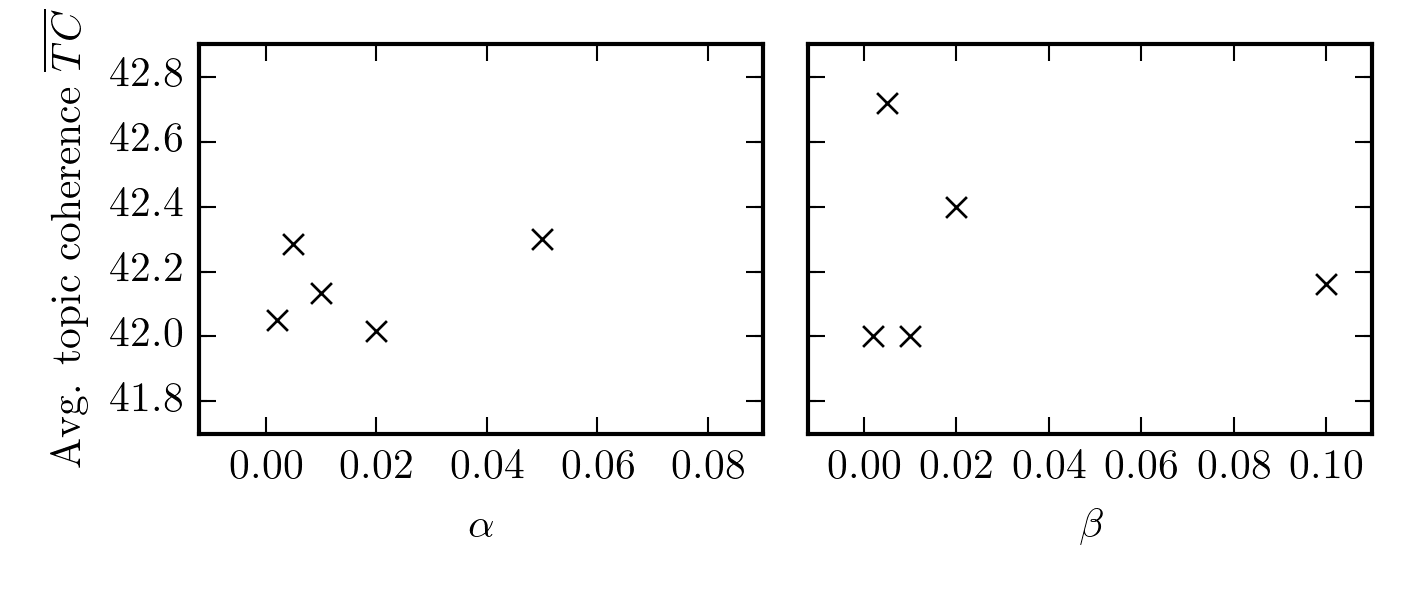

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=cm2inch(12, 5), dpi=300)
df_tc_lda["Avg. topic coherence $\\overline{TC}$"] = df_tc_lda["TC"] * 100
df_tc_lda.groupby("alpha").mean().reset_index().plot(x="alpha", y="Avg. topic coherence $\\overline{TC}$",
                                                     c="black", marker="x", s=25, linewidth=0.65, kind="scatter", ax=ax1)
#ax1.set_xticks(ax1.get_xticks()[::2])
#ax1.set_yticks(ax1.get_yticks()[1:])
ax1.set_xlim((-0.012, 0.09))
ax2.set_xlim((-0.012, 0.11))
ax1.set_ylim((41.7, 42.9))
df_tc_lda.groupby("beta").mean().reset_index().plot(x="beta", y="Avg. topic coherence $\\overline{TC}$",
                                                    c="black", marker="x", s=25, linewidth=0.65, kind="scatter", ax=ax2)
ax1.set_xlabel("$\\alpha$")
ax2.set_xlabel("$\\beta$")
plt.tight_layout()

In [21]:
df_tc_lda["TC"].mean()

0.4215666666666667

In [12]:
df_tc_lda["TC"].std()

0.006173823122994619

In [11]:
df_tc_lda_nips = load_topic_coherence("lda_nips.txt")
df_tc_lda_nips.columns = ["alpha", "beta", "TC", "TC_std"]
#df_tc_lda_nips = df_tc_lda_nips.sort_values("TC", ascending=False)
df_tc_lda_nips

alpha   beta     TC  TC_std
0   0.002  0.005  0.409   0.061
1   0.002  0.010  0.391   0.056
2   0.002  0.020  0.403   0.052
3   0.002  0.050  0.407   0.057
4   0.002  0.100  0.406   0.056
5   0.005  0.002  0.401   0.057
6   0.005  0.005  0.412   0.058
7   0.005  0.010  0.398   0.062
8   0.005  0.020  0.401   0.065
9   0.005  0.050  0.406   0.063
10  0.005  0.100  0.397   0.055
11  0.010  0.002  0.394   0.051
12  0.010  0.005  0.400   0.058
13  0.010  0.010  0.400   0.047
14  0.010  0.020  0.401   0.061
15  0.010  0.050  0.404   0.056
16  0.010  0.100  0.405   0.056
17  0.020  0.002  0.402   0.055
18  0.020  0.005  0.397   0.051
19  0.020  0.010  0.394   0.055
20  0.020  0.020  0.406   0.053
21  0.020  0.050  0.404   0.060
22  0.020  0.100  0.396   0.051
23  0.050  0.002  0.407   0.057
24  0.050  0.005  0.407   0.066
25  0.050  0.010  0.396   0.050
26  0.050  0.020  0.392   0.052
27  0.050  0.050  0.406   0.064
28  0.050  0.100  0.400   0.051

In [143]:
df_tc_lda_nips["TC"].mean()

0.401448275862069

<IPython.core.display.Javascript object>


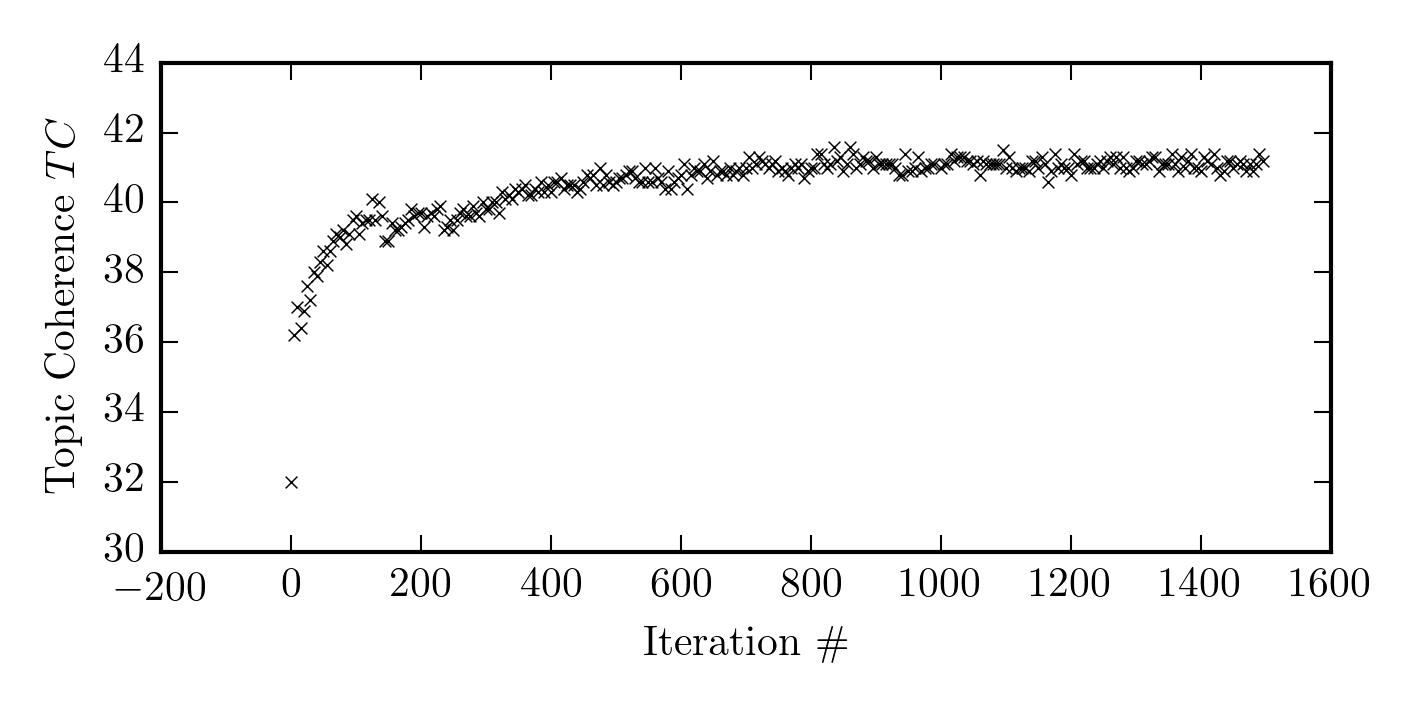

In [51]:
df_tc_lda_iterations = load_topic_coherence("palmetto_lda_topic_evolution.log")
df_tc_lda_iterations.columns = ["iteration", "TC", "TC_std"]
df_tc_lda_iterations["TC"] *= 100
#df_tc_lda_iterations.head(31)["TC"] = [x + y for x, y in zip(np.linspace(0.32, 0.389, 31), np.random.normal(0, 0.005, 31))]

plt.figure(figsize=cm2inch(12, 6), dpi=300)
#plt.xlim(-50, 1100)
plt.scatter(df_tc_lda_iterations["iteration"], df_tc_lda_iterations["TC"], marker="x", c="black", s=8, linewidth=0.35)
plt.xlabel("Iteration \\#")
plt.ylabel("Topic Coherence $TC$")
plt.tight_layout()

### LFLDA

LFLDA does not sample only from the multinomial topic-word distribution as LDA, but also in the embedding space by defining a word distribution for a given topic based on the similarity of words with the topic vector.
From which distribution to sample from is governed by the $\lambda$ parameter.

* $\alpha$, $\beta$: same as standard LDA
* $\lambda$: mixing factor between multinomial LDA and word embedding probability distribution. $\lambda = 1.0$ was reported to achieve highest topic coherence

In [83]:
df_tc_lflda = load_topic_coherence("lflda.txt")
df_tc_lflda.columns = ["embedding-dimension", "lambda", "alpha", "beta", "iteration", "TC", "TC_std"]
#df_tc_lflda = df_tc_lflda[df_tc_lflda["lambda"] == 0.6]
df_tc_lflda = df_tc_lflda[(df_tc_lflda["iteration"] - 1) % 10 == 2]
df_tc_lflda.head()

embedding-dimension  lambda  alpha  beta  iteration     TC  TC_std
2                   200     0.6   0.02  0.02          3  0.445   0.097
3                   200     1.0   0.02  0.02          3  0.464   0.095
12                  200     0.6   0.02  0.02         13  0.445   0.092
13                  200     1.0   0.02  0.02         13  0.450   0.095
22                  200     0.6   0.02  0.02         23  0.439   0.083

<IPython.core.display.Javascript object>


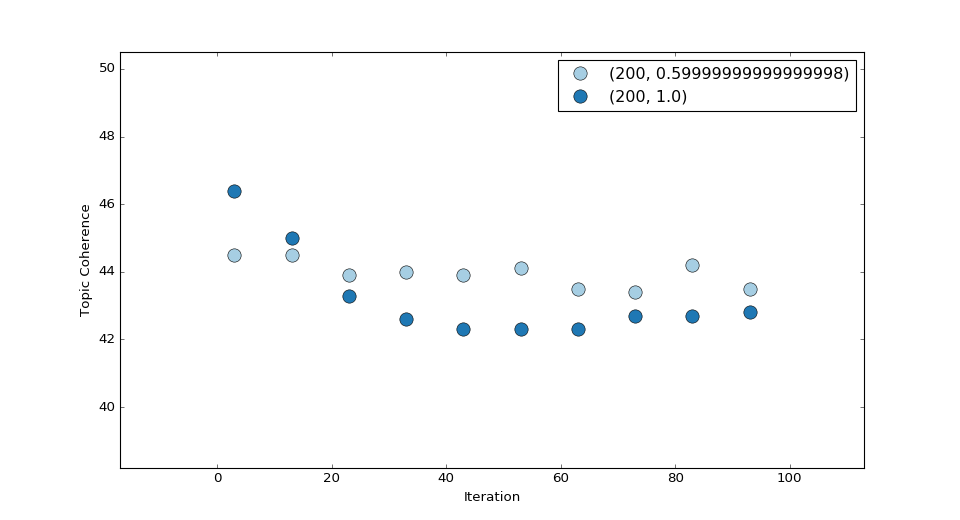

In [84]:
plot_iteration_for(df_tc_lflda, ["embedding-dimension", "lambda"], r=1)

In [97]:
df_tc_lflda2 = load_topic_coherence("lflda2.txt")
df_tc_lflda2.columns = ["embedding-dimension", "lambda", "alpha", "beta", "iteration", "TC", "TC_std"]
df_tc_lflda2.head()

embedding-dimension  lambda     alpha     beta  iteration     TC  TC_std
0                  200     0.6  1.746947  0.01607          0  0.420   0.075
1                  200     0.6  1.746947  0.01607          1  0.429   0.075
2                  200     0.6  1.746947  0.01607          2  0.440   0.093
3                  200     0.6  1.746947  0.01607          3  0.442   0.095
4                  200     0.6  1.746947  0.01607          4  0.443   0.091

<IPython.core.display.Javascript object>


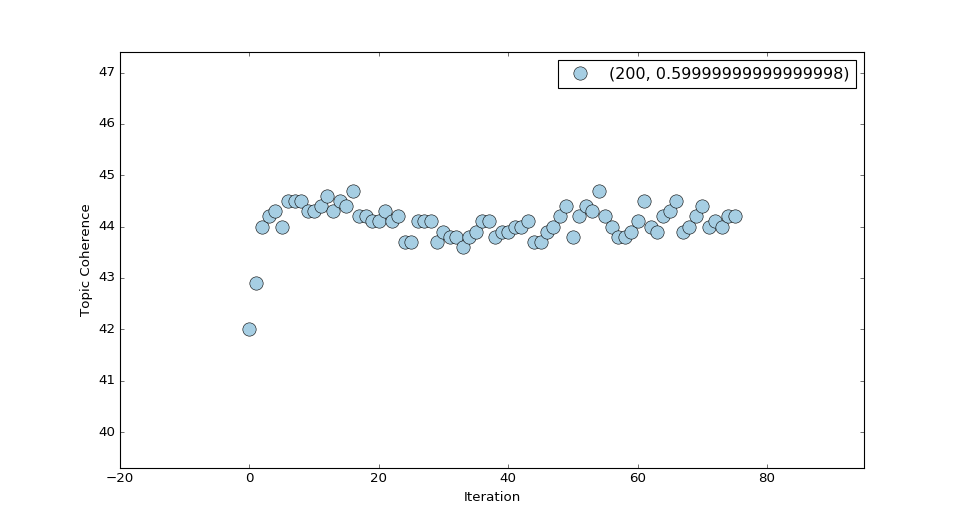

In [98]:
plot_iteration_for(df_tc_lflda2, ["embedding-dimension", "lambda"], r=1)

**Results**:
LFTM achieves improvements of $~ 1.8$ in TC.
Training time is very slow (see below).

**TODO**:
* In theory, LFTM should benefit from higher nr. of dimensions and should achieve lower results with less dimensions.
* NIPS!

### TopicVec

TopicVec replaces the multinomial topic-word distribution from LDA and replaces with an WE-inspired word distribution based on the immediate context of a word. Topics are points in the embedding space.

**Parameters**:

* number of topic dimensions
* $\alpha$: same as LDA

In [13]:
df_tc_topicvec = load_topic_coherence("topicvec.txt")
df_tc_topicvec.columns = ["corpus", "embedding-dimension", "iteration", "TC", "TC_std"]
df_tc_topicvec = df_tc_topicvec.sort_values(["corpus", "embedding-dimension", "iteration"])
df_tc_topicvec.head()

corpus  embedding-dimension  iteration     TC  TC_std
33   orig                   50        100  0.426   0.085
35   orig                   50        500  0.468   0.069
34   orig                  100        100  0.414   0.070
36   orig                  200        500  0.485   0.082
1     our                   50          1  0.312   0.019

<IPython.core.display.Javascript object>


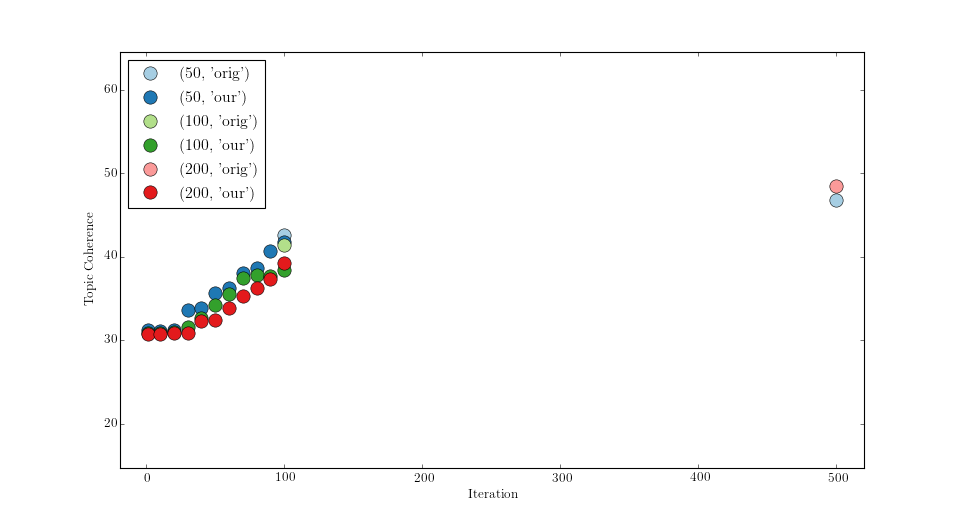

In [14]:
plot_iteration_for(df_tc_topicvec, ["embedding-dimension", "corpus"])

**Results**:
TopicVec achieves the highest topic coherence with 46.8.
Higher dimensions converge slower, but seem to end with higher TC.

**TODO**:
* TopicVec achieves higher results with the original data set, which does not lowercase, does not remove stop words.
* Need to explore the space between 100-500 iterations

In [8]:
df_tc_topicvec_topics = pnd.read_csv("/home/knub/Repositories/topicvec/results/corpus-orig.dim-50.iterations-500/topics", sep=" ", header=None)
df_tc_topicvec_topics.columns = ["topic-id", "probability"] + list(range(1, 11))
df_tc_topicvec_topics

IOError: File /home/knub/Repositories/topicvec/results/corpus-orig.dim-50.iterations-500/topics does not exist

**With 20news.dim-50 embeddings**

<IPython.core.display.Javascript object>


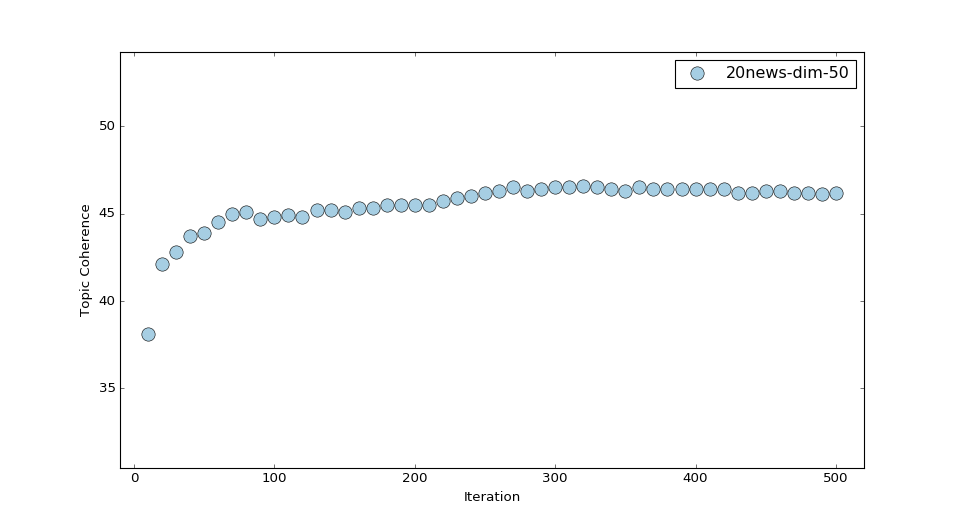

In [82]:
df_tc_topicvec_20news_dim50 = load_topic_coherence("topicvec.embedding-20news-dim-50.txt")
df_tc_topicvec_20news_dim50.columns = ["embedding", "iteration", "TC", "TC_std"]
df_tc_topicvec_20news_dim50 = df_tc_topicvec_20news_dim50.sort_values(["embedding", "iteration"])
plot_iteration_for(df_tc_topicvec_20news_dim50, ["embedding"])

### Gaussian LDA

Learning works better with **lower number of dimensions** (50 instead of 200).
Results are better, but still not good

> Yes, I have a feeling, I ran the experiments on 50 dimensional vectors.
> I am a little sad that it does not work for higher dimensional embeddings, but clearly there is something interesting going on which might give some insights about the structure of the space. Can you point me to the topics for D = {50, 200}.


Topics are better, but still not good. Previously, the topics were **almost uniform**.

Now, actual topics emerge but there are still a lot of noise topics. **Pre-initializing the topic vectors** to the **mean** of standard LDA's topics did not help

**Parameters:**
* $\alpha$: as in standard LDA
* number of dimensions

In [18]:
pnd.read_csv("/home/stefan.bunk/Gaussian_LDA/results/old/dim-50.alpha-0-02.output/090.topics", sep=" ", header=None)

0                 1             2             3  \
0            squarewave         quickdraw    reradiated  power-assist   
1           strong-hold               s.q       vatican       salyuts   
2                   s.q             f.a.q         o.h.o       wetbike   
3                 three               two          good          many   
4                people        government         world         group   
5                 state               s.q   strong-hold         wiley   
6                   buy          purchase          sell        buying   
7            pre-judged         obviously  bullshitting       clearly   
8                 f.a.q            wayner         a.s.s           s.q   
9                  team              game         white         games   
10               anyone               man       someone        around   
11                magen               fus           ijo           miu   
12                  c.r  schedule/results           s.q         brett   
13           parturient               orf      darvocet           fuo   
14              article              work      question       problem   
15                  c.r  schedule/results           s.q         brett   
16          backordered          messiest           s.q     smalltalk   
17            patterson              dunn      anderson      thompson   
18              windows            thanks          name        window   
19                  c.r               ijh           civ          mdme   
20                  max             magen         david           u.u   
21                  gun               etc       psy-ops      soldiers   
22                years              year           day          days   
23                  apr           russell       bennett      thompson   
24                  c.r  schedule/results           s.q         brett   
25                  c.r  schedule/results           s.q         brett   
26              vatican        adjuration         koran           cok   
27                f.a.q            mscdex       fortran       contrib   
28  energy-conservation        mail-based     paycheque   strong-hold   
29                  c.r  schedule/results           s.q         brett   
30                  wob            tation           slc           cts   
31                would               one        writes           get   
32                  c.r  schedule/results           s.q         brett   
33               e-mail             email      internet          mail   
34                  c.r  schedule/results           s.q         brett   
35                  gry         smalltalk   backordered    in-context   
36              fortran     function-call     uuencoded       keymaps   
37                 back              says          came        trying   
38         bullshitting              tell      consider        forget   
39                  mac               c.r         a.s.s          mdme   
40                right             drive         south         north   
41              m.y.o.b             f.a.q       doo-doo       bigtime   
42                 even           however        indeed     obviously   
43           university           program           law          post   
44               system              file      software       systems   
45                sound              show       picture       menuing   
46              jaffari             fazah         honer         danke   
47               bopped               s.q  bullshitting   strong-hold   
48                  bad          problems    parturient          care   
49             naehring           sandlak   konowalchuk       zamuner   

               4               5               6               7  \
0       push-pin     guard-rails         degauss      lightmeter   
1          a.s.s      offroading      stillwater            jcfs   
2          lernu     strong-hold             wob         a.i.d.s   
3            new          

In [88]:
df_tc_gaussian = load_topic_coherence("gaussian_lda.txt")
df_tc_gaussian.columns = ["iteration", "initialization-method", "embedding-dimension", "alpha", "TC", "TC_std"]
df_tc_gaussian = df_tc_gaussian.sort_values(["embedding-dimension", "initialization-method", "alpha", "iteration"])
df_tc_gaussian.head()

iteration initialization-method  embedding-dimension  alpha     TC  TC_std
43          0                  mean                   50   0.02  0.260   0.016
44         10                  mean                   50   0.02  0.347   0.084
45         20                  mean                   50   0.02  0.356   0.091
46         30                  mean                   50   0.02  0.360   0.090
47         40                  mean                   50   0.02  0.369   0.090

<IPython.core.display.Javascript object>


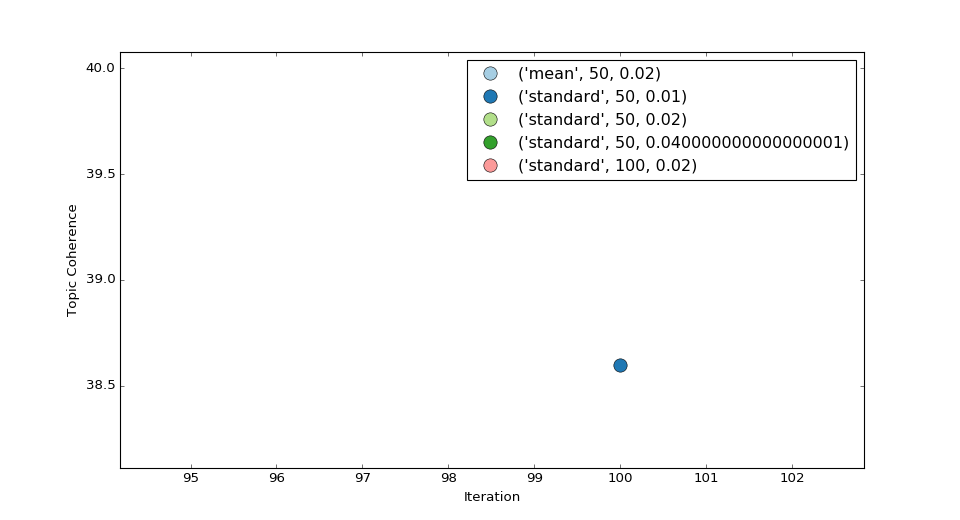

In [89]:
plot_iteration_for(df_tc_gaussian, ["initialization-method", "embedding-dimension", "alpha"], r=0.2)

**Iterations against likelihood**

<IPython.core.display.Javascript object>


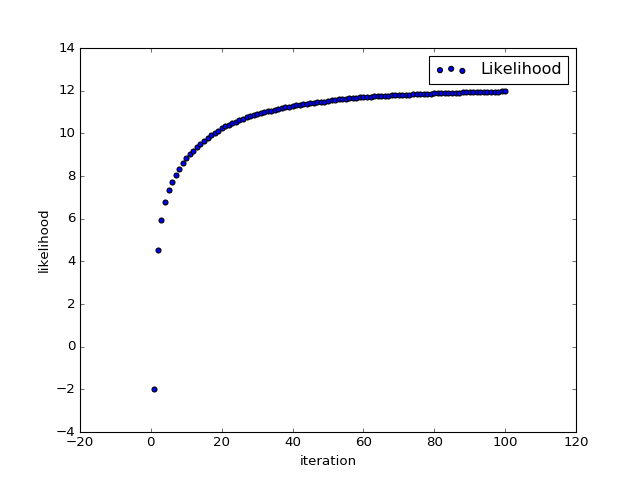

In [92]:
df_tc_gaussian_iterations = pnd.read_csv("/home/knub/Repositories/Gaussian_LDA/results/old/initialization-mean.dim-50.alpha-0-02.output/iterations.txt", sep="\t")
df_tc_gaussian_iterations.plot("iteration", "likelihood", kind="scatter", label="Likelihood")

**Time for each iteration**

<IPython.core.display.Javascript object>


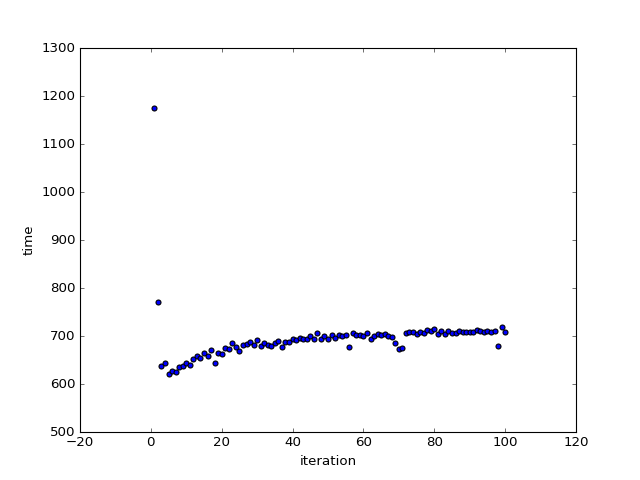

In [93]:
df_tc_gaussian_iterations.plot("iteration", "time", kind="scatter")

**Results:** Gaussian LDA achieves the lowest TC of all systems. Also, the model cannot handle higher dimensions.

**TODO:**
* Answer author, no further investigation until new insights

**NIPS**

<IPython.core.display.Javascript object>


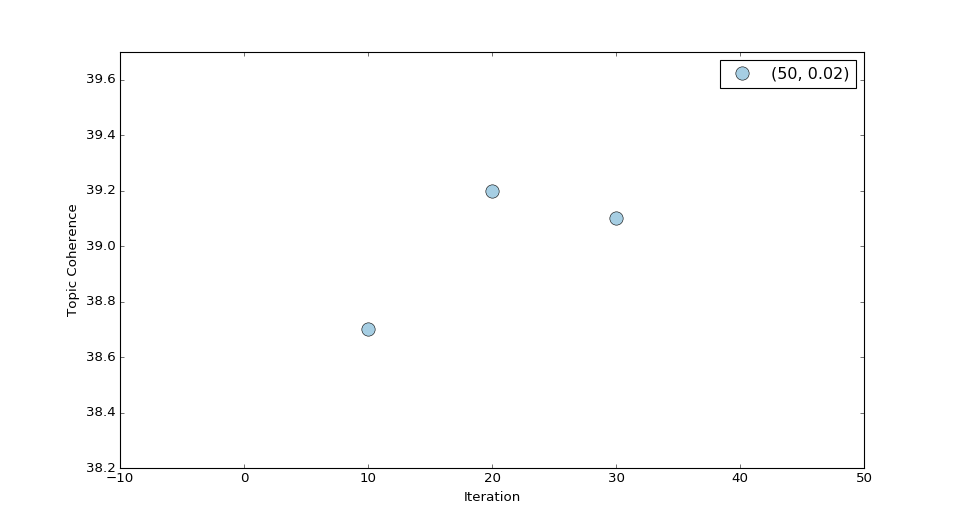

In [99]:
df_tc_gaussian_nips = load_topic_coherence("gaussian_lda_nips.txt")
df_tc_gaussian_nips.columns = ["iteration", "dataset", "embedding-dimension", "alpha", "TC", "TC_std"]
plot_iteration_for(df_tc_gaussian_nips, ["embedding-dimension", "alpha"], r=1.0)

In [96]:
pnd.read_csv("/home/knub/Repositories/Gaussian_LDA/results/data-nips.dim-50.alpha-0-02/030.topics", sep=" ", header=None)

0              1               2               3  \
0           number       examples       structure    architecture   
1    computational     components        computer         dynamic   
2         schottky            r/c           arris          hollow   
3             size           real            true           equal   
4      connections           line        proposed      connection   
5           states       location            code           motor   
6          fortran            vec             uop            thau   
7             term       positive      classifier        variable   
8           figure          shown           shows        features   
9            field         points           level            step   
10        consider           make            find         present   
11           whose     associated           joint        starting   
12          neural         single        adaptive      simulation   
13             one            two           three           first   
14           leigh        vatican           centr             a-i   
15        response         result      consistent         cluster   
16            emer        hoffman           desir        schwartz   
17         another   respectively       including          latter   
18            word          words       potential       according   
19             set          using            time            used   
20           units           unit            task         general   
21         chicago           book      collection             pcb   
22  classification    statistical             ing            proc   
23         belling            bti             m.o           wiley   
24          theory       problems        dynamics        accuracy   
25            much           good            less          rather   
26         circuit       circuits         program         primary   
27             map       parallel       available            maps   
28        removing        ability       determine         prevent   
29            rate        average        estimate       threshold   
30         optimal         define      continuous           every   
31       increases       computed            role        measured   
32            take           give          obtain         provide   
33         neurons          cells          neuron          visual   
34            even         random           often         usually   
35       generated      increased        observed     distributed   
36       procedure          cases        stimulus         context   
37          center           area          entire           whole   
38        thompson        bennett            dunn            rowe   
39           based     difference     correlation           bound   
40          vector         linear          matrix  generalization   
41        learning       training       algorithm     performance   
42        jacobian  single-valued  boolean-valued         lorentz   
43         network          model           input            data   
44      techniques           flux       technique   physiological   
45           layer            fig          object        standard   
46           noise         sample       frequency         samples   
47            rule          terms        decision           rules   
48           state          paper          speech        obtained   
49          merely        brought             m.o          seeing   

                4             5                6            7  \
0     independent    references          complex       effect   
1    applications  optimization      application   technology   
2             pcb          soft              rod     circular   
3          amount         shape          product        sense   
4       connected         lines         selected        added   
5           pairs         exact            parts      storage   
6           tamar          canu           

### sHDP

Similar to Gaussian LDA, but models a von Mises-Fisher distribution on the hypercube instead of a Gaussian distribution in the embedding space.

**Parameters**:
* $\kappa \in (0.5, 1]$, $\tau \in [0;)$: parameters for the learning rate of SGD
* $\gamma$: stick-breaking parameter 
* $\alpha$: concentration parameter for the Dirichlet process

So far no results with 20news. **Parameter search** did not help:

> As far as I remember we couldn't get the same good performance of nips dataset with 20news (as we reported in Table 2). However, other methods were also doing poorly on the same dataset. One reason for that could be using 50-dimensional word2vec representations; we didn't try other possible pretrained word vector representations with higher dimensions (e.g. Glove). Also we didn't try larger minibatch sizes (e.g. 100) for SVI training. These modifications might have improved the results for 20news corpus.  

> We've been using the model in the medical domain and we are getting good performance; however, one observation that we had was the quality of the sHDP is dependent on the quality of pretrained word vectors that we use.

In [24]:
# kappa, tau in [(0.6, 0.8), (0.505, 0.8), (0.6, 0.1), (0.6, 10), (0.6, 100)]:
    # alpha in [0.5, 0.9, 1.0, 1.5, 10]:
        # gamma in [0.5, 1.0, 1.5, 10]:
            # run_shdp()

<IPython.core.display.Javascript object>


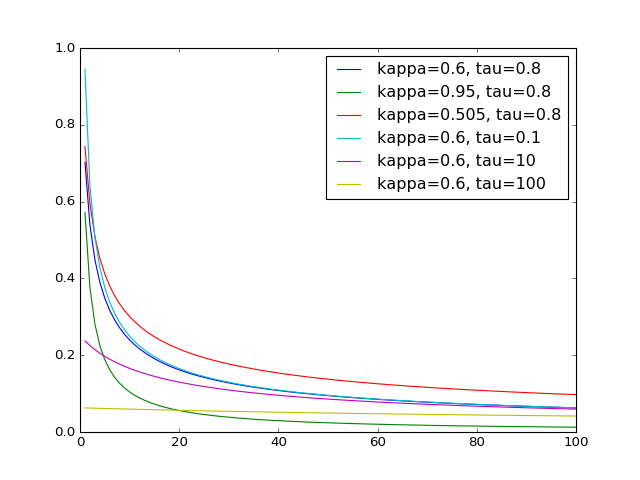

In [25]:
x = np.arange(1, 101)
plt.figure()
for kappa, tau in [(0.6, 0.8), (0.95, 0.8), (0.505, 0.8), (0.6, 0.1), (0.6, 10), (0.6, 100)]:
    y = (x + tau)**(-kappa)
    plt.plot(x, y, label="kappa=" + str(kappa) + ", tau=" + str(tau))

plt.legend()

In [86]:
df_tc_shdp_nips = load_topic_coherence("shdp_nips.txt")
df_tc_shdp_nips.columns = ["embeddings", "dimensions", "seed", "topics", "alpha", "gamma",
                           "kappa", "tau", "step-size", "TC", "TC_std"]
df_tc_shdp_nips["iteration"] = 1
df_tc_shdp_nips

embeddings  dimensions  seed  topics  alpha  gamma  kappa  tau  step-size  \
0     theirs          50     1      50    1.0    2.0    0.6  0.8         10   
1       ours          50     1      50    1.0    2.0    0.6  0.8         10   

      TC  TC_std  iteration  
0  0.375   0.084          1  
1  0.362   0.058          1

<IPython.core.display.Javascript object>


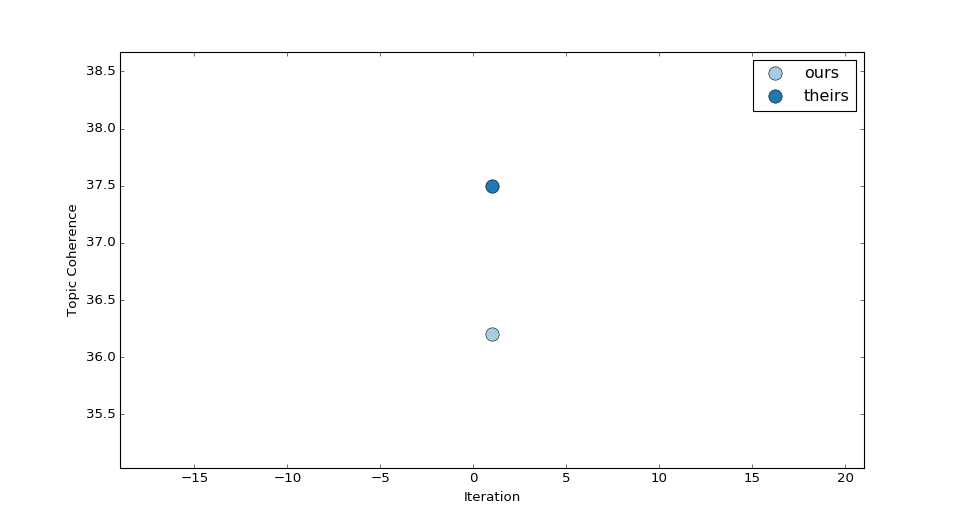

In [87]:
plot_iteration_for(df_tc_shdp_nips, ["embeddings"])

**NIPS**

In [29]:
df_tc_shdp_nips_topics = pnd.read_csv("/home/stefan.bunk/sHDP/results/20news/embeddings-ours.dim-50.seed-1.topics-50.alpha-1-0.gamma-2-0.kappa-0-6.tau-0-8.batch-10/prob-based.topics", header=None, sep=" ")
df_tc_shdp_nips_topics

0             1                2              3             4  \
0   computation      solution    approximation     stochastic       entropy   
1           ten      training             list    probability         times   
2          code       updates     applications        derived     parameter   
3      networks       centers          measure          shown       related   
4     activated       trained             unit          total         apply   
5       current     positions         networks       division          find   
6         model         input        circuitry         neural   frequencies   
7       partial        caused           change      resulting          lack   
8       version  presentation      information          shown       current   
9    consisting        report            means          local     dependent   
10       values        number          control           size         learn   
11   consistent     desirable  straightforward        systems      abstract   
12     contrast    references          uniform      analogous          type   
13          sci         monte              dis         values          part   
14      results     technique           method     prediction    experiment   
15         case     decisions              due     applicable           set   
16         work     component           values        science    university   
17      control        figure           values          learn        morgan   
18      dynamic   environment          concept       dynamics         focus   
19    presented     supported         obtained    represented         order   
20       design          rate         abstract           cost        neural   
21          eds   illustrated          editors    information         order   
22       layers         upper          smaller         larger         small   
23       stable        poorly   simultaneously         number      abstract   
24      finally     neighbors              set          turns          sons   
25      section    references             data           path    directions   
26       chosen   convenience           miller            box       systems   
27   university         found       references           term          note   
28       search   information        performed           high      obtained   
29   difference        choice        condition     similarity         exact   
30        large         small           vector       solution         chain   
31       global     advantage           issues  international     technical   
32       entire          past            worst         models          test   
33          row          pass           values         output   information   
34      michael  introduction          science         values        system   
35       vector         large         discrete        inverse         graph   
36        shown       measure          objects        related       special   
37     existing        system     introduction         single  neighborhood   
38       figure           set           result         states         fixed   
39      updated        number       references    probability         prior   
40    represent        depend           follow         values          find   
41        level         fewer             high     processing        figure   
42     consists         leads      illustrates       presents         makes   
43   activation         nodes    physiological      localized          cell   
44        force         tasks           action        targets     resulting   
45        paper      machines      information       abstract      function   
46         rate          cost        estimates            net           sum   
47      limited          full           direct        desired        giving   
48      include      segments      expressions     processing         cases   
49    institute         study            shown        program   

**Results**:
Similarly to Gaussian LDA, learning a model/finding the right parameters is hard. The model also seems to have a problem with higher dimensions.

**TODO**:
* Ask author for regarding parameter settings for 20news

### WELDA-Gaussian

#### Stuff

WELDA resamples the words in the text based on a Gaussian distribution over the topic space. The resample probability is $\lambda$.

* $\alpha$, $\beta$: standard LDA
* $\lambda$: resample probability

<IPython.core.display.Javascript object>


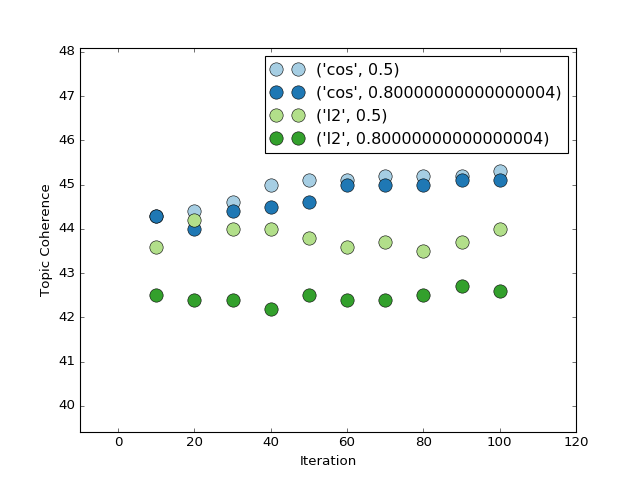

In [5]:
df_tc_welda = load_topic_coherence("gaussian_welda.txt")
df_tc_welda.columns = ["iteration", "distance-method", "lambda", "TC", "TC_std"]
df_tc_welda = df_tc_welda.sort_values(["distance-method", "lambda", "iteration"])
plot_iteration_for(df_tc_welda, ["distance-method", "lambda"])

**Results**:
WELDA increases the TC compared to standard LDA by $~ 2.8$. After topicvec, it is the second best model with regards to TC.

<IPython.core.display.Javascript object>


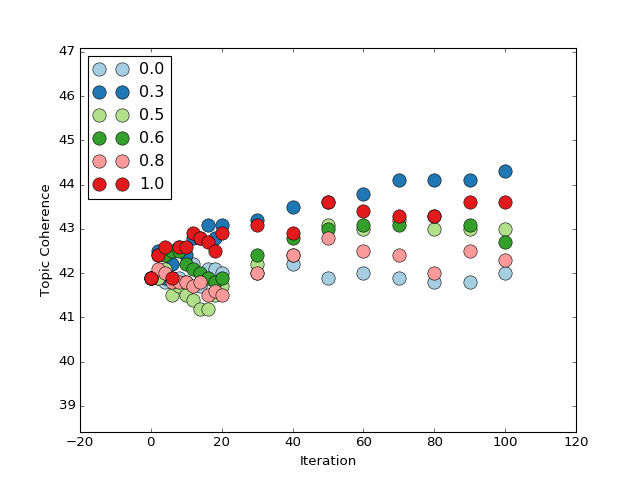

In [4]:
df_tc_welda_2 = load_topic_coherence("gaussian_welda2.txt")
df_tc_welda_2.columns = ["embedding-dimension", "distance-method", "lambda", "iteration", "TC", "TC_std"]
df_tc_welda_2 = df_tc_welda_2.sort_values(["lambda", "iteration"])
plot_iteration_for(df_tc_welda_2, ["lambda"])

**With 20news.dim-50 embedding**

<IPython.core.display.Javascript object>


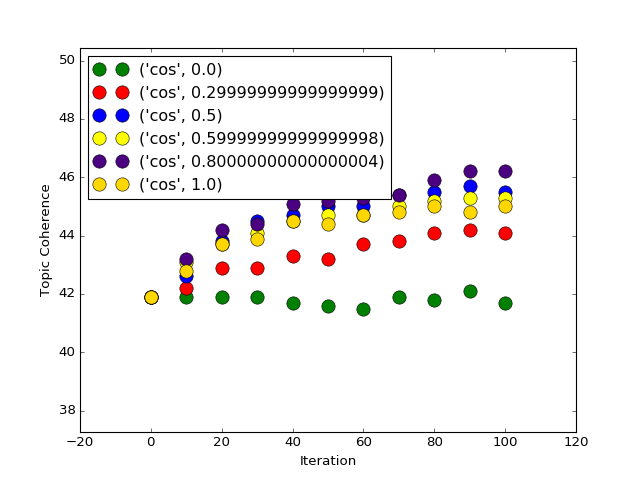

In [51]:
df_tc_welda_gaussian_20news = load_topic_coherence("gaussian_welda.embedding-20news-dim-50.txt")
df_tc_welda_gaussian_20news.columns = ["embedding-dimension", "distance-method", "lambda", "iteration", "TC", "TC_std"]
df_tc_welda_gaussian_20news = df_tc_welda_gaussian_20news.sort_values(["distance-method", "lambda", "iteration"])
plot_iteration_for(df_tc_welda_gaussian_20news, ["distance-method", "lambda"])

**NIPS**

In [111]:
df_tc_nips_welda = load_topic_coherence("gaussian_welda_nips.txt")
df_tc_nips_welda.columns = ["iteration", "embedding-dimensions", "distance-method", "lambda", "TC", "TC_std"]
df_tc_nips_welda = df_tc_nips_welda[df_tc_nips_welda["iteration"] % 10 == 0]
df_tc_nips_welda.head()

iteration  embedding-dimensions distance-method  lambda     TC  TC_std
0           0                   200             cos     0.5  0.409   0.055
5          10                   200             cos     0.5  0.406   0.063
10         20                   200             cos     0.5  0.412   0.065
15         30                   200             cos     0.5  0.411   0.067
20         40                   200             cos     0.5  0.415   0.069

In [117]:
#plot_iteration_for(df_tc_nips_welda, ["lambda"])

<IPython.core.display.Javascript object>


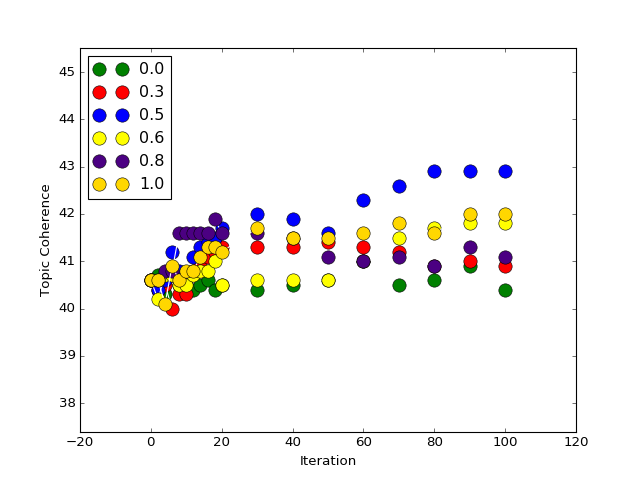

In [49]:
df_tc_nips_welda2 = load_topic_coherence("gaussian_welda_nips2.txt")
df_tc_nips_welda2.columns = ["embedding-dimensions", "distance-method", "lambda", "iteration", "TC", "TC_std"]
plot_iteration_for(df_tc_nips_welda2, ["lambda"])

**Results:** Again WELDA increases the TC by $0.4$

**New sampling method**

In [52]:
df_tc_welda3 = load_topic_coherence("gaussian_welda.sampling-corrected.txt")
df_tc_welda3.columns = ["embedding-dimensions", "distance-method", "lambda", "iteration", "TC", "TC_std"]

<IPython.core.display.Javascript object>


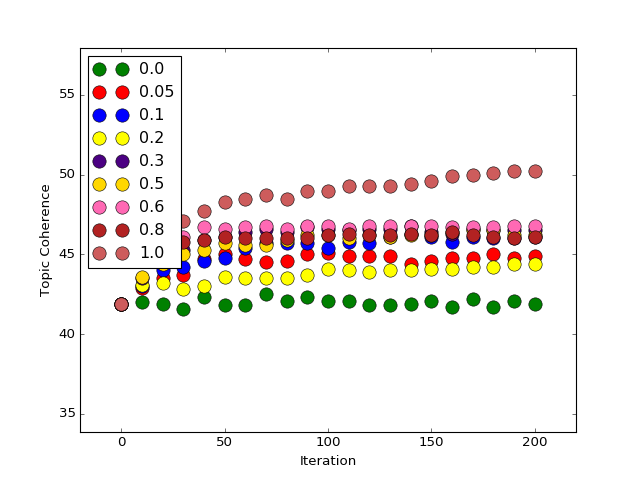

In [53]:
plot_iteration_for(df_tc_welda3[df_tc_welda3["embedding-dimensions"] == "20news-50"], ["lambda"])

<IPython.core.display.Javascript object>


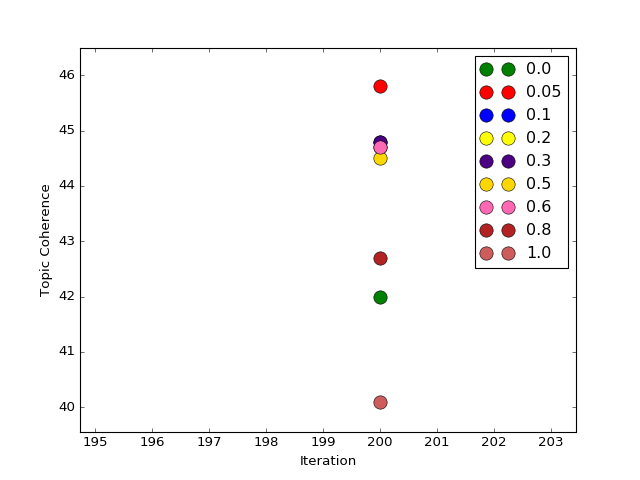

In [312]:
plot_iteration_for(df_tc_welda3[df_tc_welda3["embedding-dimensions"] == "200"], ["lambda"])

**Topics from the overfitted lambda=1.0 experiment**

In [80]:
pnd.read_csv(
    "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-1-0/welda.iteration-200.topics",
    sep=" ", header=None)

0             1          2            3           4            5   \
0    0  klopfenstein    jeffery         jill       mahan       dickey   
1    1        viking   anderson      douglas         d.f         hugo   
2    2           tal  frederick        billy       chung       hsiung   
3    3        watson        mau      broward      warren    president   
4    4       roberts     steven         wade         lam          crh   
5    5     bernstein      lewis    frederick      prasad       warren   
6    6         moore      carol        simon    anderson        wrote   
7    7           dsh       kubo       godwin        carr          tal   
8    8         peter    william        lewis         dan          apr   
9    9       carrion      eaton       deepak        file        entry   
10  10     rejoinder      perry      article       moore       writes   
11  11       roberts      perry      webster       simon       prasad   
12  12        gadfly    patrick        julie     william  breastplate   
13  13   buckminster  frederick         kent     article       writes   
14  14        dwayne       warf        moore  rethinking      william   
15  15       ebright   schneier        shaun   bernstein          pdc   
16  16           kim     viking     wolfgang     strider          dan   
17  17       kolstad      duane      moffatt       billy        bryan   
18  18       patrick    moffatt         yong       berry        billy   
19  19       maurice    suzanne       norris      health     response   
20  20         adams    article          sez        padi          pat   
21  21       patrick       amen        berry      murphy        geoff   
22  22     humphreys        grf        lotto     klinger   sturdevant   
23  23         carol     barton        arens         sez         hays   
24  24       patrick      foley       philly       roger         gary   
25  25           d.f    curious         gill      duncan        douce   
26  26       kissane     murphy         dean         jeh          faq   
27  27        viking    mueller          cam         kim       kludge   
28  28         carol       mann      article      writes    schneider   
29  29      remember      stank         know   something    schneider   
30  30           yin      moore      avinash         rdd       viking   
31  31         berry    article  remembering      writes          msg   
32  32         mahan    carrion      article        wade      patrick   
33  33        prasad   emporium        eaton       billy       staudt   
34  34       article       fred       writes       wrote      kubilay   
35  35           wri        max          hah   humphreys      carrion   
36  36          carr      ching          mrc      marvin      william   
37  37       patrick      carol        jones     article          kin   
38  38           wri        tes       panics       kratz        martz   
39  39       casares  frederick        carol   bernstein      patrick   
40  40       kubilay    article      patrick        shaw         jews   
41  41           cam   lindroos        ching       carol      patrick   
42  42         roush    article         wade      duncan       murphy   
43  43        barton    article        wrote    armenian      turkish   
44  44       article        lou       writes       scott        gerry   
45  45       article     viking        wrote   nathaniel       writes   
46  46        dwayne      reply        foley     posting        a.k.a   
47  47        laking      ketil      leonard     kissane        ranck   
48  48       hartman  nathaniel        scott      marten        peter   
49  49         spira        cmk        prado       roger       writes   

                6          7          8          9           10  
0           felder      novak        hui        dsh        usui  
1            space     steven     auburn       larc     suppose  
2             shaw      drive        csc       scsi         zur  
3   stephanopoul

**Topics from the best lambda=0.6 experiment**

In [54]:
pnd.read_csv(
    "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-6/welda.iteration-200.topics",
    sep=" ", header=None)


IOError: File /data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-6/welda.iteration-200.topics does not exist

**Top sampling**

<IPython.core.display.Javascript object>


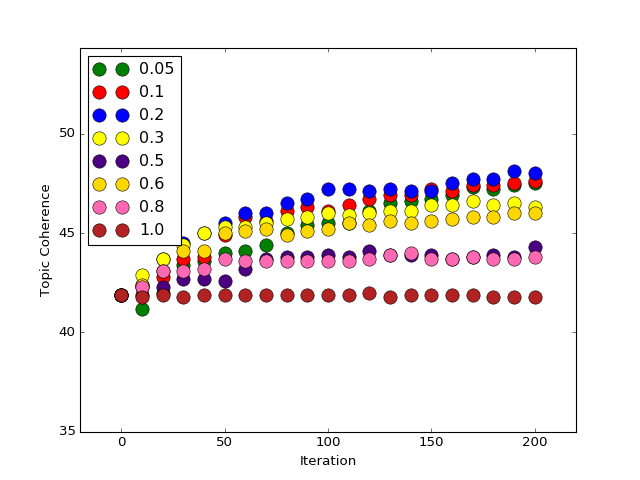

In [319]:
df_tc_welda_top = load_topic_coherence("gaussian_welda_top.txt")
df_tc_welda_top.columns = ["file", "embedding-dimensions", "sampling", "distance-method", "lambda", "iteration", "TC", "TC_std"]
plot_iteration_for(df_tc_welda_top[df_tc_welda_top["embedding-dimensions"] == "20news-50"], ["lambda"])

<IPython.core.display.Javascript object>


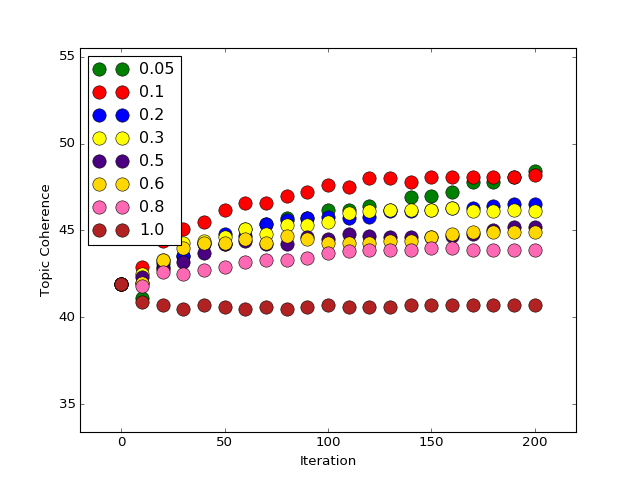

In [320]:
df_tc_welda_top = load_topic_coherence("gaussian_welda_top.txt")
df_tc_welda_top.columns = ["file", "embedding-dimensions", "sampling", "distance-method", "lambda", "iteration", "TC", "TC_std"]
plot_iteration_for(df_tc_welda_top[df_tc_welda_top["embedding-dimensions"] == "200"], ["lambda"])

In [322]:
df_tc_welda_top[df_tc_welda_top["TC"] > 0.48]

file  \
61   model.20news.dim-50.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-2/welda.iteration-190.topics   
187       model.dim-200.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-05/welda.iteration-190.topics   
188       model.dim-200.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-05/welda.iteration-200.topics   
204        model.dim-200.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-1/welda.iteration-150.topics   
205        model.dim-200.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-1/welda.iteration-160.topics   
206        model.dim-200.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-1/welda.iteration-170.topics   
207        model.dim-200.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-1/welda.iteration-180.topics   
208        model.dim-200.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-1/welda.iteration-190.topics   
209        model.dim-200.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-1/welda.iteration-200.topics   

    embedding-dimensions sampling distance-method  lambda  iteration     TC  \
61             20news-50      top             cos    0.20        190  0.481   
187                  200      top             cos    0.05        190  0.481   
188                  200      top             cos    0.05        200  0.484   
204                  200      top             cos    0.10        150  0.481   
205                  200      top             cos    0.10        160  0.481   
206                  200      top             cos    0.10        170  0.481   
207                  200      top             cos    0.10        180  0.481   
208                  200      top             cos    0.10        190  0.481   
209                  200      top             cos    0.10        200  0.482   

     TC_std  
61    0.084  
187   0.096  
188   0.095  
204   0.086  
205   0.087  
206   0.087  
207   0.088  
208   0.089  
209   0.090

In [326]:
pnd.read_csv(
    "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-1/welda.iteration-080.topics",
    sep=" ", header=None).drop(0)

0             1               2           3          4           5   \
1    1         space          launch        nasa      orbit   satellite   
2    2          scsi           drive      drives       disk         ide   
3    3     president  stephanopoulos        give    setting       myers   
4    4           car            cars      engine        oil       tires   
5    5       science          theory  scientific  happening  conference   
6    6           god           jesus        give     christ       bible   
7    7       militia       amendment        file        gun    firearms   
8    8           yet         putting       still      would      though   
9    9         entry          output        file     printf         int   
10  10        israel         israeli        jews       arab       arabs   
11  11           god        atheists     atheism      exist  attempting   
12  12    government      attempting      people       take        even   
13  13         enjoy            tyre     sandvik     sleeve        batf   
14  14           fbi            fire      koresh   compound        batf   
15  15    encryption             key       sorts       chip     clipper   
16  16           gun            guns       crime       rate   criminals   
17  17     excellent            sale       audio   shipping       offer   
18  18    overpriced           radar         car   detector   insurance   
19  19  tremendously          health      cancer    medical        aids   
20  20         henry            moon        nasa       risc      flight   
21  21        period             pts        play     flyers        game   
22  22   misdirected            bike      helmet       ride        bets   
23  23           adl           trial      weaver        san     bullock   
24  24        hockey        audience        game        gld       roger   
25  25           mov          points        byte    polygon         den   
26  26      grounded          ground        wire     wiring     neutral   
27  27         image       available    graphics        ftp     package   
28  28     objective        morality       moral      keith    absolute   
29  29          went       happening   armenians  apartment     sumgait   
30  30        saving           files        jpeg    windows        file   
31  31           msg            food    patients    disease        dyer   
32  32        cramer             men  homosexual     sexual         sex   
33  33         water         keeping     putting       much         air   
34  34         islam          henrik     armenia    islamic   armenians   
35  35           max             giz      wagers        air         uww   
36  36           dos           cover     appears        art   wolverine   
37  37          card             mhz       video        com         ram   
38  38         drugs             gun      police   revolver      things   
39  39           san             new         won      april        lost   
40  40       turkish        audience        jews      greek      turkey   
41  41        borrow            team      hockey        nhl      season   
42  42       tougher         players      braves     league       lopez   
43  43      armenian         turkish   armenians   genocide     armenia   
44  44          give           enjoy     anybody  searching      anyone   
45  45          bike             dod         dog      bikes         bmw   
46  46       keeping       anonymous        send   internet     privacy   
47  47    allocation            unit       cross     linked       forth   
48  48    expectedly             van         bos        det         chi   
49  49           way           forth      giving    keeping        keep   

            6            7                8            9               10  
1        lunar      shuttle          mission   spacecraft           earth  
2   controller         hard          setting         mb/s             bus  
3         jobs      packa

In [327]:
pnd.read_csv(
    "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-05/welda.iteration-200.topics",
    sep=" ", header=None).drop(0)


0               1           2            3           4                5   \
1    1           orbit       space       launch   satellite            lunar   
2    2            scsi       drive          ide      drives       controller   
3    3  stephanopoulos   president     recreate        give            myers   
4    4             car        cars       engine         oil            tires   
5    5      surprising    mediocre       larson     science           theory   
6    6           jesus         god         give      christ            bible   
7    7         militia   amendment      firearm    firearms           weapon   
8    8         realize   something        wrong       think          hurting   
9    9           entry      output       printf        char             file   
10  10          israel     israeli     lebanese        arab            arabs   
11  11           wrong         god      atheism    atheists          weakest   
12  12      surprising        want   government      people             make   
13  13            tyre      sleeve         good        ever          ezekiel   
14  14          sanity         fbi         roby       wrong             ploy   
15  15      encryption         key         chip         des          clipper   
16  16             gun        guns        manes   homicides         homicide   
17  17           audio         amp         make        good              pin   
18  18           radar    detector    realizing      saturn             make   
19  19          cancer      health          hiv  compliment      troublesome   
20  20           henry        risc  instruction        moon           flight   
21  21          period         pts       flyers        play          nasties   
22  22     competently      helmet         bike       wrong  countersteering   
23  23             adl     bullock       weaver       arens        francisco   
24  24          hockey      gainey          gld         abc             espn   
25  25             mov        byte          den     polygon           offset   
26  26            wire      ground       wiring     neutral          outlets   
27  27            plot     drawing         send     package              ftp   
28  28       objective    morality        wrong   realizing            moral   
29  29       armenians       awful      sumgait   apartment            mamma   
30  30            jpeg         gif        files     windows          drawing   
31  31             msg        dyer     patients     candida             food   
32  32          cramer  homosexual          men     clayton           sexual   
33  33           water     cooling      keeping      things          nuclear   
34  34          henrik     armenia    armenians       islam          turkish   
35  35             max         giz          air         uww              fyn   
36  36          haggle         art      appears   wolverine              dos   
37  37            card         com       erased         irq            simms   
38  38        revolver       drugs         make       kratz            glock   
39  39             san        lost          won         new             cubs   
40  40         turkish       greek       turkey      greeks           greece   
41  41          hockey         nhl       season         cup           league   
42  42        mediocre       lopez       hitter      braves          catcher   
43  43         minding    armenian      turkish   armenians            turks   
44  44           wrong        give       anyone        find             want   
45  45            bike         dod          bmw       bikes              dog   
46  46         keeping        send    anonymous   anonymity          privacy   
47  47      allocation        unit       linked       cross              a/c   
48  48             bos         det          van         chi              pit   
49  49            good        find     figuring    exciting             sure   

   

**PCA sampling analysis**

In [336]:
df_tc_welda_sampling_analysis = load_topic_coherence("gaussian_welda_pca.txt")
df_tc_welda_sampling_analysis.columns = ["file", "embedding-dimensions", "pca-dim", "top-words", "lambda", "iteration", "TC", "TC_std"]
del df_tc_welda_sampling_analysis["file"]
df_tc_welda_sampling_analysis[df_tc_welda_sampling_analysis["embedding-dimensions"] == "20news-50"].sort_values(["TC"], ascending=False)

embedding-dimensions  pca-dim  top-words  lambda  iteration     TC  TC_std
0             20news-50       10         50     0.1        200  0.476   0.083
2             20news-50       10         50     0.5        200  0.467   0.080
10            20news-50        3         10     0.1        200  0.466   0.083
9             20news-50        2          5     0.5        200  0.465   0.081
11            20news-50        3         10     0.2        200  0.464   0.086
6             20news-50        2          3     0.1        200  0.462   0.090
20            20news-50        5         10     0.1        200  0.462   0.084
22            20news-50        5         10     0.5        200  0.460   0.085
3             20news-50        2         10     0.1        200  0.459   0.082
18            20news-50        3          6     0.1        200  0.459   0.085
30            20news-50        5         50     0.2        200  0.458   0.082
19            20news-50        3          6     0.2        200  0.458   0.086
29            20news-50        5         50     0.1        200  0.458   0.083
4             20news-50        2         20     0.1        200  0.457   0.073
5             20news-50        2         20     0.2        200  0.457   0.072
7             20news-50        2          3     0.2        200  0.457   0.088
13            20news-50        3         20     0.2        200  0.455   0.084
1             20news-50       10         50     0.2        200  0.455   0.082
17            20news-50        3         50     0.5        200  0.454   0.082
12            20news-50        3         20     0.1        200  0.453   0.079
15            20news-50        3         50     0.1        200  0.453   0.080
14            20news-50        3         20     0.5        200  0.452   0.081
23            20news-50        5         20     0.1        200  0.452   0.078
28            20news-50        5         30     0.5        200  0.452   0.076
27            20news-50        5         30     0.2        200  0.450   0.075
16            20news-50        3         50     0.2        200  0.450   0.075
21            20news-50        5         10     0.2        200  0.448   0.078
31            20news-50        5         50     0.5        200  0.448   0.079
8             20news-50        2          3     0.5        200  0.446   0.081
24            20news-50        5         20     0.2        200  0.445   0.083
26            20news-50        5         30     0.1        200  0.441   0.076
25            20news-50        5         20     0.5        200  0.437   0.074

In [337]:
df_tc_welda_sampling_analysis[df_tc_welda_sampling_analysis["embedding-dimensions"] == "200"].sort_values(["TC"], ascending=False)

embedding-dimensions  pca-dim  top-words  lambda  iteration     TC  TC_std
46                  200        3          6     0.1        200  0.463   0.081
36                  200        2          3     0.1        200  0.459   0.082
32                  200       10         50     0.1        200  0.459   0.077
35                  200        2         10     0.1        200  0.458   0.082
38                  200        3         10     0.2        200  0.455   0.083
47                  200        3          6     0.2        200  0.455   0.082
48                  200        3          6     0.5        200  0.455   0.078
50                  200        5         10     0.2        200  0.454   0.081
45                  200        3         50     0.5        200  0.454   0.072
41                  200        3         20     0.2        200  0.454   0.085
58                  200        5         50     0.1        200  0.454   0.080
43                  200        3         50     0.1        200  0.454   0.085
33                  200       10         50     0.2        200  0.454   0.081
39                  200        3         10     0.5        200  0.453   0.079
44                  200        3         50     0.2        200  0.452   0.087
34                  200       10         50     0.5        200  0.452   0.074
49                  200        5         10     0.1        200  0.452   0.081
53                  200        5         20     0.2        200  0.451   0.079
52                  200        5         20     0.1        200  0.450   0.082
37                  200        3         10     0.1        200  0.449   0.084
40                  200        3         20     0.1        200  0.449   0.090
55                  200        5         30     0.1        200  0.449   0.083
59                  200        5         50     0.2        200  0.449   0.084
60                  200        5         50     0.5        200  0.449   0.073
51                  200        5         10     0.5        200  0.448   0.082
54                  200        5         20     0.5        200  0.448   0.081
56                  200        5         30     0.2        200  0.448   0.084
57                  200        5         30     0.5        200  0.447   0.078
42                  200        3         20     0.5        200  0.446   0.078

#### palmetto_welda-gaussian-lambda.txt

<IPython.core.display.Javascript object>


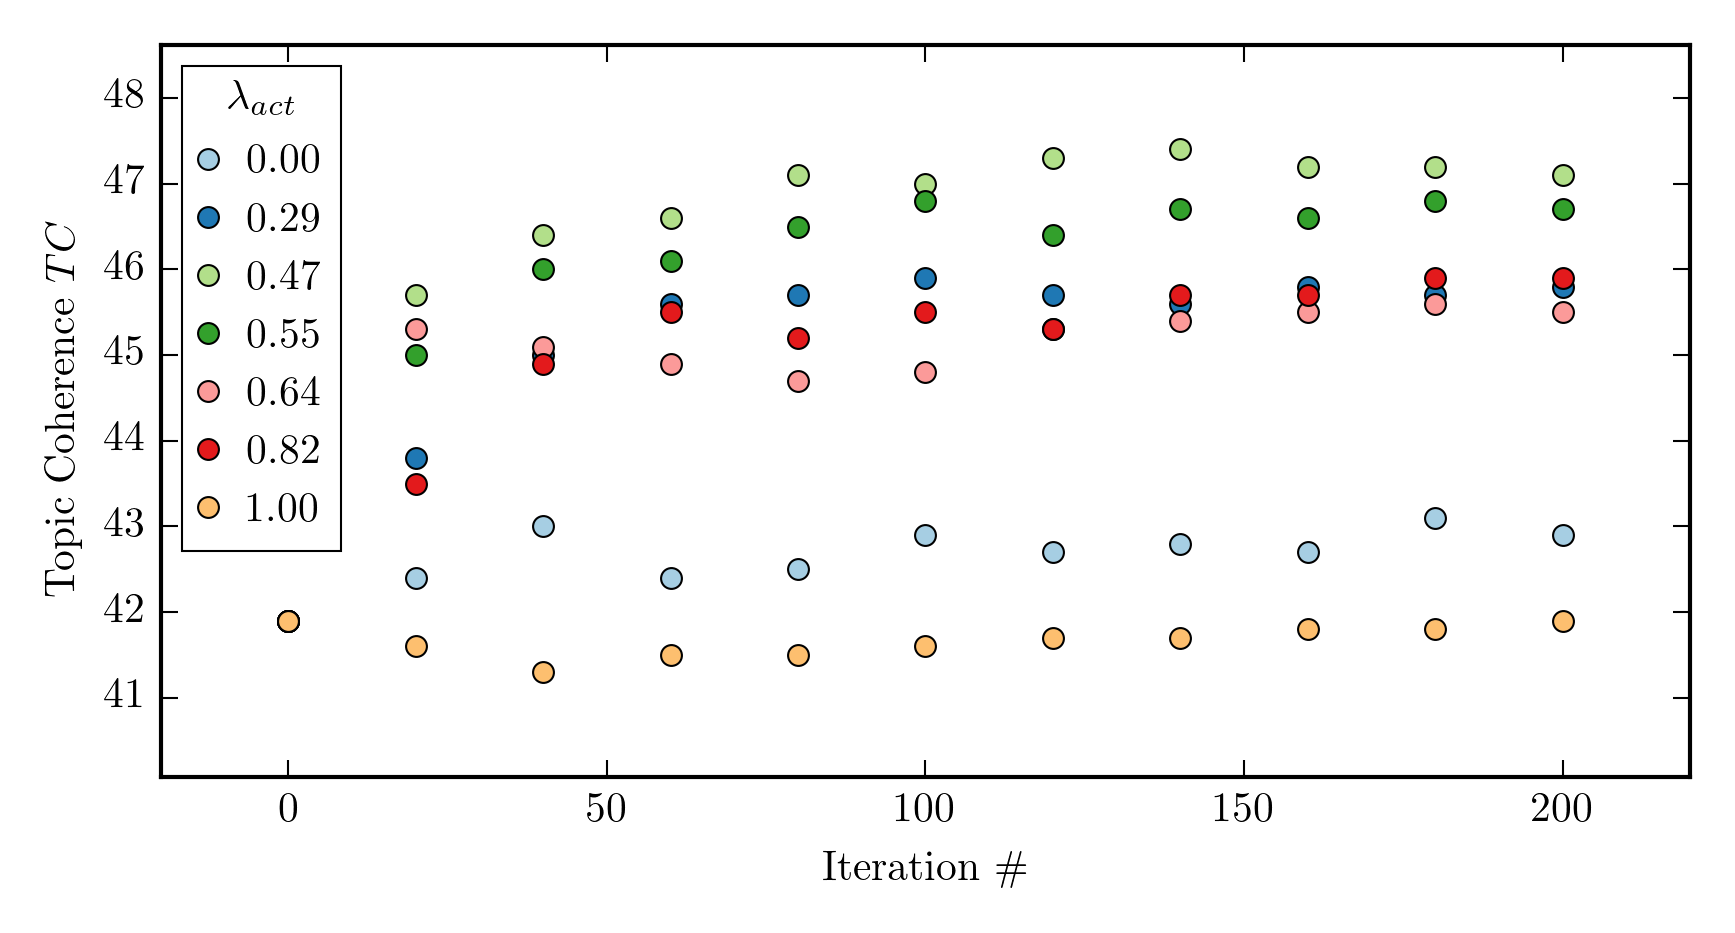

<IPython.core.display.Javascript object>


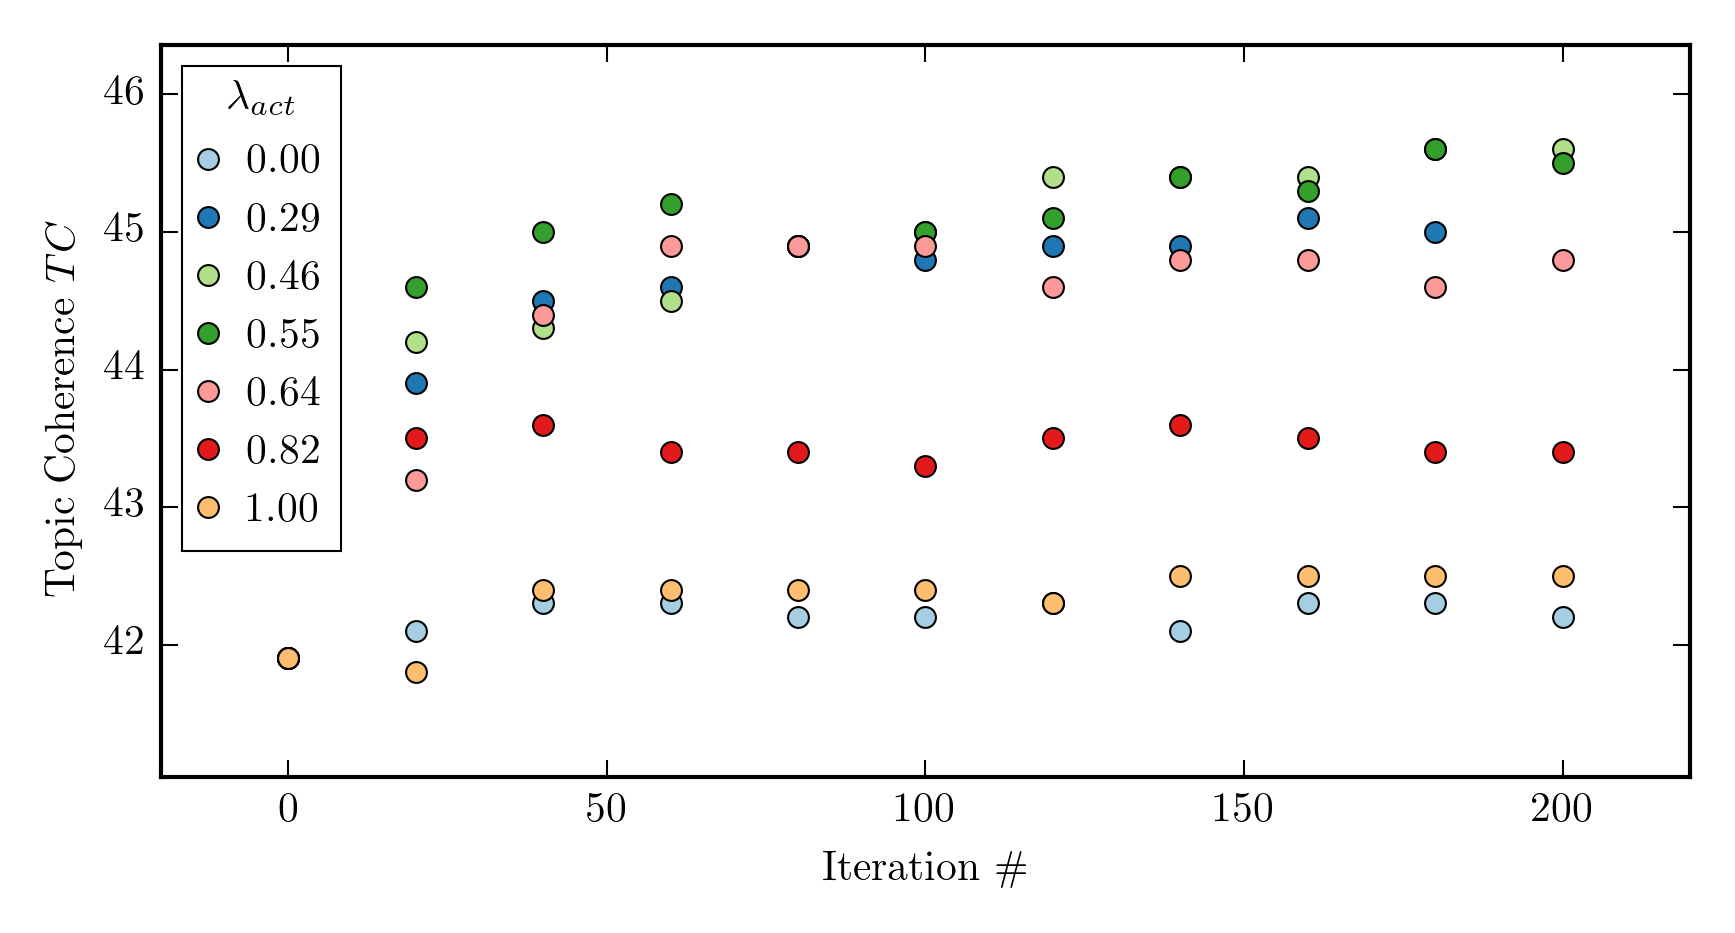

In [171]:
df_tc_welda_gaussian_lambda = load_topic_coherence("welda-gaussian-lambda.txt")
df_tc_welda_gaussian_lambda.columns = ["embedding-dimensions","topic0", "pca", "samples", "lambda", "actual_lambda", "iteration", "TC", "TC_std"]

df_tc_welda_gaussian_lambda = df_tc_welda_gaussian_lambda[df_tc_welda_gaussian_lambda["lambda"].apply(lambda x: x * 10 in [0, 2, 4, 5, 6, 8, 10])]
def merge_runs(df_param):
    tcs = df_param["TC"]
    tcs = sorted(tcs)
    #tc = 
    df_return = df_param.iloc[0]
    #df_return["TC"] = tc
    return df_return

df_tc_welda_gaussian_lambda = df_tc_welda_gaussian_lambda.groupby(["embedding-dimensions", "lambda", "iteration"]).apply(merge_runs).reset_index(drop=True)
#df_tc_welda_gaussian_lambda

plot_iteration_for(df_tc_welda_gaussian_lambda[df_tc_welda_gaussian_lambda["embedding-dimensions"] == "20news-50"],
                   ["actual_lambda"], r=0.2)
plot_iteration_for(df_tc_welda_gaussian_lambda[df_tc_welda_gaussian_lambda["embedding-dimensions"] == "200"],
                   ["actual_lambda"], r=0.2)

**NIPS**

<IPython.core.display.Javascript object>


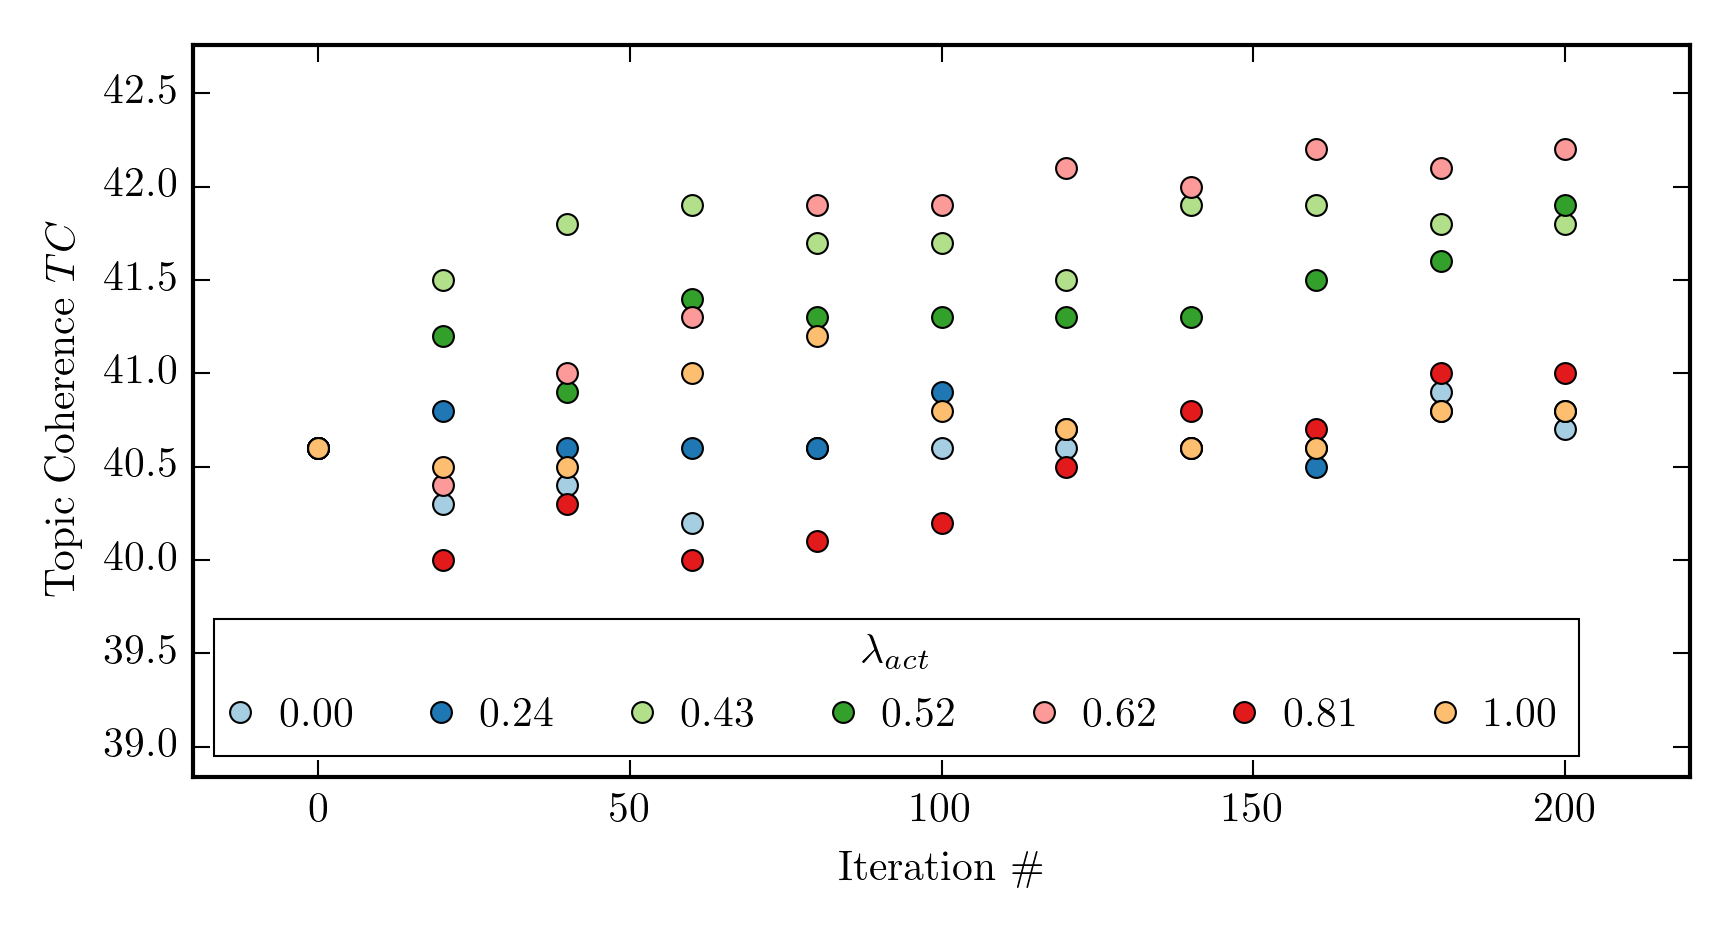

<IPython.core.display.Javascript object>


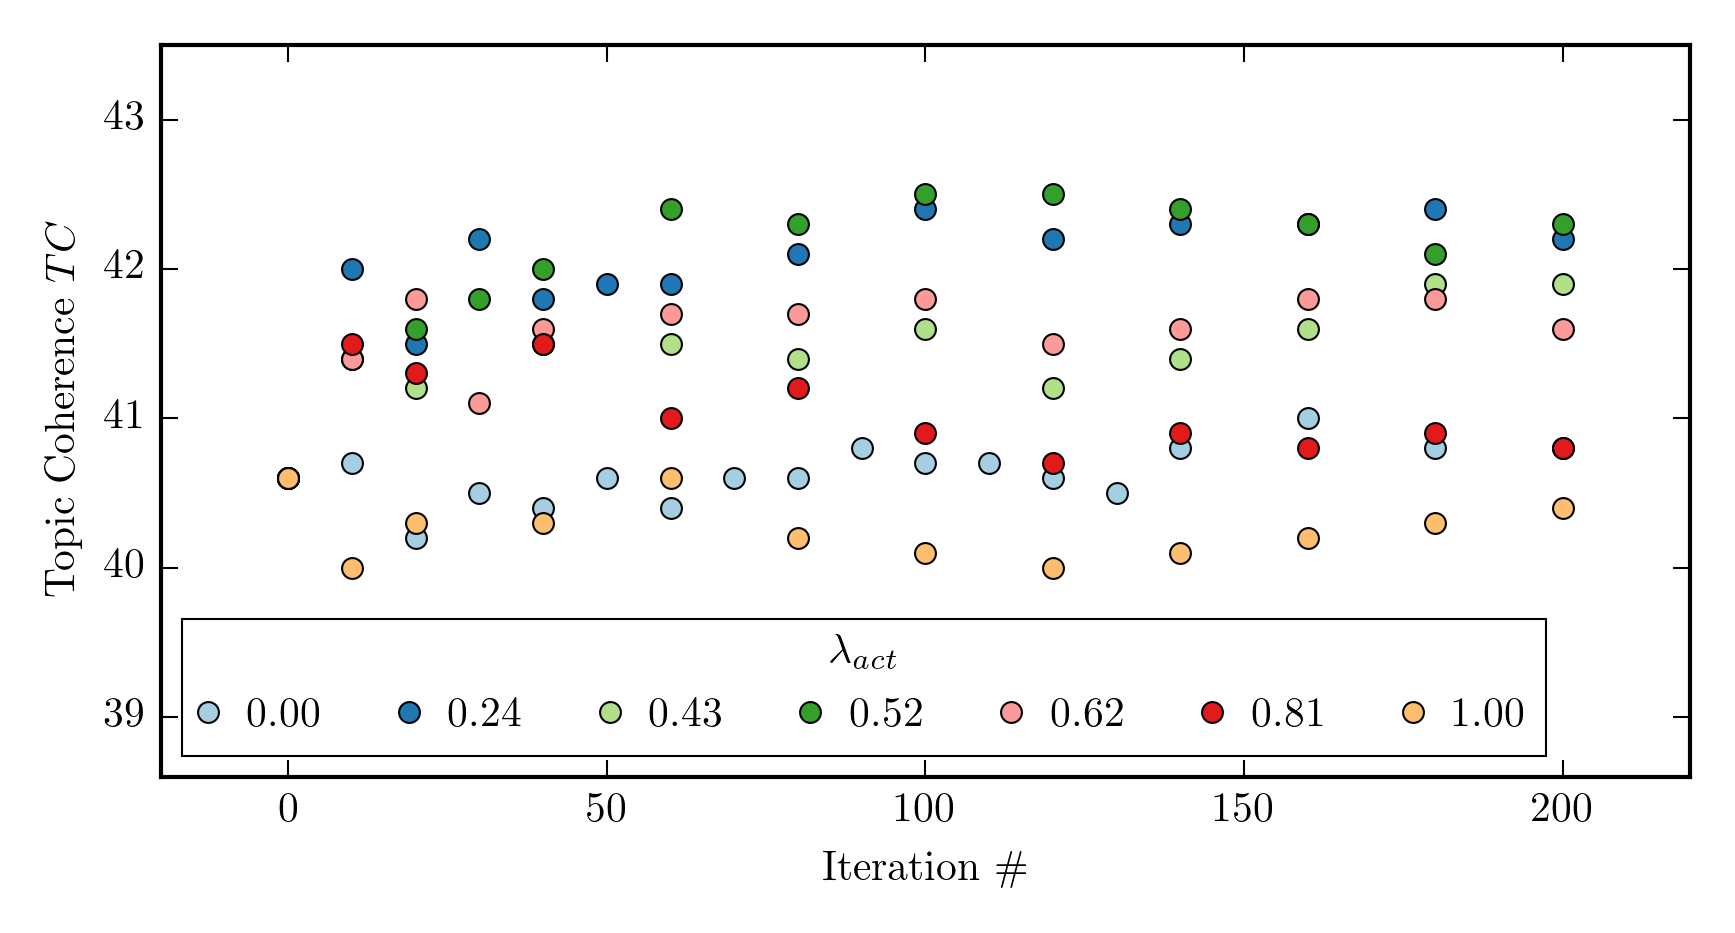

In [108]:
df_tc_welda_gaussian_nips = load_topic_coherence("welda-gaussian-nips.txt")
df_tc_welda_gaussian_nips.columns = ["embedding-dimensions", "topic0", "pca", "samples", "lambda", "actual_lambda", "iteration", "TC", "TC_std"]
plot_iteration_for(df_tc_welda_gaussian_nips[df_tc_welda_gaussian_nips["embedding-dimensions"] == "nips-50"],
                   ["actual_lambda"], r=0.2, param_filter={0.0, 0.24, 0.43, 0.52, 0.62, 0.81, 1.0})
plt.legend(loc="lower left", ncol=7, numpoints=1, borderpad=0.5, handlelength=0.25, title="$\\lambda_{act}$").get_frame().set_linewidth(0.5)

plot_iteration_for(df_tc_welda_gaussian_nips[df_tc_welda_gaussian_nips["embedding-dimensions"] == "200"],
                   ["actual_lambda"], r=0.2, param_filter={0.0, 0.24, 0.43, 0.52, 0.62, 0.81, 1.0})
plt.legend(loc="lower left", ncol=7, numpoints=1, borderpad=0.5, handlelength=0.25, title="$\\lambda_{act}$").get_frame().set_linewidth(0.5)


#### welda-gaussian-background-topic

<IPython.core.display.Javascript object>


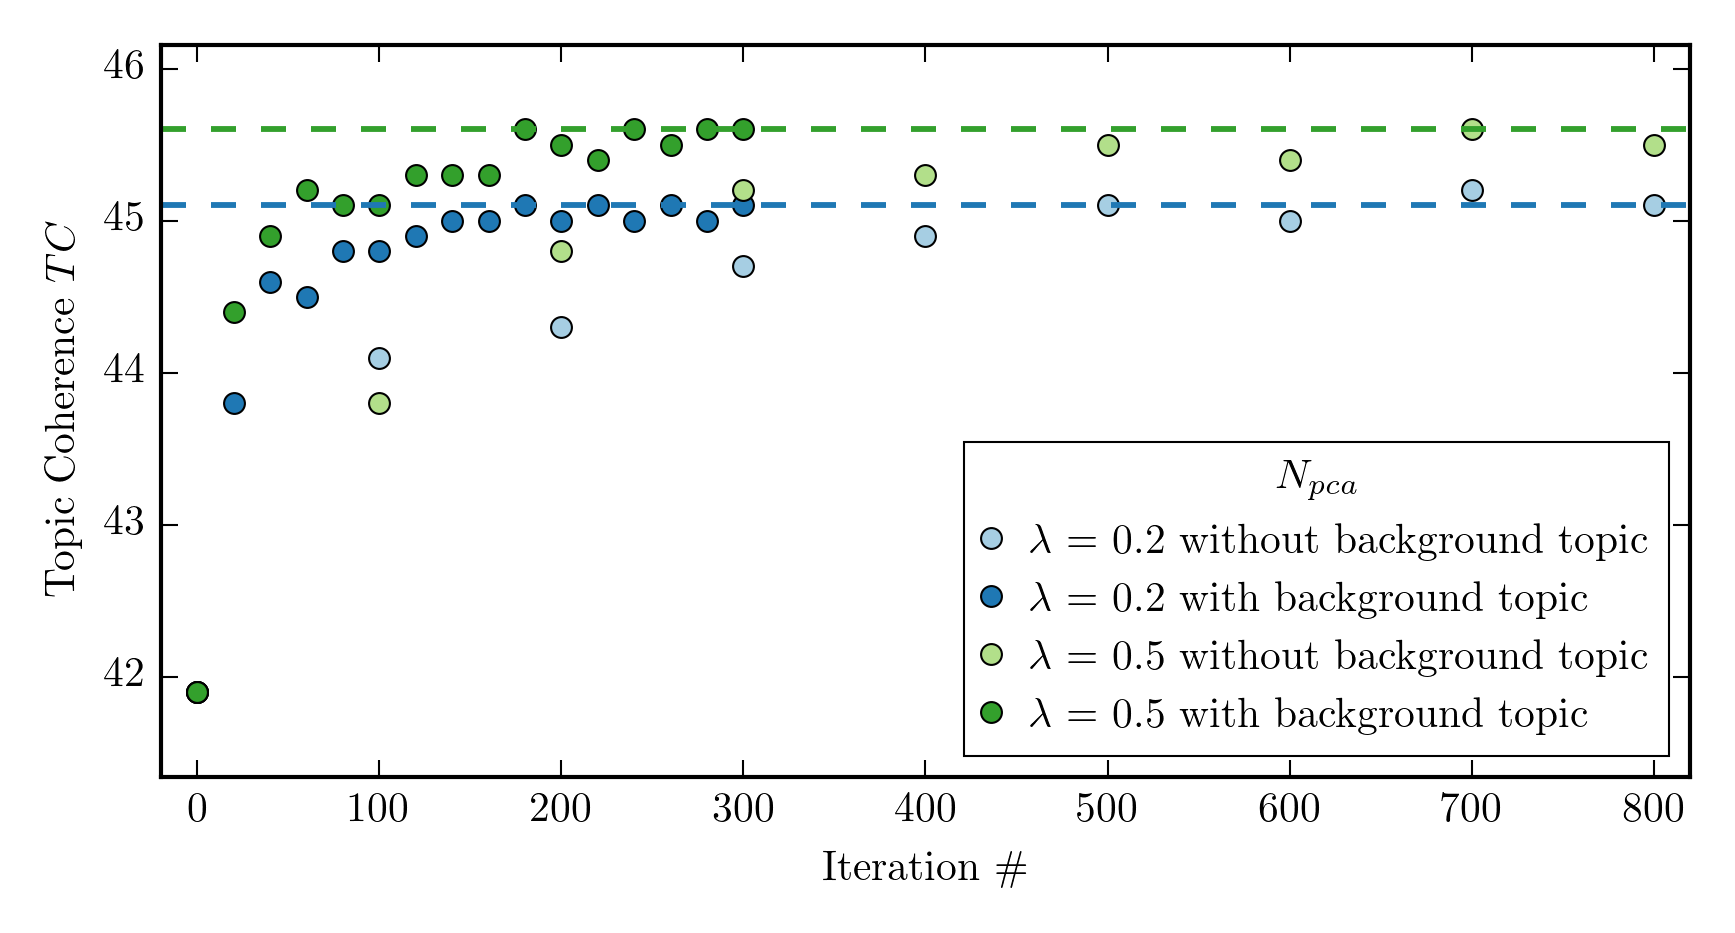

In [132]:
df_tc_welda_background_topic = load_topic_coherence("welda-gaussian-background-topic.txt")
df_tc_welda_background_topic.columns = ["embedding-dimensions", "topic0", "pca", "samples", "lambda", "actual_lambda", "iteration", "TC", "TC_std"]
df_tc_welda_background_topic["background"] = "no-background"

df_welda_background = load_topic_coherence("welda-gaussian-lambda-with-background.txt")
df_welda_background.columns = ["embedding-dimensions","topic0", "pca", "samples", "lambda", "actual_lambda", "iteration", "TC", "TC_std"]
df_welda_background["background"] = "background"

df_tc_welda_background_topic_comparison = pnd.concat([df_tc_welda_background_topic, df_welda_background])
plot_iteration_for(df_tc_welda_background_topic_comparison[df_tc_welda_background_topic_comparison["embedding-dimensions"] == 200],
                   ["actual_lambda", "background"], r=0.15)
#leg = plt.legend(bbox_to_anchor=(1., 0.34))
leg = plt.legend(loc="lower right", ncol=1, numpoints=1, borderpad=0.5, handlelength=0.25, title="$N_{pca}$")

plt.tight_layout()

plt.axhline(y=45.1, linewidth=1.4, color=DARK_COLORS[0], ls='dashed')
plt.axhline(y=45.6, linewidth=1.4, color=DARK_COLORS[1], ls='dashed')
leg.get_frame().set_linewidth(0.5)
leg.get_texts()[0].set_text('$\\lambda$ = 0.2 without background topic')
leg.get_texts()[1].set_text('$\\lambda$ = 0.2 with background topic')
leg.get_texts()[2].set_text('$\\lambda$ = 0.5 without background topic')
leg.get_texts()[3].set_text('$\\lambda$ = 0.5 with background topic')

#### welda-gaussian-pca-samples.txt

In [62]:
#df_tc_welda_gaussian_pca_samples = load_topic_coherence("palmetto_welda-gaussian-lambda-more-runs.log")
#df_tc_welda_gaussian_pca_samples.columns = ["file", "embeddings", "run", "topic0", "pca", "samples", "lambda_v", "actual_lambda", "iteration", "TC", "TC_std"]
#del df_tc_welda_gaussian_pca_samples["file"]

#def merge_runs(df_param):
#    tcs = df_param["TC"]
#    tcs = sorted(tcs)
#    #tc = 
#    df_return = df_param.iloc[0]
#    #df_return["TC"] = tc
#    return df_return

#df_tc_welda_gaussian_pca_samples = df_tc_welda_gaussian_pca_samples.query("(lambda_v == 0.5) & (embeddings == '200')")
#df_tc_welda_gaussian_pca_samples = df_tc_welda_gaussian_pca_samples.groupby(["embeddings", "lambda_v", "iteration"]).apply(merge_runs).reset_index(drop=True)
#df_tc_welda_gaussian_pca_samples.query("embeddings == '200'")

<IPython.core.display.Javascript object>


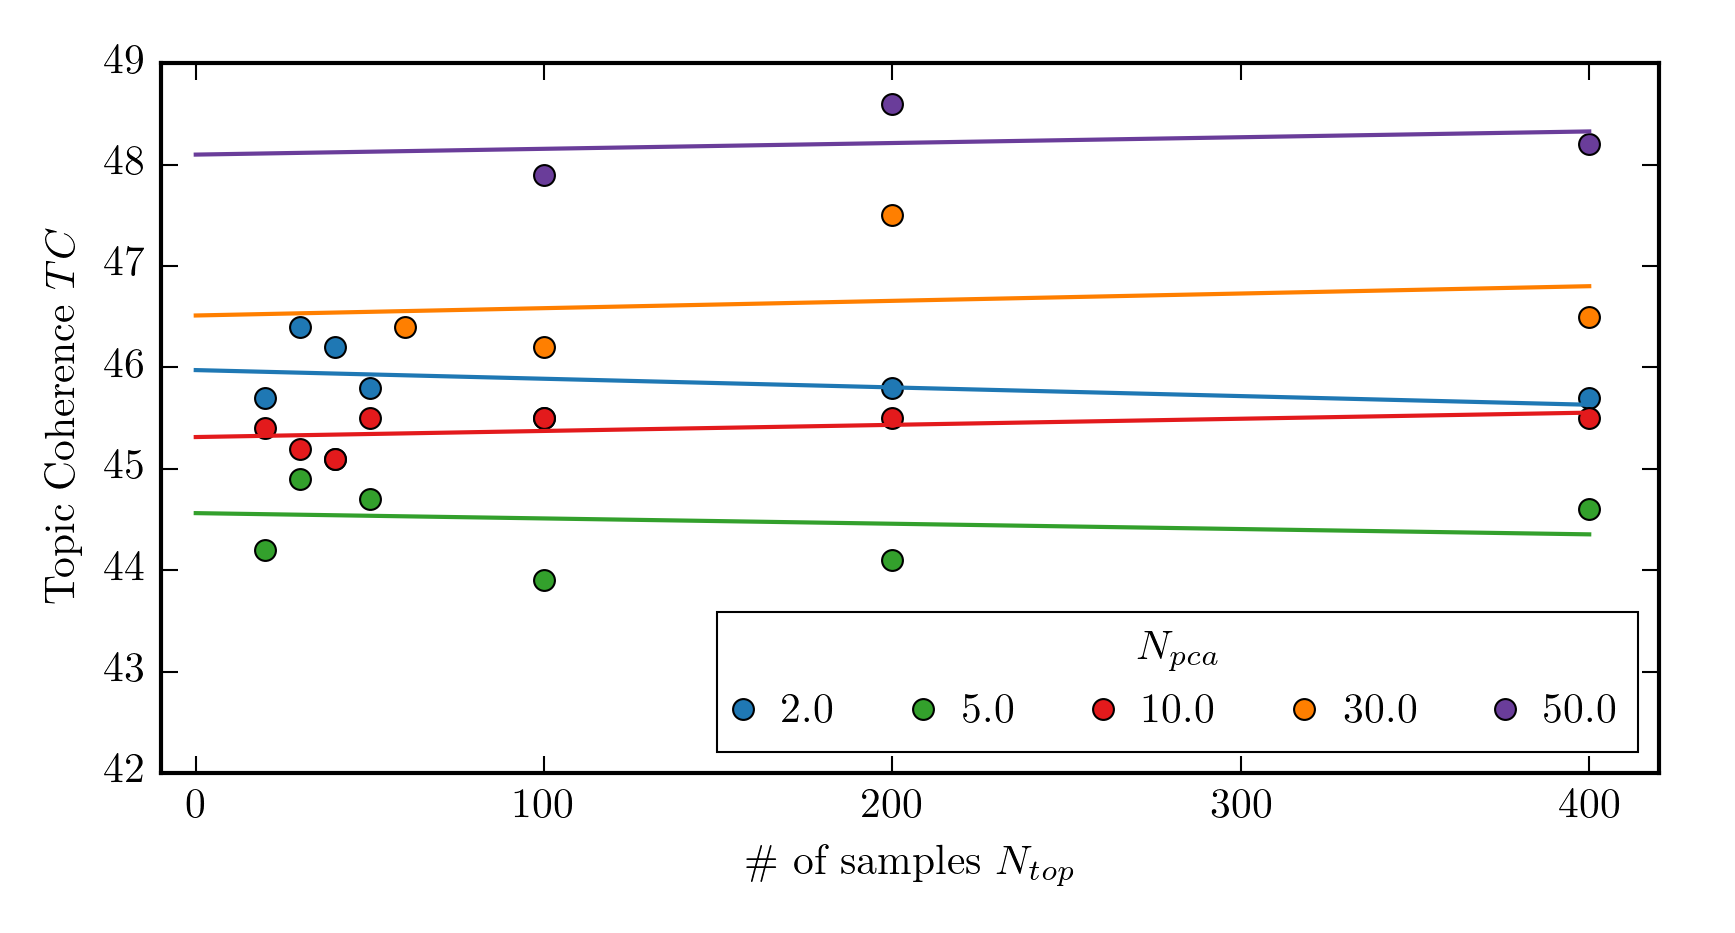

2 -0.375523
-0.342059336824
5 -0.163162
-0.20942408377
10 0.496438
0.240837696335
30 0.189128
0.28901734104
50 0.248548
0.228571428571
20.0
-0.397188325974
30.0
-0.764968621023
40.0
-0.872910967672
50.0
-0.549303317407
60.0
nan
100.0
0.855742699126
200.0
0.91184618593
400.0
0.905332664328


(42.0, 49)

In [241]:
df_tc_welda_gaussian_pca_samples = load_topic_coherence("welda-gaussian-pca-samples-short.log")
df_tc_welda_gaussian_pca_samples.columns = ["embedding-dimensions", "topic0", "pca", "samples", "lambda", "actual_lambda", "iteration", "TC", "TC_std"]
del df_tc_welda_gaussian_pca_samples["topic0"]
del df_tc_welda_gaussian_pca_samples["embedding-dimensions"]

def print_pca_correlation(df_param):
    for samples, df_group in df_param[df_param.iteration == 200].groupby(["samples"]):
        print samples
        print df_group["pca"].corr(df_group["TC"])

def plot_pca_samples(df_param):
    colors = iter(DARK_COLORS)
    plt.figure(figsize=cm2inch(14.69, 7.9), dpi=300)
    for pca, df_group in df_param.groupby("pca"):
        df_tmp = df_group.groupby("samples")["TC"].max().to_frame()
        df_tmp["samples"] = df_tmp.index
        print "%d %f" % (pca, df_tmp["samples"].corr(df_tmp["TC"], "pearson"))
        #print df_tmp
        c = next(colors)
        plt.plot(df_tmp.index, df_tmp["TC"] * 100, linestyle="None", color='white',
                     label="%s" % str(pca), marker='o', markerfacecolor=c, markersize=5)
        
        m, b = np.polyfit(df_tmp.index, df_tmp["TC"] * 100, 1)
        print m * 400
        plt.plot([0, 400], m*pnd.Series([0, 400]) + b, '-', color=c, label='_nolegend_')


    plt.xlabel("\\# of samples $N_{top}$")
    plt.ylabel("Topic Coherence $TC$")
    #plt.legend(loc="lower right", numpoints=1)
    plt.legend(loc="lower right", ncol=5, numpoints=1, borderpad=0.5, handlelength=0.25, title="$N_{pca}$").get_frame().set_linewidth(0.5)
    plt.tight_layout()


plot_pca_samples(df_tc_welda_gaussian_pca_samples[df_tc_welda_gaussian_pca_samples["lambda"] == 0.5])
print_pca_correlation(df_tc_welda_gaussian_pca_samples[df_tc_welda_gaussian_pca_samples["lambda"] == 0.5])
plt.xlim((-10, 420))
plt.ylim((42.0, 49))

#### welda-gaussian-nips-pca-samples

<IPython.core.display.Javascript object>


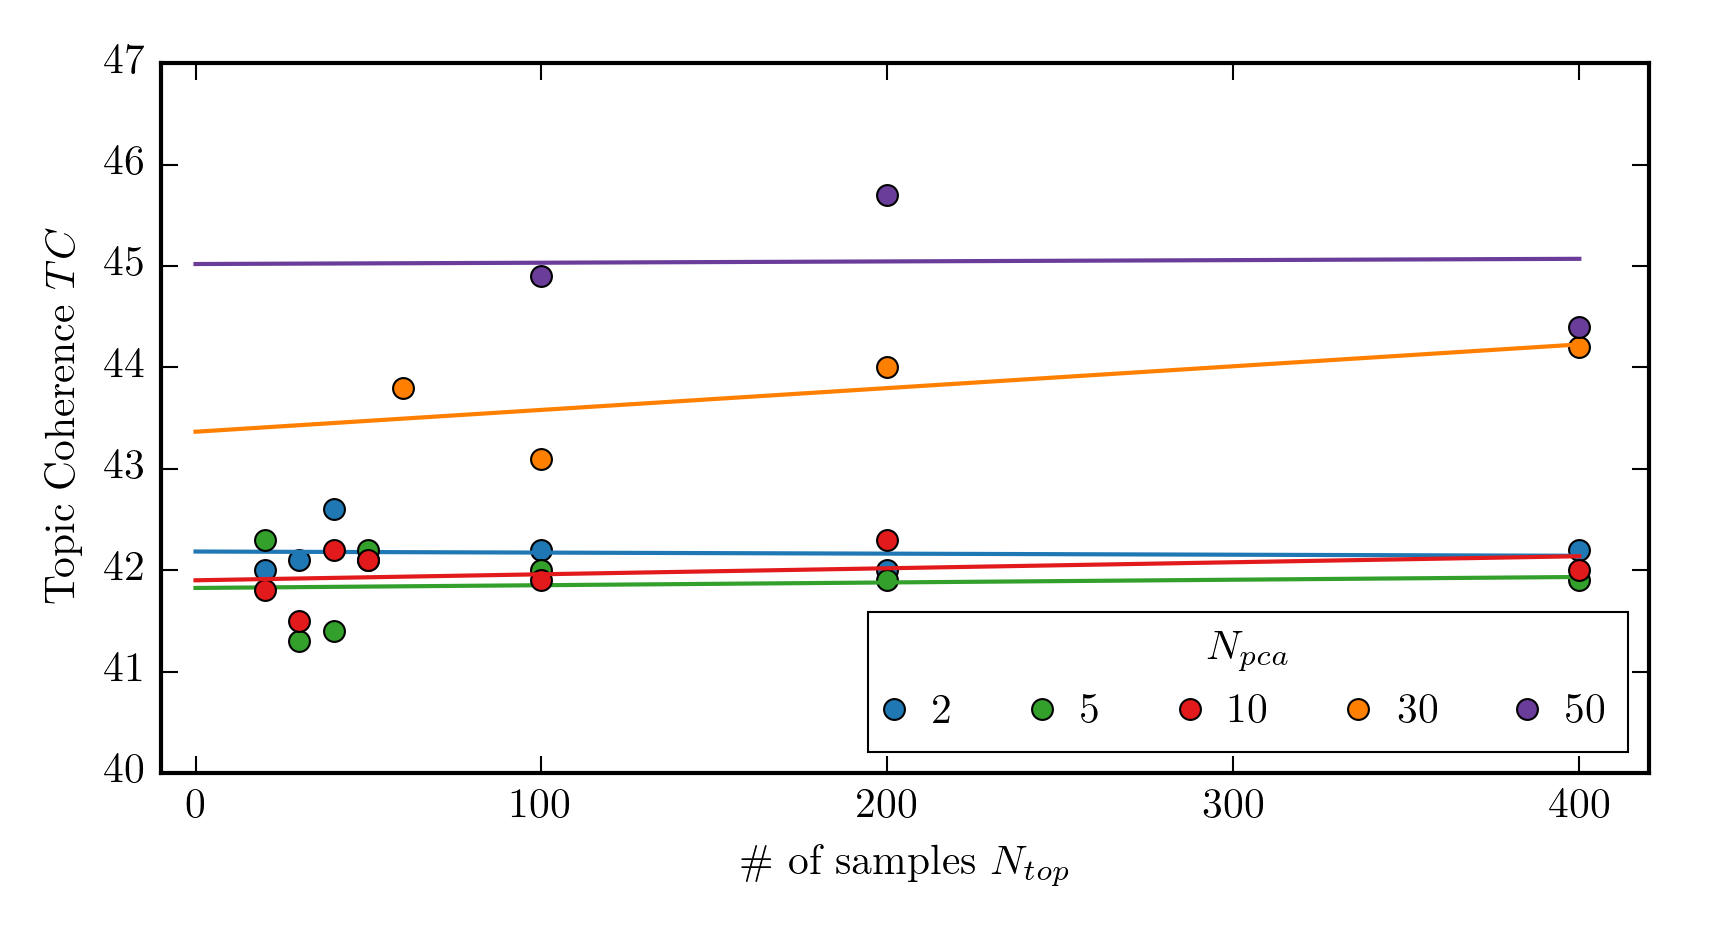

2 -0.070296
-0.0418848167539
5 0.098911
0.108202443281
10 0.304810
0.237347294939
30 0.683120
0.861271676301
50 0.092947
0.051282051282
20
-0.928571428571
30
-0.614132360107
40
-0.0467609764791
50
-0.142857142857
60
nan
100
0.961144264639
200
0.990223725255
400
0.934877699423
1000
nan


(40.0, 47.0)

In [243]:
df_tc_welda_gaussian_nips_pca_samples = load_topic_coherence("welda-gaussian-nips-pca-samples.log")
df_tc_welda_gaussian_nips_pca_samples.columns = ["embedding-dimensions", "topic0", "pca", "samples", "lambda", "actual_lambda", "iteration", "TC", "TC_std"]
del df_tc_welda_gaussian_nips_pca_samples["topic0"]
del df_tc_welda_gaussian_nips_pca_samples["embedding-dimensions"]

plot_pca_samples(df_tc_welda_gaussian_nips_pca_samples[df_tc_welda_gaussian_nips_pca_samples["lambda"] == 0.5])
print_pca_correlation(df_tc_welda_gaussian_nips_pca_samples[df_tc_welda_gaussian_nips_pca_samples["lambda"] == 0.5])

plt.xlim((-10, 420))
plt.ylim((40.0, 47.0))

#### welda-gaussian-random-init

<IPython.core.display.Javascript object>


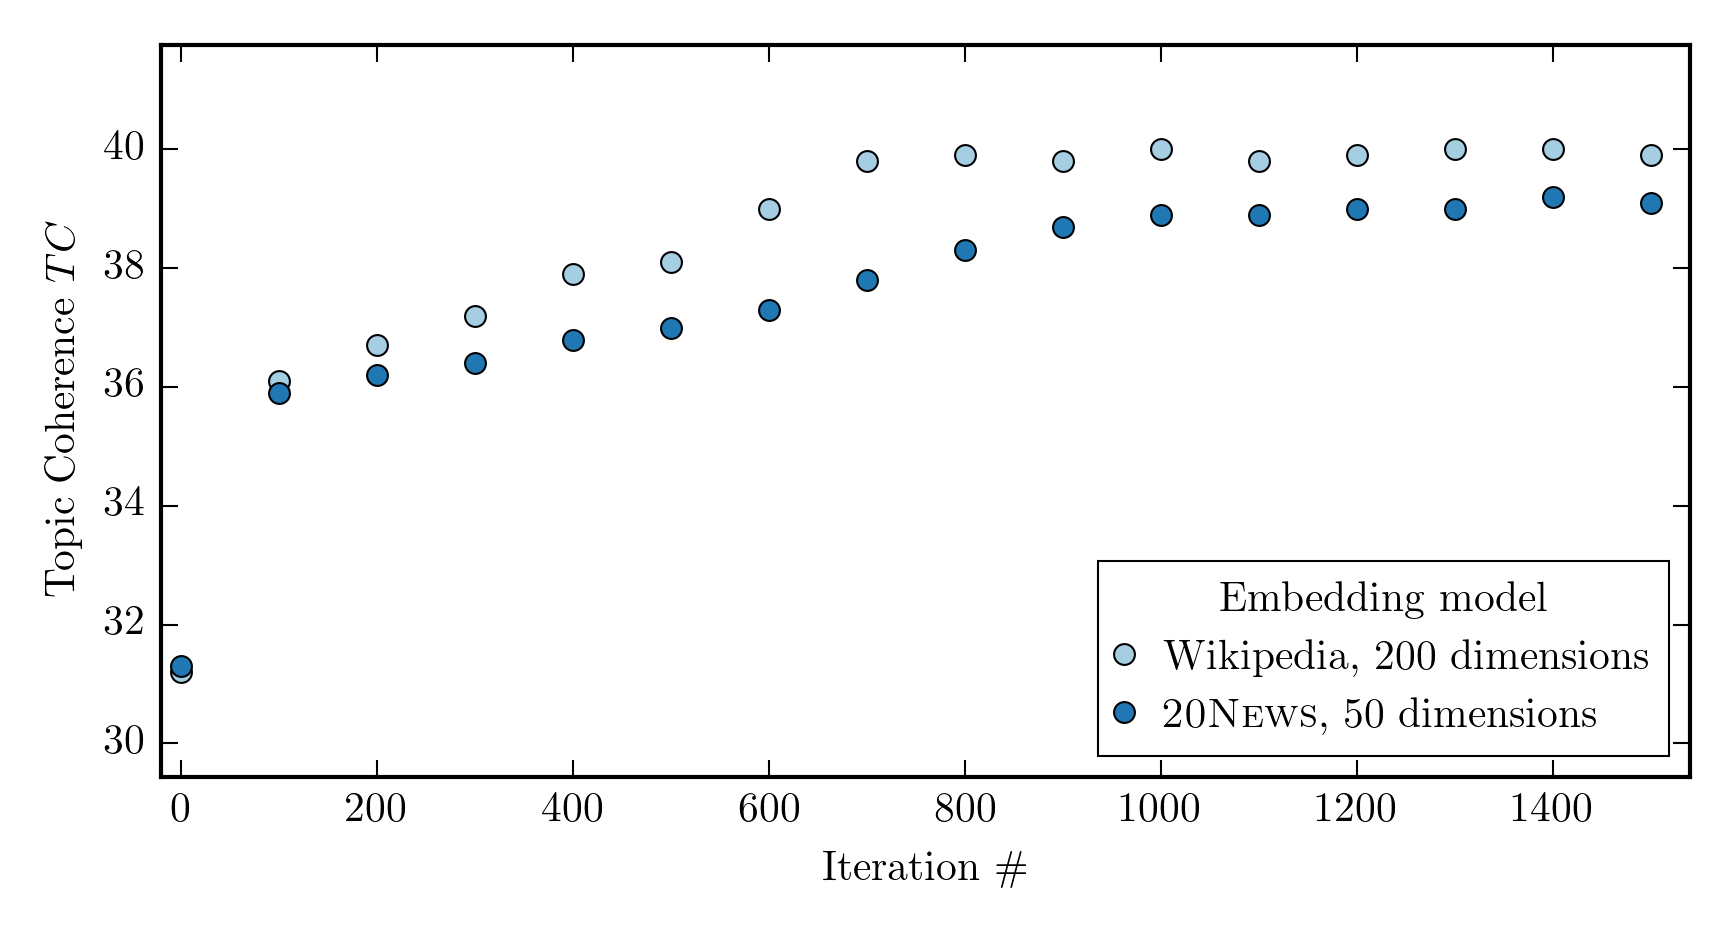

In [37]:
df_tc_welda_gaussian_random_init = load_topic_coherence("welda-gaussian-random-init.log")
df_tc_welda_gaussian_random_init.columns = ["embedding-dimensions","topic0", "pca", "samples", "lambda", "actual_lambda", "iteration", "TC", "TC_std"]

plot_iteration_for(df_tc_welda_gaussian_random_init,
                   ["embedding-dimensions"], r=0.2)
plt.xlim((-20, 1540))
leg = plt.legend(loc="lower right", numpoints=1, borderpad=0.5, handlelength=0.25, title="Embedding model")
leg.get_frame().set_linewidth(0.5)
leg.get_texts()[0].set_text('Wikipedia, 200 dimensions')
leg.get_texts()[1].set_text('\\textsc{20News}, 50 dimensions')
#plt.legend(loc="lower right")

#### welda-gaussian-random-fluctuations

In [77]:
fluctuations_corpus_specific_embeddings = pnd.Series([0.455, 0.452, 0.450, 0.445, 0.450, 0.448, 0.449, 0.453, 0.450, 0.450])
fluctuations_corpus_specific_embeddings *= 100
print fluctuations_corpus_specific_embeddings.mean()
print fluctuations_corpus_specific_embeddings.std()

fluctuations_wiki_embeddings = pnd.Series([0.448, 0.450, 0.449, 0.451, 0.453, 0.445, 0.450, 0.451, 0.448, 0.449])
fluctuations_wiki_embeddings *= 100
print fluctuations_wiki_embeddings.mean()
print fluctuations_wiki_embeddings.std()

45.02
0.274064063881
44.94
0.217050941281


### WELDA-vMF

#### Old

<IPython.core.display.Javascript object>


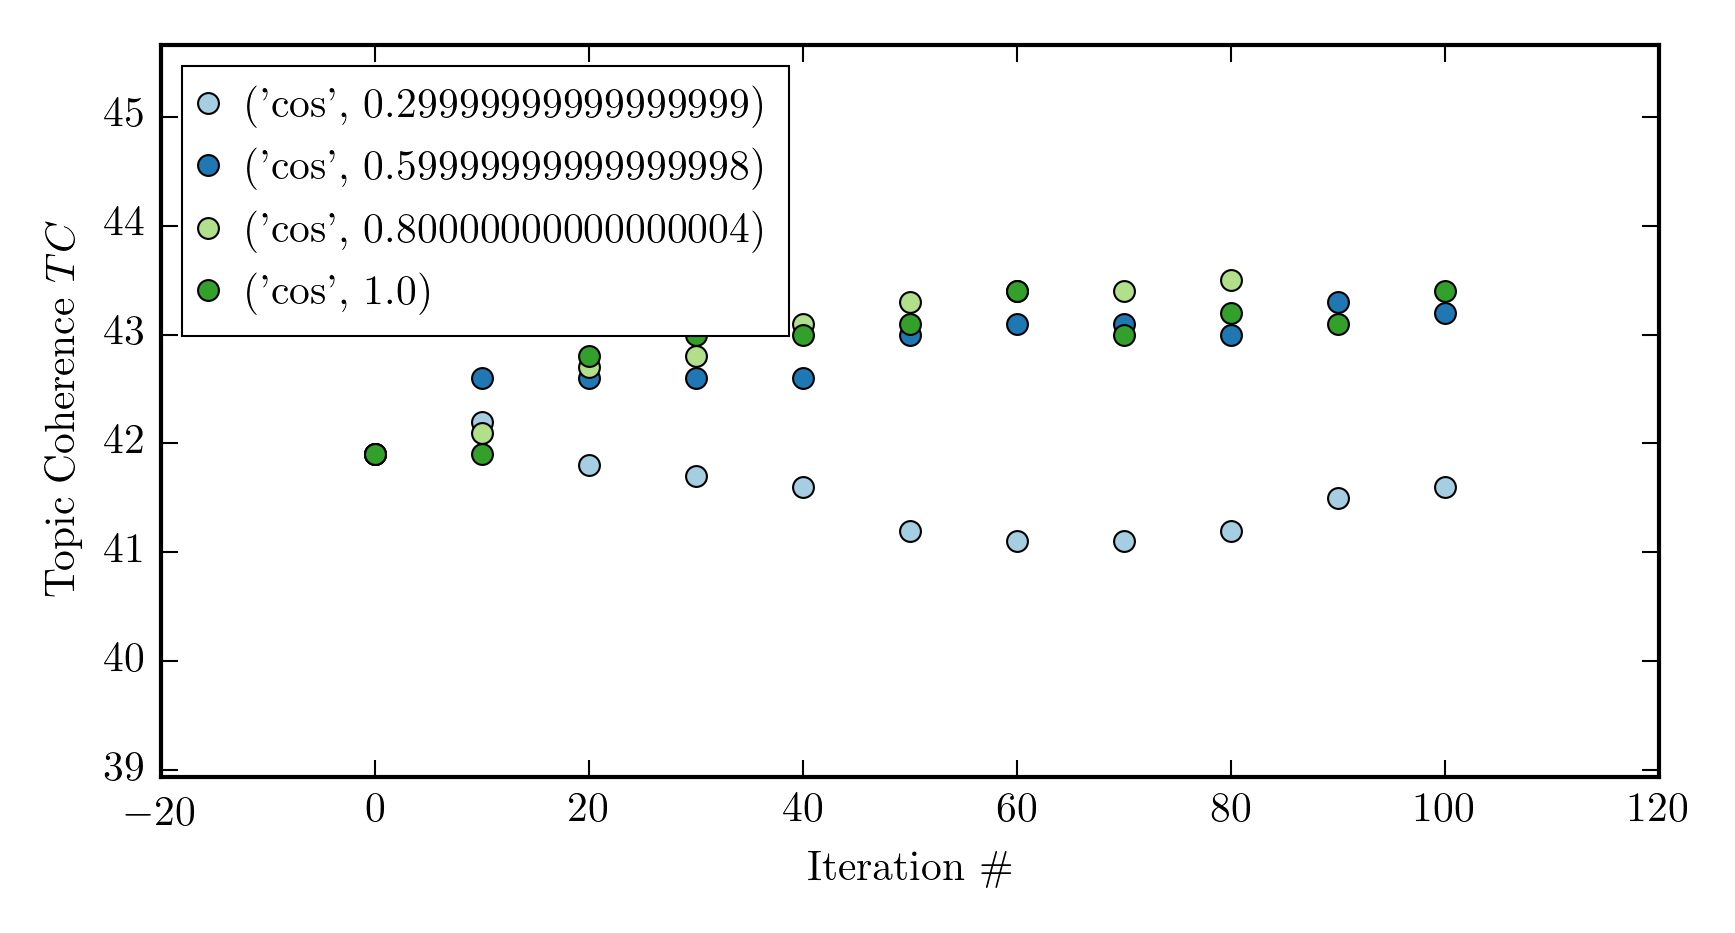

In [135]:
df_tc_welda_vmf_20news = load_topic_coherence("vmf_welda.embedding-20news-dim-50.txt")
df_tc_welda_vmf_20news.columns = ["embedding-dimension", "distance-method", "lambda", "iteration", "TC", "TC_std"]
df_tc_welda_vmf_20news = df_tc_welda_vmf_20news.sort_values(["distance-method", "lambda", "iteration"])
plot_iteration_for(df_tc_welda_vmf_20news, ["distance-method", "lambda"])

<IPython.core.display.Javascript object>


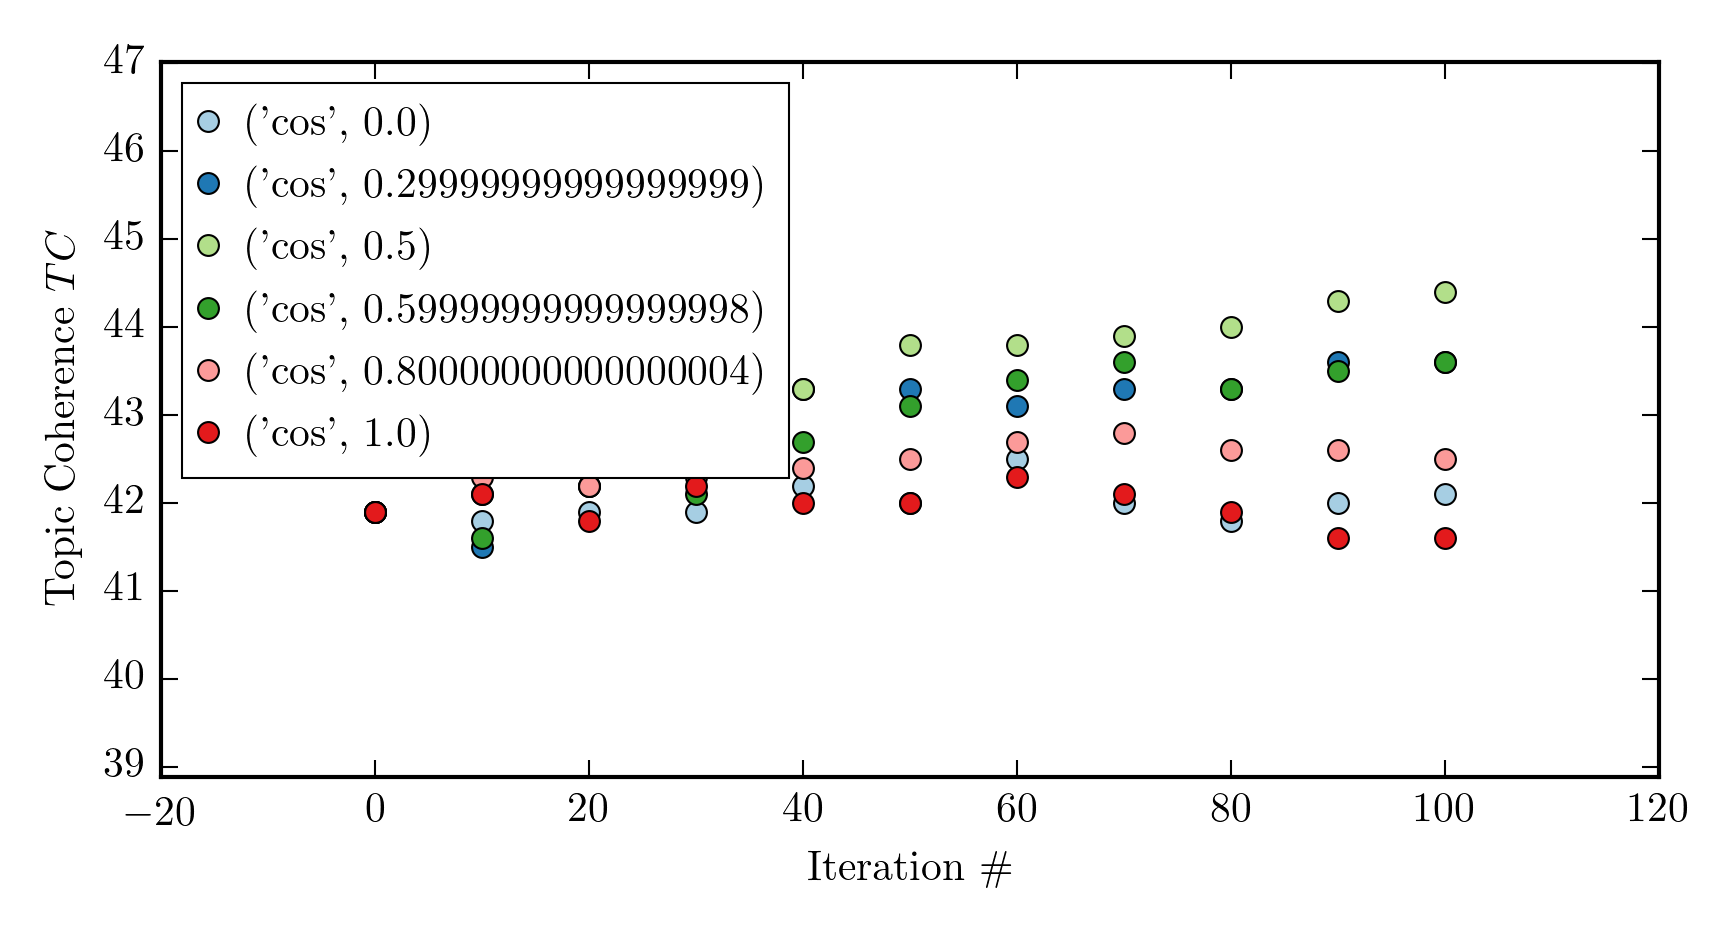

In [136]:
df_tc_welda_vmf = load_topic_coherence("vmf_welda.conc-20.txt")
df_tc_welda_vmf.columns = ["embedding-dimension", "distance-method", "concentration", "lambda", "iteration", "TC", "TC_std"]
del df_tc_welda_vmf["concentration"]
df_tc_welda_vmf = df_tc_welda_vmf.sort_values(["distance-method", "lambda", "iteration"])
plot_iteration_for(df_tc_welda_vmf, ["distance-method", "lambda"])

#### conc-50

<IPython.core.display.Javascript object>


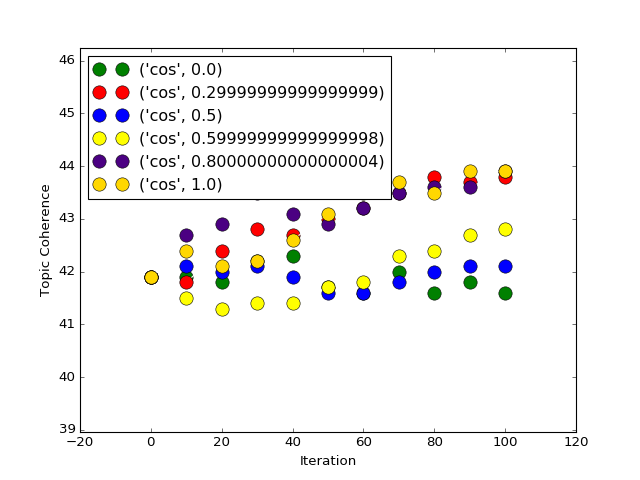

In [33]:
df_tc_welda_vmf_conc50 = load_topic_coherence("vmf_welda.conc-50.txt")
df_tc_welda_vmf_conc50.columns = ["embedding-dimension", "distance-method", "concentration", "lambda", "iteration", "TC", "TC_std"]
del df_tc_welda_vmf_conc50["concentration"]
df_tc_welda_vmf_conc50 = df_tc_welda_vmf_conc50.sort_values(["distance-method", "lambda", "iteration"])
plot_iteration_for(df_tc_welda_vmf_conc50, ["distance-method", "lambda"])

**Full kappafactor investigation**

In [294]:
df_tc_welda_vmf_kappa = load_topic_coherence("vmf_welda.conc-experiments.txt")
df_tc_welda_vmf_kappa.columns = ["embedding-dimension", "distance-method", "concentration", "lambda", "iteration", "TC", "TC_std"]
df_tc_welda_vmf_kappa = df_tc_welda_vmf_kappa.sort_values(["distance-method", "lambda", "iteration"])

**TODO: BETTER PLOTS**

<IPython.core.display.Javascript object>


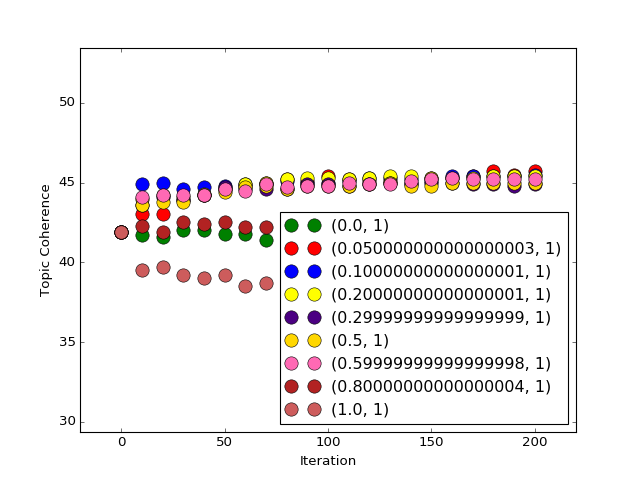

In [309]:
plot_iteration_for(
    df_tc_welda_vmf_kappa[(df_tc_welda_vmf_kappa["embedding-dimension"] == "200") &
                          (df_tc_welda_vmf_kappa["lambda"].apply(lambda x: x in [0.0, 0.1, 0.5, 1.0]))],
    ["concentration", "lambda"])

#### welda-vmf

In [175]:
df_tc_welda_vmf_lambda

embedding-dimensions topic-distribution topic0  pca  samples  lambda  \
0                    200                vmf     no   10       20     0.2   
1                    200                vmf     no   10       20     0.2   
2                    200                vmf     no   10       20     0.2   
3                    200                vmf     no   10       20     0.2   
4                    200                vmf     no   10       20     0.2   
5                    200                vmf     no   10       20     0.2   
6                    200                vmf     no   10       20     0.2   
7                    200                vmf     no   10       20     0.2   
8                    200                vmf     no   10       20     0.2   
9                    200                vmf     no   10       20     0.2   
10                   200                vmf     no   10       20     0.2   
11                   200                vmf     no   10       20     0.4   
12                   200                vmf     no   10       20     0.4   
13                   200                vmf     no   10       20     0.4   
14                   200                vmf     no   10       20     0.4   
15                   200                vmf     no   10       20     0.4   
16                   200                vmf     no   10       20     0.4   
17                   200                vmf     no   10       20     0.4   
18                   200                vmf     no   10       20     0.4   
19                   200                vmf     no   10       20     0.4   
20                   200                vmf     no   10       20     0.4   
21                   200                vmf     no   10       20     0.4   
22                   200                vmf     no   10       20     0.5   
23                   200                vmf     no   10       20     0.5   
24                   200                vmf     no   10       20     0.5   
25                   200                vmf     no   10       20     0.5   
26                   200                vmf     no   10       20     0.5   
27                   200                vmf     no   10       20     0.5   
28                   200                vmf     no   10       20     0.5   
29                   200                vmf     no   10       20     0.5   
..                   ...                ...    ...  ...      ...     ...   
80             20news-50                vmf     no   10       20     0.5   
81             20news-50                vmf     no   10       20     0.5   
82             20news-50                vmf     no   10       20     0.5   
83             20news-50                vmf     no   10       20     0.5   
84             20news-50                vmf     no   10       20     0.5   
85             20news-50                vmf     no   10       20     0.5   
86             20news-50                vmf     no   10       20     0.5   
87             20news-50                vmf     no   10       20     0.5   
88             20news-50                vmf     no   10       20     0.6   
89             20news-50                vmf     no   10       20     0.6   
90             20news-50                vmf     no   10       20     0.6   
91             20news-50                vmf     no   10       20     0.6   
92             20news-50                vmf     no   10       20     0.6   
93             20news-50                vmf     no   10       20     0.6   
94             20news-50                vmf     no   10       20     0.6   
95             20news-50                vmf     no   10       20     0.6   
96             20news-50                vmf     no   10       20     0.6   
97             20news-50                vmf     no   10       20     0.6   
98             20news-50                vmf     no   10       20     0.6   
99             20news-50                vmf     no   10       20     0.8   
100            20news-50                vmf     no  

<IPython.core.display.Javascript object>


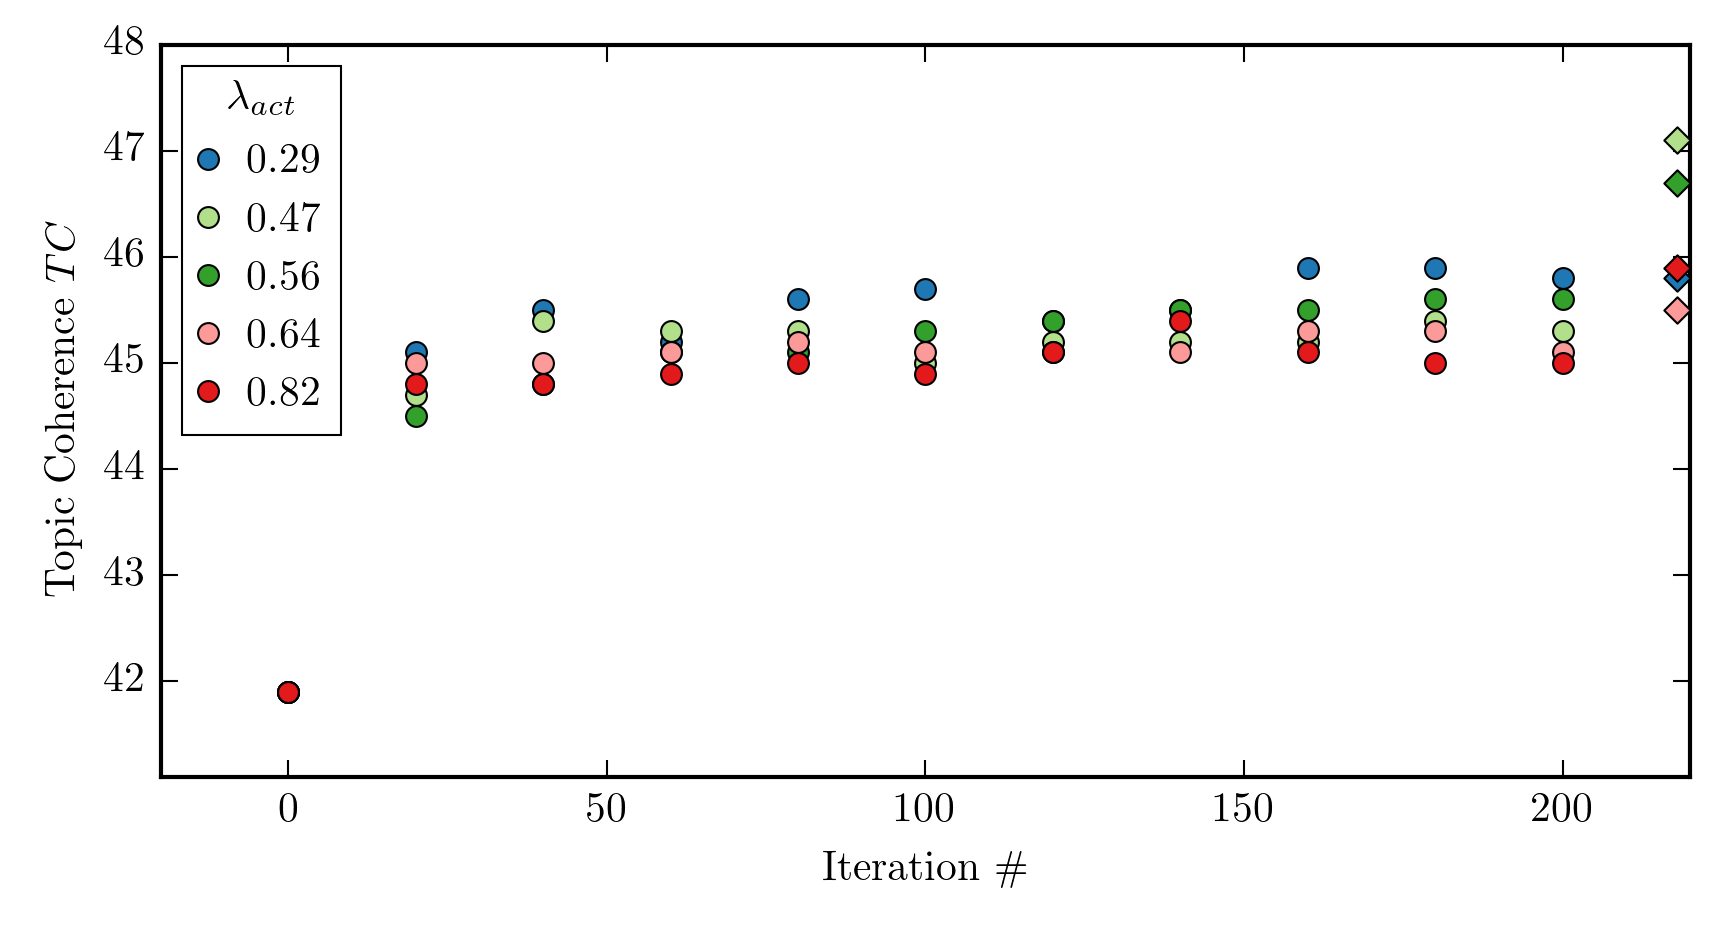

<IPython.core.display.Javascript object>


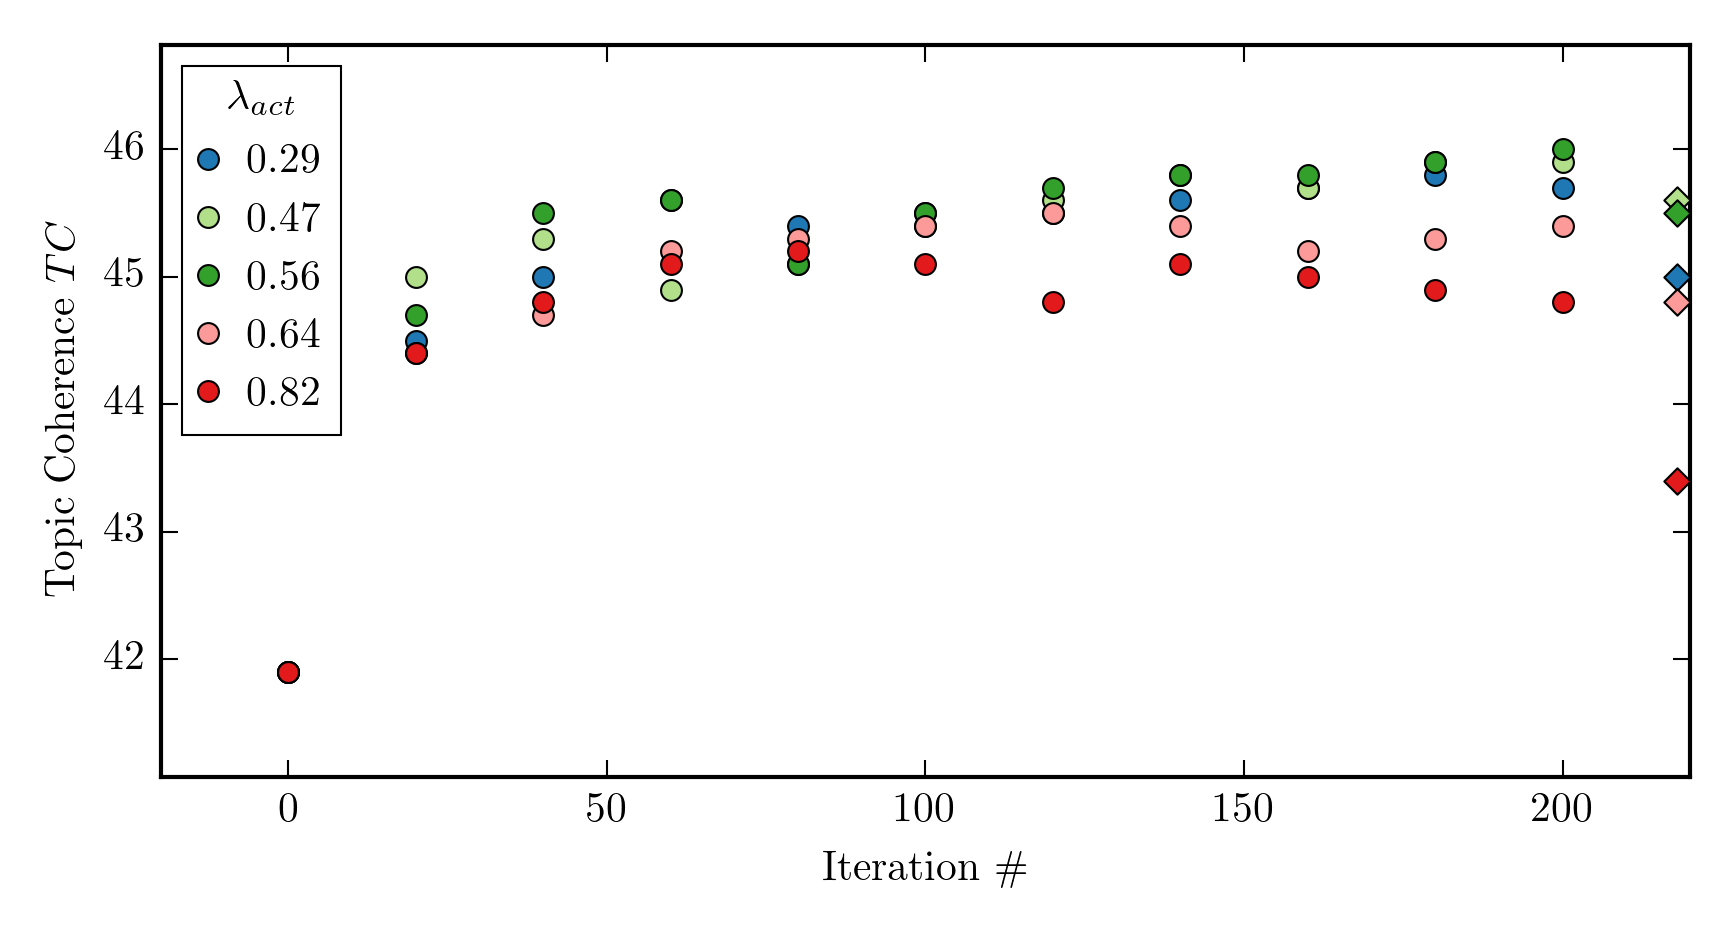

In [184]:
df_tc_welda_vmf_lambda = load_topic_coherence("welda-vmf.log")
df_tc_welda_vmf_lambda.columns = ["embedding-dimensions", "topic-distribution", "topic0", "pca", "samples", "lambda", "kappa-factor", "actual_lambda", "iteration", "TC", "TC_std"]

df_tc_welda_vmf_lambda = df_tc_welda_vmf_lambda[df_tc_welda_vmf_lambda["lambda"].apply(lambda x: x * 10 in [2, 4, 5, 6, 8])]
def merge_runs(df_param):
    tcs = df_param["TC"]
    tcs = sorted(tcs)
    tc = max(tcs)
    df_return = df_param.iloc[0]
    df_return["TC"] = tc
    
    #row = df_param.loc[df_param['TC'].idxmax()]
    #print row["kappa-factor"]
    
    return df_return

df_tc_welda_vmf_lambda = df_tc_welda_vmf_lambda.groupby(["embedding-dimensions", "lambda", "iteration"]).apply(merge_runs).reset_index(drop=True)

plot_iteration_for(df_tc_welda_vmf_lambda[df_tc_welda_vmf_lambda["embedding-dimensions"] == "20news-50"],
                   ["actual_lambda"], r=0.2, colors_offset=1, dpi=300)
plt.ylim((41.1, 48.0))
plt.scatter([218], [45.8], marker="D", s=20, c=COLORS[1], zorder=20, lw=0.5)
plt.scatter([218], [47.1], marker="D", s=20, c=COLORS[2], zorder=20, lw=0.5)
plt.scatter([218], [46.7], marker="D", s=20, c=COLORS[3], zorder=20, lw=0.5)
plt.scatter([218], [45.5], marker="D", s=20, c=COLORS[4], zorder=20, lw=0.5)
plt.scatter([218], [45.9], marker="D", s=20, c=COLORS[5], zorder=20, lw=0.5)
plot_iteration_for(df_tc_welda_vmf_lambda[df_tc_welda_vmf_lambda["embedding-dimensions"] == "200"],
                   ["actual_lambda"], r=0.2, colors_offset=1, dpi=300)
plt.scatter([218], [45.0], marker="D", s=20, c=COLORS[1], zorder=20, lw=0.5)
plt.scatter([218], [45.6], marker="D", s=20, c=COLORS[2], zorder=20, lw=0.5)
plt.scatter([218], [45.5], marker="D", s=20, c=COLORS[3], zorder=20, lw=0.5)
plt.scatter([218], [44.8], marker="D", s=20, c=COLORS[4], zorder=20, lw=0.5)
plt.scatter([218], [43.4], marker="D", s=20, c=COLORS[5], zorder=20, lw=0.5)

## Runtimes

**For 20news corpus:**

In [40]:
df_runtimes = pnd.DataFrame.from_records([
    ("LDA", "iterations=1500, threads=4", "8min"),
    ("LFLDA", "iterations=400, embedding-dimension=200, lambda=0.6, threads=5", "23h 30min"),
    ("Gaussian LDA", "iterations=100, embedding-dimension=50, threads=2", "19h 40min"),
    ("topicvec", "iterations=100, embedding-dimension=100, threads=4", "45min"),
    ("topicvec", "iterations=100, embedding-dimension=200, threads=4", "53min"),
    ("sHDP on NIPS!", "kappa=0.8, tau=0.6", "20 min"),
    ("WELDA", "iterations=100, lambda=0.5, threads=4", "4 h"),
], columns=["method", "notes", "runtime"])
df_runtimes

method  \
0            LDA   
1          LFLDA   
2   Gaussian LDA   
3       topicvec   
4       topicvec   
5  sHDP on NIPS!   
6          WELDA   

                                                            notes    runtime  
0                                      iterations=1500, threads=4       8min  
1  iterations=400, embedding-dimension=200, lambda=0.6, threads=5  23h 30min  
2               iterations=100, embedding-dimension=50, threads=2  19h 40min  
3              iterations=100, embedding-dimension=100, threads=4      45min  
4              iterations=100, embedding-dimension=200, threads=4      53min  
5                                              kappa=0.8, tau=0.6     20 min  
6                           iterations=100, lambda=0.5, threads=4        4 h

<IPython.core.display.Javascript object>


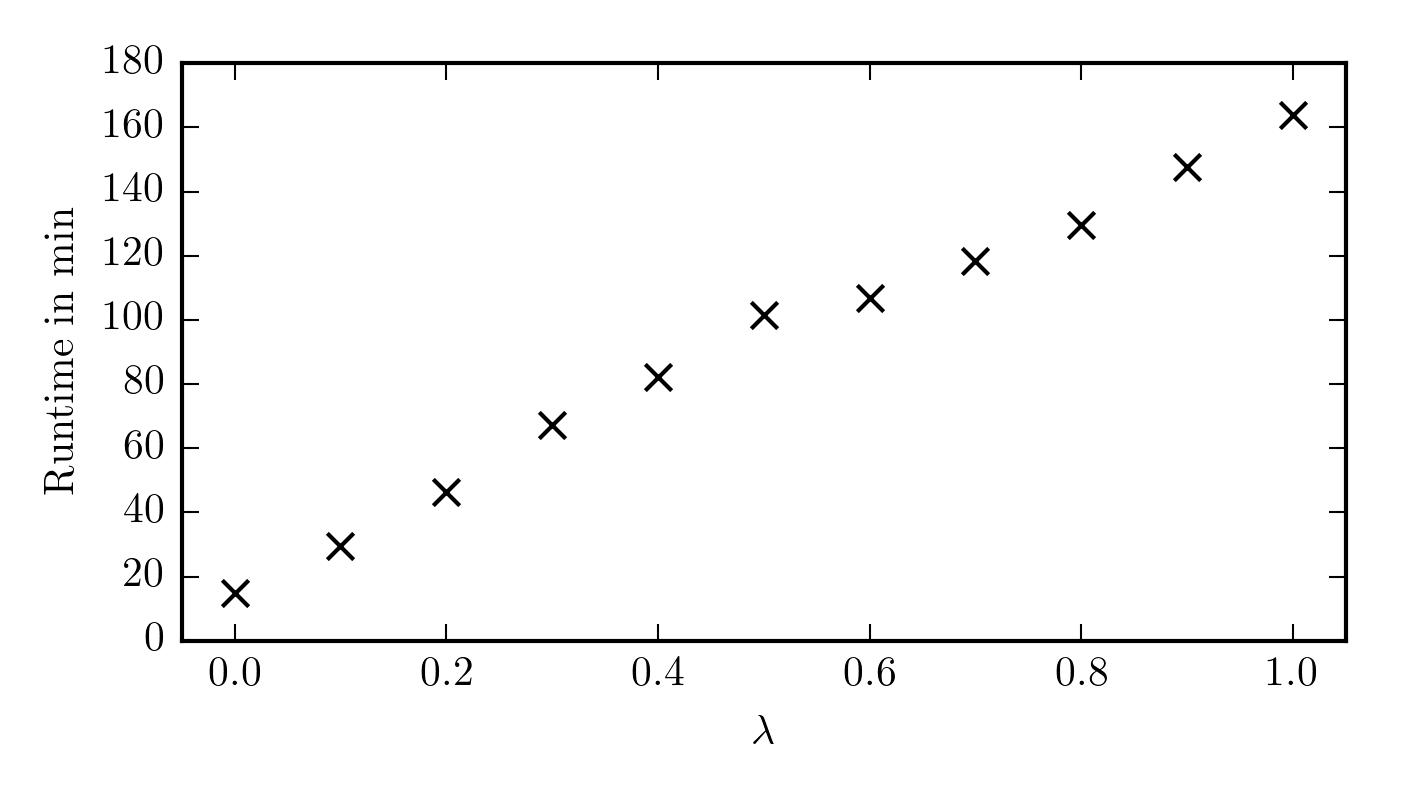

(-0.05, 1.05)

In [227]:
df_welda_runtime = pnd.DataFrame.from_records([
    (0.0, 900),
    (0.1, 1775),
    (0.2, 2785),
    (0.3, 4027),
    (0.4, 4926),
    (0.5, 6100),
    (0.6, 6411),
    (0.7, 7109),
    (0.8, 7773),
    (0.9, 8856),
    (1.0, 9826)
], columns=["lambda", "runtime"])
df_welda_runtime["runtime_min"] = df_welda_runtime["runtime"] / 60
plt.figure(figsize=cm2inch(12, 6.75), dpi=300)
plt.scatter(df_welda_runtime["lambda"], df_welda_runtime["runtime_min"], c="black", marker="x", s=40)
plt.xlabel("$\\lambda$")
plt.ylabel("Runtime in min")
plt.tight_layout()
plt.xlim((-0.05, 1.05))


## Document classification

### Setup

In [109]:
import multiprocessing
for p in multiprocessing.active_children():
    p.terminate()
    p.join()

multiprocessing.active_children()

[]

In [ ]:
def load_document_topics(folder):
    if os.path.isdir(folder):
        document_topics = [f for f in os.listdir(folder) if "document-topics" in f or "theta" in f]
        assert len(document_topics) == 1
        document_topics = folder + "/" + document_topics[0]
    else:
        document_topics = folder
    
    df_return = pnd.read_csv(document_topics, sep=" ", header=None)
    if len(df_return.columns) == 50:
        df_return.columns = range(1, 51)
    elif len(df_return.columns) == 51:
        df_return.columns = ["class"] + range(1, 51)
    elif len(df_return.columns) == 52:
        df_return.columns = ["class", "freq"] + range(1, 51)
    elif len(df_return.columns) == 201:
        df_return.columns = ["class"] + range(1, 201)
    elif len(df_return.columns) == 250:
        df_return.columns = range(1, 251)
    elif len(df_return.columns) == 251:
        df_return.columns = ["class"] + range(1, 251)
    else:
        raise Exception("unknown column count " + str(len(df_return.columns)))
    return df_return

def get_evaluation_metrics(y_test, y_predictions, average="macro"):
    precision = metrics.precision_score(y_test, y_predictions, average=average)
    recall = metrics.recall_score(y_test, y_predictions, average=average)
    f1 = metrics.f1_score(y_test, y_predictions, average=average)
    accuracy = metrics.accuracy_score(y_test, y_predictions)
    return precision, recall, f1, accuracy


def evaluate_document_classification(df_param, print_eval=False):
    nr_classes = len(set(df_param["class"].tolist()))
    nr_features = len(df_param.columns) - 1
    if print_eval:
        print "nr_classes = %d, nr_features = %d" % (nr_classes, nr_features)
    
    feature_columns = list(range(1, nr_features + 1))
    #X = df_param.as_matrix(feature_columns)
   
    train, test = train_test_split(df_param, test_size = 0.2, stratify=df_param["class"], random_state=21011991)
    feature_columns = df_param.columns[1:]
    assert len(feature_columns) == nr_features
    if print_eval:
        print "feature_columns = %s" % str(feature_columns)
        
    X_train = train.as_matrix(feature_columns)
    #X_train = normalize(X_train, norm="l1")
    X_test = test.as_matrix(feature_columns)
    if print_eval:
        print X_train.shape
        print X_test.shape
    
    model = svm.LinearSVC(penalty='l1', dual=False, random_state=21011991)
    y_train = train["class"].tolist()
    model.fit(X_train, y_train)
    
    y_test = test["class"].tolist()
    y_predictions = model.predict(X_test)
    if print_eval:
        print metrics.classification_report(y_test, y_predictions, digits=2)
    return get_evaluation_metrics(y_test, y_predictions)

def evaluate_experiment(f_param, classes_file, avg_we_file):
    df_return = load_document_topics(f_param)

    if classes_file:
        df_return.insert(0, "class",
                           pnd.read_csv("/data/wikipedia/2016-06-21/topic-models/" + classes_file,
                                  header=None))
    if avg_we_file:
        df_avg = pnd.read_csv(avg_we_file, header=None, sep=" ")
        nr_avg_dimensions = len(df_avg.columns) - 1
        avg_column_names = ["avg-" + str(i) for i in range(1, nr_avg_dimensions + 1)]
        df_avg.columns = ["class_avg"] + avg_column_names
        assert len(df_avg) == len(df_return), "len(df_avg) = %d   !=   len(df_return) = %d" % (len(df_avg), len(df_return))
        
        
        
        df_return = pnd.concat([df_return, df_avg], axis=1)        
        df_return = df_return[df_return["class_avg"] >= 0]
        assert all(df_return["class"] == df_return["class_avg"])
        del df_return["class_avg"]
    return evaluate_document_classification(df_return, print_eval=False)

def run_experiment(exp_tuple, classes_file):
    e, avg_we = exp_tuple
    if "google" in e:
        embedding_data = "google"
    elif ".20news.dim-50" in e:
        embedding_data = "20news.dim-50"
    elif "dim-50" in e:
        embedding_data = "dim-50"
    elif "dim-200" in e:
        embedding_data = "dim-200"
    else:
        embedding_data = None
        #raise Exception(e + ": embedding not known")
    
    params = parse_params(e)
    prec, rec, f1, acc = evaluate_experiment(e, classes_file, avg_we)

    exp_name = ""
    if os.path.isfile(e):
        exp_name = os.path.basename(os.path.dirname(e)) + "/" + os.path.basename(e)
    else:
        exp_name = os.path.basename(e)

    avg_we = os.path.basename(avg_we) if avg_we else None
    return (params, (exp_name, embedding_data, avg_we, prec, rec, f1, acc))

def evaluate_multiple_experiments(experiment_files, classes_file, avg_embeddings_file, evaluate_raw=True, threads=1):
    exp_tuples = []
    for e in experiment_files:
        if avg_embeddings_file:
            exp_tuples.append((e, avg_embeddings_file))
        if evaluate_raw:
            exp_tuples.append((e, None))

    if threads == 1:
        results = map(partial(run_experiment, classes_file=classes_file), exp_tuples)
    else:
        try:
            p = Pool(threads)
            results = p.map(partial(run_experiment, classes_file=classes_file), exp_tuples)
        finally:
            p.close()
    
    params_lists = defaultdict(list)
    for params, result_tuple in results:
        for k, v in params.iteritems():
            params_lists[k].append(v)

    results = [r[1] for r in results]    
    
    df_return = pnd.DataFrame.from_records(results, columns=["experiment", "embedding", "avg-embedding", "precision", "recall", "f1", "accuracy"])
    for p in ["lambda"]:
        if p in params_lists.keys():
            df_return.insert(1, p, params_lists[p])
    df_return = df_return.sort_values(["embedding"])
    return df_return

In [4]:
pnd.get_option('display.max_columns')
pnd.set_option('display.max_columns', 300)
pnd.set_option('display.max_rows', 300)

### Avg. embedding

In [116]:
df_avg_embeddings = evaluate_multiple_experiments([
        "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding",
        "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02/model.dim-50.skip-gram.embedding.avg-embedding",
        "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.avg-embedding",
    ], None, None, threads=3)
df_avg_embeddings

experiment  \
2  topic.20news.250-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.avg-embedding   
0        topic.20news.250-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding   
1         topic.20news.250-1500.alpha-0-02.beta-0-02/model.dim-50.skip-gram.embedding.avg-embedding   

       embedding avg-embedding  precision    recall        f1  accuracy  
2  20news.dim-50          None   0.769588  0.763100  0.760846  0.772466  
0        dim-200          None   0.684866  0.690834  0.681851  0.703851  
1         dim-50          None   0.573333  0.583151  0.567446  0.596282

In [22]:
df_avg_embeddings

experiment  \
1  topic.20news.250-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.avg-embedding   
3   topic.20news.50-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.avg-embedding   
0        topic.20news.250-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding   
2         topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding   

       embedding avg-embedding  precision    recall        f1  accuracy  
1  20news.dim-50          None   0.786032  0.781629  0.779683  0.789730  
3  20news.dim-50          None   0.786032  0.781629  0.779683  0.789730  
0        dim-200          None   0.715753  0.704774  0.698922  0.716689  
2        dim-200          None   0.715753  0.704774  0.698922  0.716689

### LDA

In [26]:
dcs_lda_experiments = sorted(find_files("/data/wikipedia/2016-06-21/topic-models", "20news.50-1500.alpha"))

df_dcs_lda = evaluate_multiple_experiments(dcs_lda_experiments,
                     None,
                     "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding",
                     threads=8)
df_dcs_lda

/home/stefan.bunk/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stefan.bunk/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


experiment embedding  \
0   topic.20news.50-1500.alpha-0-002.beta-0-002      None   
1   topic.20news.50-1500.alpha-0-002.beta-0-002      None   
2   topic.20news.50-1500.alpha-0-002.beta-0-005      None   
3   topic.20news.50-1500.alpha-0-002.beta-0-005      None   
4    topic.20news.50-1500.alpha-0-002.beta-0-01      None   
5    topic.20news.50-1500.alpha-0-002.beta-0-01      None   
6    topic.20news.50-1500.alpha-0-002.beta-0-02      None   
7    topic.20news.50-1500.alpha-0-002.beta-0-02      None   
8    topic.20news.50-1500.alpha-0-002.beta-0-05      None   
9    topic.20news.50-1500.alpha-0-002.beta-0-05      None   
10    topic.20news.50-1500.alpha-0-002.beta-0-1      None   
11    topic.20news.50-1500.alpha-0-002.beta-0-1      None   
12  topic.20news.50-1500.alpha-0-005.beta-0-002      None   
13  topic.20news.50-1500.alpha-0-005.beta-0-002      None   
14  topic.20news.50-1500.alpha-0-005.beta-0-005      None   
15  topic.20news.50-1500.alpha-0-005.beta-0-005      None   
16   topic.20news.50-1500.alpha-0-005.beta-0-01      None   
17   topic.20news.50-1500.alpha-0-005.beta-0-01      None   
18   topic.20news.50-1500.alpha-0-005.beta-0-02      None   
19   topic.20news.50-1500.alpha-0-005.beta-0-02      None   
20   topic.20news.50-1500.alpha-0-005.beta-0-05      None   
21   topic.20news.50-1500.alpha-0-005.beta-0-05      None   
22    topic.20news.50-1500.alpha-0-005.beta-0-1      None   
23    topic.20news.50-1500.alpha-0-005.beta-0-1      None   
24   topic.20news.50-1500.alpha-0-01.beta-0-002      None   
25   topic.20news.50-1500.alpha-0-01.beta-0-002      None   
26   topic.20news.50-1500.alpha-0-01.beta-0-005      None   
27   topic.20news.50-1500.alpha-0-01.beta-0-005      None   
28    topic.20news.50-1500.alpha-0-01.beta-0-01      None   
29    topic.20news.50-1500.alpha-0-01.beta-0-01      None   
..                                          ...       ...   
42    topic.20news.50-1500.alpha-0-02.beta-0-02      None   
43    topic.20news.50-1500.alpha-0-02.beta-0-02      None   
44    topic.20news.50-1500.alpha-0-02.beta-0-05      None   
45    topic.20news.50-1500.alpha-0-02.beta-0-05      None   
46     topic.20news.50-1500.alpha-0-02.beta-0-1      None   
47     topic.20news.50-1500.alpha-0-02.beta-0-1      None   
48   topic.20news.50-1500.alpha-0-05.beta-0-002      None   
49   topic.20news.50-1500.alpha-0-05.beta-0-002      None   
50   topic.20news.50-1500.alpha-0-05.beta-0-005      None   
51   topic.20news.50-1500.alpha-0-05.beta-0-005      None   
52    topic.20news.50-1500.alpha-0-05.beta-0-01      None   
53    topic.20news.50-1500.alpha-0-05.beta-0-01      None   
54    topic.20news.50-1500.alpha-0-05.beta-0-02      None   
55    topic.20news.50-1500.alpha-0-05.beta-0-02      None   
56    topic.20news.50-1500.alpha-0-05.beta-0-05      None   
57    topic.20news.50-1500.alpha-0-05.beta-0-05      None   
58     topic.20news.50-1500.alpha-0-05.beta-0-1      None   
59     topic.20news.50-1500.alpha-0-05.beta-0-1      None   
60    topic.20news.50-1500.alpha-0-1.beta-0-002      None   
61    topic.20news.50-1500.alpha-0-1.beta-0-002      None   
62    topic.20news.50-1500.alpha-0-1.beta-0-005      None   
63    topic.20news.50-1500.alpha-0-1.beta-0-005      None   
64     topic.20news.50-1500.alpha-0-1.beta-0-01      None   
65     topic.20news.50-1500.alpha-0-1.beta-0-01      None   
66     topic.20news.50-1500.alpha-0-1.beta-0-02      None   
67     topic.20news.50-1500.alpha-0-1.beta-0-02      None   
68     topic.20news.50-1500.alpha-0-1.beta-0-05      None   
69     topic.20news.50-1500.alpha-0-1.beta-0-05      None   
70      topic.20news.50-1500.alpha-0-1.beta-0-1      None   
71      topic.20news.50-1500.alpha-0-1.beta-0-1      None   

                                      avg-embedding  precision    recall  \
0   model.dim-200.skip-gram.embedding.avg-embedding   0.779129  0.778482   
1                                              None   0.698191  0.701079   
2   model.dim-200.skip-gra

In [74]:
dcs_lda50_experiments = sorted(find_files("/data/wikipedia/2016-06-21/topic-models", "20news.50-1500.alpha-0-02.beta-0-02"))

df_dcs_lda50 = evaluate_multiple_experiments(dcs_lda_experiments,
                     None,
                     "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.avg-embedding.fix",
                     threads=1, evaluate_raw=False)
df_dcs_lda50

experiment embedding  \
0  topic.20news.50-1500.alpha-0-02.beta-0-02      None   

                                               avg-embedding  precision  \
0  model.20news.dim-50.skip-gram.embedding.avg-embedding.fix   0.791582   

     recall        f1  accuracy  
0  0.786682  0.785224  0.793714

In [ ]:
dcs_lda250_experiments = sorted(find_files("/data/wikipedia/2016-06-21/topic-models", "20news.250-1500.alpha"))

df_dcs_lda250 = evaluate_multiple_experiments(dcs_lda250_experiments,
                     None,
                     "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding",
                     threads=12)
df_dcs_lda250

experiment embedding  \
0  topic.20news.250-1500.alpha-0-02.beta-0-02      None   
1  topic.20news.250-1500.alpha-0-02.beta-0-02      None   

                                     avg-embedding  precision    recall  \
0  model.dim-200.skip-gram.embedding.avg-embedding   0.803627  0.801018   
1                                             None   0.732185  0.727802   

         f1  accuracy  
0  0.799860  0.808322  
1  0.726019  0.736166

In [ ]:
dcs_lda50_250_experiments = sorted(find_files("/data/wikipedia/2016-06-21/topic-models", "20news.250-1500.alpha-0-02.beta-0-02"))

df_dcs_lda50_250 = evaluate_multiple_experiments(dcs_lda50_250_experiments,
                     None,
                     "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.avg-embedding.fix",
                     threads=1)
df_dcs_lda50_250

In [84]:
df_dcs_lda50_250

experiment embedding  \
0  topic.20news.250-1500.alpha-0-02.beta-0-02      None   
1  topic.20news.250-1500.alpha-0-02.beta-0-02      None   

                                               avg-embedding  precision  \
0  model.20news.dim-50.skip-gram.embedding.avg-embedding.fix   0.819958   
1                                                       None   0.747451   

     recall        f1  accuracy  
0  0.814312  0.813640  0.821160  
1  0.739215  0.739998  0.746348

### WELDA-Gaussian

**50 topics 20news-50**

In [ ]:
dcs_welda50_experiment_folder = "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02"
dcs_welda50_experiments = find_files(dcs_welda50_experiment_folder, "model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-0.")
dcs_welda50_experiments = [f + "/welda.iteration-200.document-topics" for f in dcs_welda50_experiments]

df_dcs_welda50 = evaluate_multiple_experiments(dcs_welda50_experiments,
                     "topic.20news.50-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.restricted.classes",
                     "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.avg-embedding",
                     threads=6)
df_dcs_welda50.sort_values(["embedding", "lambda", "avg-embedding"])


In [79]:
df_dcs_welda50

experiment  \
0  model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-0.lambdaact-0-0/welda.iteration-200.document-topics   
1  model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-0.lambdaact-0-0/welda.iteration-200.document-topics   

  lambda      embedding  \
0    0.0  20news.dim-50   
1    0.0  20news.dim-50   

                                           avg-embedding  precision    recall  \
0  model.20news.dim-50.skip-gram.embedding.avg-embedding   0.805808  0.802128   
1                                                   None   0.678442  0.675507   

         f1  accuracy  
0  0.800159  0.810978  
1  0.662931  0.687030

In [14]:
dcs_welda50_experiment_folder = "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02"
dcs_welda50_experiments = find_files(dcs_welda50_experiment_folder, "model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.")
dcs_welda50_experiments = [f + "/welda.iteration-200.document-topics" for f in dcs_welda50_experiments]

df_dcs_welda50 = evaluate_multiple_experiments(dcs_welda50_experiments,
                     "topic.20news.50-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.restricted.classes",
                     "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.avg-embedding",
                     threads=6)
df_dcs_welda50.sort_values(["embedding", "lambda", "avg-embedding"])


/home/stefan.bunk/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stefan.bunk/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stefan.bunk/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stefan.bunk/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precisio

experiment  \
2      model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-0.lambdaact-0-0/welda.iteration-200.document-topics   
3      model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-0.lambdaact-0-0/welda.iteration-200.document-topics   
16  model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-001.lambdaact-0-12/welda.iteration-200.document-topics   
17  model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-001.lambdaact-0-12/welda.iteration-200.document-topics   
6      model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-1.lambdaact-0-2/welda.iteration-200.document-topics   
7      model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-1.lambdaact-0-2/welda.iteration-200.document-topics   
8     model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-2.lambdaact-0-29/welda.iteration-200.document-topics   
9     model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-2.lambdaact-0-29/welda.iteration-200.document-topics   
10    model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-3.lambdaact-0-38/welda.iteration-200.document-topics   
11    model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-3.lambdaact-0-38/welda.iteration-200.document-topics   
18    model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-4.lambdaact-0-47/welda.iteration-200.document-topics   
19    model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-4.lambdaact-0-47/welda.iteration-200.document-topics   
4     model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-5.lambdaact-0-55/welda.iteration-200.document-topics   
5     model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-5.lambdaact-0-55/welda.iteration-200.document-topics   
14    model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-6.lambdaact-0-65/welda.iteration-200.document-topics   
15    model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-6.lambdaact-0-65/welda.iteration-200.document-topics   
20    model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-7.lambdaact-0-73/welda.iteration-200.document-topics   
21    model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-7.lambdaact-0-73/welda.iteration-200.document-topics   
0     model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-8.lambdaact-0-82/welda.iteration-200.document-topics   
1     model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-8.lambdaact-0-82/welda.iteration-200.document-topics   
12    model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-9.lambdaact-0-91/welda.iteration-200.document-topics   
13    model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-9.lambdaact-0-91/welda.iteration-200.document-topics   
22     model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-ga

In [46]:
df_dcs_welda50["avg-embedding"].fillna('missing')

experiment  \
0     model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-8.lambdaact-0-82/welda.iteration-200.document-topics   
21    model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-7.lambdaact-0-73/welda.iteration-200.document-topics   
20    model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-7.lambdaact-0-73/welda.iteration-200.document-topics   
19    model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-4.lambdaact-0-47/welda.iteration-200.document-topics   
18    model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-4.lambdaact-0-47/welda.iteration-200.document-topics   
17  model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-001.lambdaact-0-12/welda.iteration-200.document-topics   
16  model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-001.lambdaact-0-12/welda.iteration-200.document-topics   
15    model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-6.lambdaact-0-65/welda.iteration-200.document-topics   
14    model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-6.lambdaact-0-65/welda.iteration-200.document-topics   
13    model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-9.lambdaact-0-91/welda.iteration-200.document-topics   
12    model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-9.lambdaact-0-91/welda.iteration-200.document-topics   
11    model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-3.lambdaact-0-38/welda.iteration-200.document-topics   
10    model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-3.lambdaact-0-38/welda.iteration-200.document-topics   
9     model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-2.lambdaact-0-29/welda.iteration-200.document-topics   
8     model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-2.lambdaact-0-29/welda.iteration-200.document-topics   
7      model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-1.lambdaact-0-2/welda.iteration-200.document-topics   
6      model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-1.lambdaact-0-2/welda.iteration-200.document-topics   
5     model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-5.lambdaact-0-55/welda.iteration-200.document-topics   
4     model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-5.lambdaact-0-55/welda.iteration-200.document-topics   
3      model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-0.lambdaact-0-0/welda.iteration-200.document-topics   
2      model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-0.lambdaact-0-0/welda.iteration-200.document-topics   
1     model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-8.lambdaact-0-82/welda.iteration-200.document-topics   
22     model.20news.dim-50.skip-gram.embedding.welda.gaussian.welda-ga

**50 topics**

<IPython.core.display.Javascript object>


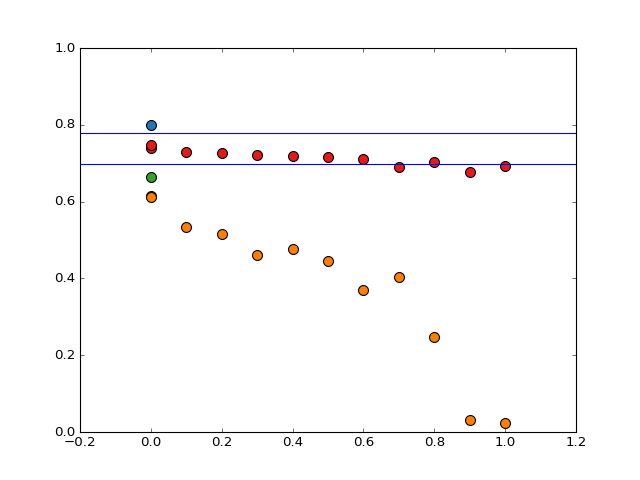

model.20news.dim-50.skip-gram.embedding.avg-embedding
no embeddings
model.dim-200.skip-gram.embedding.avg-embedding
no embeddings


In [86]:
def plot():
    plt.figure()
    it = iter(DARK_COLORS)

    df_dcs_welda50["avg-embedding"].fillna("no embeddings", inplace=True)
    for avg_embedding, df_group in df_dcs_welda50.groupby("avg-embedding"):
        print avg_embedding
        plt.scatter(list(df_group["lambda"]), df_group["f1"], c=next(it), s=80, label=avg_embedding)
    
    
    df_dcs_welda["avg-embedding"].fillna("no embeddings", inplace=True)
    for avg_embedding, df_group in df_dcs_welda.groupby("avg-embedding"):
        print avg_embedding
        plt.scatter(list(df_group["lambda"]), df_group["f1"], c=next(it), s=80, label=avg_embedding)

    plt.ylim((0.0, 1.0))
    plt.axhline(y=0.779683, label="foo")
    plt.axhline(y=0.698922, label="bar")
     
    #plt.legend()

plot()

In [19]:
dcs_welda_experiment_folder = "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02"
dcs_welda_experiments = find_files(dcs_welda_experiment_folder, "model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20")
dcs_welda_experiments = [f + "/welda.iteration-200.document-topics" for f in dcs_welda_experiments]

df_dcs_welda = evaluate_multiple_experiments(dcs_welda_experiments,
                     "topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.restricted.classes",
                     "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding",
                     threads=6)
df_dcs_welda.sort_values(["embedding", "lambda", "avg-embedding"])


/home/stefan.bunk/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stefan.bunk/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stefan.bunk/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stefan.bunk/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precisio

experiment  \
8      model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-0.lambdaact-0-0/welda.iteration-200.document-topics   
9      model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-0.lambdaact-0-0/welda.iteration-200.document-topics   
6   model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-001.lambdaact-0-11/welda.iteration-200.document-topics   
7   model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-001.lambdaact-0-11/welda.iteration-200.document-topics   
4      model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-1.lambdaact-0-2/welda.iteration-200.document-topics   
5      model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-1.lambdaact-0-2/welda.iteration-200.document-topics   
12    model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-2.lambdaact-0-29/welda.iteration-200.document-topics   
13    model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-2.lambdaact-0-29/welda.iteration-200.document-topics   
0     model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-3.lambdaact-0-38/welda.iteration-200.document-topics   
1     model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-3.lambdaact-0-38/welda.iteration-200.document-topics   
14    model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-4.lambdaact-0-46/welda.iteration-200.document-topics   
15    model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-4.lambdaact-0-46/welda.iteration-200.document-topics   
16    model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-5.lambdaact-0-55/welda.iteration-200.document-topics   
17    model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-5.lambdaact-0-55/welda.iteration-200.document-topics   
2     model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-6.lambdaact-0-64/welda.iteration-200.document-topics   
3     model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-6.lambdaact-0-64/welda.iteration-200.document-topics   
18    model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-7.lambdaact-0-73/welda.iteration-200.document-topics   
19    model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-7.lambdaact-0-73/welda.iteration-200.document-topics   
22    model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-8.lambdaact-0-82/welda.iteration-200.document-topics   
23    model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-8.lambdaact-0-82/welda.iteration-200.document-topics   
10    model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-9.lambdaact-0-91/welda.iteration-200.document-topics   
11    model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-0-9.lambdaact-0-91/welda.iteration-200.document-topics   
20     model.dim-200.skip-gram.embedding.welda.gaussian.welda-gaussian-lambda.run-0.topic0-no.pca-10.des-20.lambda-1-0.lambdaact-1-0/welda.iteration-200.document-topics   
21     model.dim-200.skip-gram

**250 topics**

In [30]:
dcs_welda250_experiments = find_files(
    "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02", "dim-200.skip-gram.embedding.welda.gaussian")
dcs_welda250_experiments = [f + "/welda.iteration-100.document-topics" for f in dcs_welda250_experiments]

df_dcs_welda250 = evaluate_multiple_experiments(dcs_welda250_experiments,
                     "topic.20news.250-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.restricted.classes",
                     "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding",
                     threads=15)
df_dcs_welda250.sort_values(["embedding", "lambda", "avg-embedding"])


experiment  \
10  model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-0/welda.iteration-100.document-topics   
11  model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-0/welda.iteration-100.document-topics   
6   model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-3/welda.iteration-100.document-topics   
7   model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-3/welda.iteration-100.document-topics   
4   model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-100.document-topics   
5   model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-100.document-topics   
2   model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-6/welda.iteration-100.document-topics   
3   model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-6/welda.iteration-100.document-topics   
0   model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-8/welda.iteration-100.document-topics   
1   model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-8/welda.iteration-100.document-topics   
8   model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-1-0/welda.iteration-100.document-topics   
9   model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-1-0/welda.iteration-100.document-topics   

   lambda embedding                                    avg-embedding  \
10    0.0   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
11    0.0   dim-200                                             None   
6     0.3   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
7     0.3   dim-200                                             None   
4     0.5   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
5     0.5   dim-200                                             None   
2     0.6   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
3     0.6   dim-200                                             None   
0     0.8   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
1     0.8   dim-200                                             None   
8     1.0   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
9     1.0   dim-200                                             None   

    precision    recall        f1  accuracy  
10   0.802722  0.798177  0.796964  0.806380  
11   0.745376  0.740223  0.738118  0.747895  
6    0.767874  0.765384  0.763696  0.773593  
7    0.679969  0.656080  0.658384  0.662827  
4    0.762601  0.758610  0.756676  0.766947  
5    0.658533  0.629026  0.633723  0.634914  
2    0.763478  0.758745  0.756792  0.767833  
3    0.638607  0.616661  0.620596  0.623394  
0    0.744850  0.738682  0.736163  0.747895  
1    0.576705  0.539894  0.545683  0.546743  
8    0.705037  0.700206  0.693475  0.712893  
9    0.314046  0.224988  0.229012  0.231280

In [111]:
dcs_welda50_250_experiments_base = find_files(
    "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02", "dim-50.skip-gram.embedding.welda.gaussian..")
dcs_welda50_250_experiments = sorted(
    [f + "/welda.iteration-100.document-topics" for f in dcs_welda50_250_experiments_base] +
    [f + "/welda.iteration-200.document-topics" for f in dcs_welda50_250_experiments_base])

df_dcs_welda50_250 = evaluate_multiple_experiments(dcs_welda50_250_experiments,
                     "topic.20news.250-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.restricted.classes",
                     "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.avg-embedding",
                     threads=10)
df_dcs_welda50_250.sort_values(["embedding", "lambda", "avg-embedding"])


experiment  \
0    model.20news.dim-50.skip-gram.embedding.welda.gaussian..topic0-no.pca-10.des-20.lambda-0-0.lambdaact-0-0/welda.iteration-100.document-topics   
2    model.20news.dim-50.skip-gram.embedding.welda.gaussian..topic0-no.pca-10.des-20.lambda-0-0.lambdaact-0-0/welda.iteration-200.document-topics   
1    model.20news.dim-50.skip-gram.embedding.welda.gaussian..topic0-no.pca-10.des-20.lambda-0-0.lambdaact-0-0/welda.iteration-100.document-topics   
3    model.20news.dim-50.skip-gram.embedding.welda.gaussian..topic0-no.pca-10.des-20.lambda-0-0.lambdaact-0-0/welda.iteration-200.document-topics   
4   model.20news.dim-50.skip-gram.embedding.welda.gaussian..topic0-no.pca-10.des-20.lambda-0-2.lambdaact-0-29/welda.iteration-100.document-topics   
6   model.20news.dim-50.skip-gram.embedding.welda.gaussian..topic0-no.pca-10.des-20.lambda-0-2.lambdaact-0-29/welda.iteration-200.document-topics   
5   model.20news.dim-50.skip-gram.embedding.welda.gaussian..topic0-no.pca-10.des-20.lambda-0-2.lambdaact-0-29/welda.iteration-100.document-topics   
7   model.20news.dim-50.skip-gram.embedding.welda.gaussian..topic0-no.pca-10.des-20.lambda-0-2.lambdaact-0-29/welda.iteration-200.document-topics   
8   model.20news.dim-50.skip-gram.embedding.welda.gaussian..topic0-no.pca-10.des-20.lambda-0-3.lambdaact-0-38/welda.iteration-100.document-topics   
10  model.20news.dim-50.skip-gram.embedding.welda.gaussian..topic0-no.pca-10.des-20.lambda-0-3.lambdaact-0-38/welda.iteration-200.document-topics   
9   model.20news.dim-50.skip-gram.embedding.welda.gaussian..topic0-no.pca-10.des-20.lambda-0-3.lambdaact-0-38/welda.iteration-100.document-topics   
11  model.20news.dim-50.skip-gram.embedding.welda.gaussian..topic0-no.pca-10.des-20.lambda-0-3.lambdaact-0-38/welda.iteration-200.document-topics   

   lambda      embedding  \
0     0.0  20news.dim-50   
2     0.0  20news.dim-50   
1     0.0  20news.dim-50   
3     0.0  20news.dim-50   
4     0.2  20news.dim-50   
6     0.2  20news.dim-50   
5     0.2  20news.dim-50   
7     0.2  20news.dim-50   
8     0.3  20news.dim-50   
10    0.3  20news.dim-50   
9     0.3  20news.dim-50   
11    0.3  20news.dim-50   

                                            avg-embedding  precision  \
0   model.20news.dim-50.skip-gram.embedding.avg-embedding   0.813803   
2   model.20news.dim-50.skip-gram.embedding.avg-embedding   0.811605   
1                                                    None   0.738430   
3                                                    None   0.731893   
4   model.20news.dim-50.skip-gram.embedding.avg-embedding   0.804446   
6   model.20news.dim-50.skip-gram.embedding.avg-embedding   0.802216   
5                                                    None   0.655634   
7                                                    None   0.654552   
8   model.20news.dim-50.skip-gram.embedding.avg-embedding   0.802391   
10  model.20news.dim-50.skip-gram.embedding.avg-embedding   0.797512   
9                                                    None   0.655015   
11                                                   None   0.647092   

      recall        f1  accuracy  
0   0.811115  0.809949  0.817618  
2   0.809468  0.808459  0.815405  
1   0.737233  0.733976  0.743692  
3   0.730012  0.727281  0.736166  
4   0.801326  0.800723  0.806552  
6   0.797194  0.796695  0.803453  
5   0.637371  0.639252  0.641434  
7   0.626336  0.632230  0.630367  
8   0.796927  0.796304  0.802568  
10  0.793030  0.792291  0.798583  
9   0.612067  0.621140  0.616202  
11  0.601222  0.612385  0.605135

In [197]:
foo = sorted(find_files(
    "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5", "document-topics"))
df_foo = evaluate_multiple_experiments(foo,
                     "topic.20news.250-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.restricted.classes",
                     threads=15)
df_foo
#df_dcs_welda250.sort_values(["embedding", "lambda"])

#evaluate_experiment("/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-000.document-topics",
#                    )
#del df_doc_class["file"]
#evaluate_document_classification(df_doc_class)

experiment  \
0   model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-000.document-topics   
30  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-030.document-topics   
31  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-031.document-topics   
32  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-032.document-topics   
33  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-033.document-topics   
34  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-034.document-topics   
35  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-035.document-topics   
36  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-036.document-topics   
37  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-037.document-topics   
38  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-038.document-topics   
39  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-039.document-topics   
40  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-040.document-topics   
29  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-029.document-topics   
41  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-041.document-topics   
43  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-043.document-topics   
44  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-044.document-topics   
45  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-045.document-topics   
46  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-046.document-topics   
47  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-047.document-topics   
48  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-048.document-topics   
49  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-049.document-topics   
50  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-050.document-topics   
51  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-051.document-topics   
52  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-052.document-topics   
53  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-053.document-topics   
42  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-042.document-topics   
28  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-028.document-topics   
27  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-027.document-topics   
26  model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-026.document-topics   
1   model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-001.document-topics   
2   model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-002.document-topics   
3   model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-003.document-topics   
4   model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5

### WELDA-vMF

In [35]:
dcs_welda_vmf_experiment_folder = "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02"
dcs_welda_vmf_experiments = [f + "/welda.iteration-100.document-topics" for f in find_files(dcs_welda_vmf_experiment_folder,
                                                                                            "dim-200.skip-gram.embedding.welda.vmf.")]
dcs_welda_vmf_experiments = [f for f in dcs_welda_vmf_experiments if os.path.exists(f)]

df_dcs_welda_vmf = evaluate_multiple_experiments(dcs_welda_vmf_experiments,
                     "topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.restricted.classes",
                     "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding",
                     threads=16)
#df_dcs_welda = df_dcs_welda[df_dcs_welda["lambda"] != 0.0]
df_dcs_welda_vmf.sort_values(["embedding", "lambda", "avg-embedding"])


experiment  \
10  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-0/welda.iteration-100.document-topics   
2   model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-20.lambda-0-0/welda.iteration-100.document-topics   
11  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-0/welda.iteration-100.document-topics   
3   model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-20.lambda-0-0/welda.iteration-100.document-topics   
0   model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-20.lambda-0-3/welda.iteration-100.document-topics   
12  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-3/welda.iteration-100.document-topics   
13  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-3/welda.iteration-100.document-topics   
1   model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-20.lambda-0-3/welda.iteration-100.document-topics   
20  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-20.lambda-0-5/welda.iteration-100.document-topics   
4   model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-5/welda.iteration-100.document-topics   
21  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-20.lambda-0-5/welda.iteration-100.document-topics   
5   model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-5/welda.iteration-100.document-topics   
18  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-20.lambda-0-6/welda.iteration-100.document-topics   
8   model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-6/welda.iteration-100.document-topics   
19  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-20.lambda-0-6/welda.iteration-100.document-topics   
9   model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-6/welda.iteration-100.document-topics   
14  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-20.lambda-0-8/welda.iteration-100.document-topics   
6   model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-8/welda.iteration-100.document-topics   
15  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-20.lambda-0-8/welda.iteration-100.document-topics   
7   model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-8/welda.iteration-100.document-topics   
16  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-1-0/welda.iteration-100.document-topics   
22  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-20.lambda-1-0/welda.iteration-100.document-topics   
17  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-1-0/welda.iteration-100.document-topics   
23  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-20.lambda-1-0/welda.iteration-100.document-topics   

   lambda embedding                                    avg-embedding  \
10    0.0   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
2     0.0   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
11    0.0   dim-200                                             None   
3     0.0   dim-200                                             None   
0     0.3   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
12    0.3   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
13    0.3   dim-200                                             None   
1     0.3   dim-200                                             None   
20    0.5   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
4     0.5   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
21    0.5   dim-200                                             None   
5     0.5   dim-200                                             None   
18    0.6   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
8     0.6   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
19    0.6   dim-200                              

In [13]:
df_dcs_welda_vmf.sort_values(["embedding", "lambda", "avg-embedding"])

experiment  \
12  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-0/welda.iteration-100.document-topics   
13  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-0/welda.iteration-100.document-topics   
14  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-3/welda.iteration-100.document-topics   
15  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-3/welda.iteration-100.document-topics   
4   model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-5/welda.iteration-100.document-topics   
2           model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.lambda-0-5/welda.iteration-100.document-topics   
5   model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-5/welda.iteration-100.document-topics   
3           model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.lambda-0-5/welda.iteration-100.document-topics   
0           model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.lambda-0-6/welda.iteration-100.document-topics   
10  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-6/welda.iteration-100.document-topics   
11  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-6/welda.iteration-100.document-topics   
1           model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.lambda-0-6/welda.iteration-100.document-topics   
8   model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-8/welda.iteration-100.document-topics   
6           model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.lambda-0-8/welda.iteration-100.document-topics   
9   model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-8/welda.iteration-100.document-topics   
7           model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.lambda-0-8/welda.iteration-100.document-topics   
16  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-1-0/welda.iteration-100.document-topics   
17  model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-1-0/welda.iteration-100.document-topics   

   lambda embedding                                    avg-embedding  \
12    0.0   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
13    0.0   dim-200                                             None   
14    0.3   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
15    0.3   dim-200                                             None   
4     0.5   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
2     0.5   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
5     0.5   dim-200                                             None   
3     0.5   dim-200                                             None   
0     0.6   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
10    0.6   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
11    0.6   dim-200                                             None   
1     0.6   dim-200                                             None   
8     0.8   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
6     0.8   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
9     0.8   dim-200                                             None   
7     0.8   dim-200                                             None   
16    1.0   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
17    1.0   dim-200                                             None   

    precision    recall        f1  accuracy  
12   0.768182  0.766316  0.761685  0.775809  
13   0.689268  0.675401  0.663097  0.686752  
14   0.746354  0.738011  0.735304  0.747452  
15   0.596332  0.592261  0.582454  0.602570  
4    0.761892  0.754372  0.749822  0.764289  
2    0.739293  0.730774  0.727190  0.742136  
5    0.622763  0.607796  0.592293  0.617634  
3    0.594397  0.513659  0.520757  0.521489  
0    0.745094  0.740261  0.734852  0.751883  
10   0.744837 

### LFLDA

#### 50 Topics

In [37]:
dcs_lflda_experiment_folder = "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02"
dcs_lflda_experiments = [f + "/iteration-100.document-topics" for f in find_files(dcs_lflda_experiment_folder, "lflda.")]

df_dcs_lflda = evaluate_multiple_experiments(dcs_lflda_experiments,
                    "topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.restricted.classes",
                    None,
                    #"/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding",
                    threads=8)
df_dcs_lflda

experiment  \
0  lflda.dim-200.lambda-0-6.alphasum-1-7469466076451743.beta-0-01607008995057715/iteration-100.document-topics   
1  lflda.dim-200.lambda-0-6.alphasum-1-7469466076451743.beta-0-01607008995057715/iteration-100.document-topics   
2  lflda.dim-200.lambda-1-0.alphasum-1-7469466076451743.beta-0-01607008995057715/iteration-100.document-topics   
3  lflda.dim-200.lambda-1-0.alphasum-1-7469466076451743.beta-0-01607008995057715/iteration-100.document-topics   

  lambda embedding                                    avg-embedding  \
0    0.6   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
1    0.6   dim-200                                             None   
2    1.0   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
3    1.0   dim-200                                             None   

   precision    recall        f1  accuracy  
0   0.746042  0.745517  0.739158  0.757643  
1   0.690466  0.677058  0.665207  0.689411  
2   0.699391  0.699488  0.692765  0.712007  
3   0.024681  0.067796  0.024395  0.070447

In [102]:
dcs_lflda50_experiment_folder = "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02"
dcs_lflda50_experiments = sorted([f + "/iteration-100.document-topics" for f in find_files(dcs_lflda50_experiment_folder, "lflda.dim-200.")])
dcs_lflda50_experiments

['/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/lflda.dim-200.lambda-0-6.alphasum-1-7469466076451743.beta-0-01607008995057715/iteration-100.document-topics',
 '/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/lflda.dim-200.lambda-1-0.alphasum-1-7469466076451743.beta-0-01607008995057715/iteration-100.document-topics']

In [101]:
dcs_lflda50_experiment_folder = "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02"
dcs_lflda50_experiments = sorted([f + "/iteration-100.document-topics" for f in find_files(dcs_lflda50_experiment_folder, "lflda.dim-50.")])

df_dcs_lflda50 = evaluate_multiple_experiments(dcs_lflda50_experiments,
                    "topic.20news.50-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.restricted.classes",
                    "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.avg-embedding",
                    threads=11)
df_dcs_lflda50

experiment  \
0   lflda.dim-50.lambda-0-0.alphasum-1-0.beta-0-02/iteration-100.document-topics   
19  lflda.dim-50.lambda-0-9.alphasum-1-0.beta-0-02/iteration-100.document-topics   
18  lflda.dim-50.lambda-0-9.alphasum-1-0.beta-0-02/iteration-100.document-topics   
17  lflda.dim-50.lambda-0-8.alphasum-1-0.beta-0-02/iteration-100.document-topics   
16  lflda.dim-50.lambda-0-8.alphasum-1-0.beta-0-02/iteration-100.document-topics   
15  lflda.dim-50.lambda-0-7.alphasum-1-0.beta-0-02/iteration-100.document-topics   
14  lflda.dim-50.lambda-0-7.alphasum-1-0.beta-0-02/iteration-100.document-topics   
13  lflda.dim-50.lambda-0-6.alphasum-1-0.beta-0-02/iteration-100.document-topics   
12  lflda.dim-50.lambda-0-6.alphasum-1-0.beta-0-02/iteration-100.document-topics   
11  lflda.dim-50.lambda-0-5.alphasum-1-0.beta-0-02/iteration-100.document-topics   
10  lflda.dim-50.lambda-0-5.alphasum-1-0.beta-0-02/iteration-100.document-topics   
9   lflda.dim-50.lambda-0-4.alphasum-1-0.beta-0-02/iteration-100.document-topics   
8   lflda.dim-50.lambda-0-4.alphasum-1-0.beta-0-02/iteration-100.document-topics   
7   lflda.dim-50.lambda-0-3.alphasum-1-0.beta-0-02/iteration-100.document-topics   
6   lflda.dim-50.lambda-0-3.alphasum-1-0.beta-0-02/iteration-100.document-topics   
5   lflda.dim-50.lambda-0-2.alphasum-1-0.beta-0-02/iteration-100.document-topics   
4   lflda.dim-50.lambda-0-2.alphasum-1-0.beta-0-02/iteration-100.document-topics   
3   lflda.dim-50.lambda-0-1.alphasum-1-0.beta-0-02/iteration-100.document-topics   
2   lflda.dim-50.lambda-0-1.alphasum-1-0.beta-0-02/iteration-100.document-topics   
1   lflda.dim-50.lambda-0-0.alphasum-1-0.beta-0-02/iteration-100.document-topics   
20  lflda.dim-50.lambda-1-0.alphasum-1-0.beta-0-02/iteration-100.document-topics   
21  lflda.dim-50.lambda-1-0.alphasum-1-0.beta-0-02/iteration-100.document-topics   

   lambda embedding                                          avg-embedding  \
0     0.0    dim-50  model.20news.dim-50.skip-gram.embedding.avg-embedding   
19    0.9    dim-50                                                   None   
18    0.9    dim-50  model.20news.dim-50.skip-gram.embedding.avg-embedding   
17    0.8    dim-50                                                   None   
16    0.8    dim-50  model.20news.dim-50.skip-gram.embedding.avg-embedding   
15    0.7    dim-50                                                   None   
14    0.7    dim-50  model.20news.dim-50.skip-gram.embedding.avg-embedding   
13    0.6    dim-50                                                   None   
12    0.6    dim-50  model.20news.dim-50.skip-gram.embedding.avg-embedding   
11    0.5    dim-50                                                   None   
10    0.5    dim-50  model.20news.dim-50.skip-gram.embedding.avg-embedding   
9     0.4    dim-50                                                   None   
8     0.4    dim-50  model.20news.dim-50.skip-gram.embedding.avg-embedding   
7     0.3    dim-50                                                   None   
6     0.3    dim-50  model.20news.dim-50.skip-gram.embedding.avg-embedding   
5     0.2    dim-50                                                   None   
4     0.2    dim-50  model.20news.dim-50.skip-gram.embedding.avg-embedding   
3     0.1    dim-50                                                   None   
2     0.1    dim-50  model.20news.dim-50.skip-gram.embedding.avg-embedding   
1     0.0    dim-50                                                   None   
20    1.0    dim-50  model.20news.dim-50.skip-gram.embedding.avg-embedding   
21    1.0    dim-50                                                   None   

    precision    recall        f1  accuracy  
0    0.799064  0.794640  0.793096  0.802125  
19   0.661675  0.676097  0.661935  0.687472  
18   0.786030  0.780781  0.778381  0.789287  
17   0.676250  0.687134  0.674552  0.698097  
16   0.789427  0.783058  0.781166  0.790615  
15   0.685050  0.678911  0.665099  0.691456  
14   0.788976  0.782

#### 250 topics

In [57]:
dcs_lflda250_experiment_folder = "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02"
dcs_lflda250_experiments = [f + "/iteration-100.document-topics" for f in find_files(dcs_lflda250_experiment_folder, "lflda.")]

df_dcs_lflda250 = evaluate_multiple_experiments(dcs_lflda250_experiments,
                    "topic.20news.250-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.restricted.classes",
                    "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding",
                    threads=4)
df_dcs_lflda250

experiment  \
0  lflda.dim-200.lambda-0-6.alphasum-5-0.beta-0-02/iteration-100.document-topics   
1  lflda.dim-200.lambda-0-6.alphasum-5-0.beta-0-02/iteration-100.document-topics   

  lambda embedding                                    avg-embedding  \
0    0.6   dim-200  model.dim-200.skip-gram.embedding.avg-embedding   
1    0.6   dim-200                                             None   

   precision    recall        f1  accuracy  
0   0.774150  0.769694  0.768733  0.778467  
1   0.714164  0.710470  0.708831  0.719096

In [93]:
dcs_lflda50_250_experiment_folder = "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02"
dcs_lflda50_250_experiments = [f + "/iteration-100.document-topics" for f in find_files(dcs_lflda50_250_experiment_folder, "lflda.dim-50")]

df_dcs_lflda50_250 = evaluate_multiple_experiments(dcs_lflda50_250_experiments,
                    "topic.20news.250-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.restricted.classes",
                    "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.avg-embedding",
                    threads=8)
df_dcs_lflda50_250

experiment  \
0  lflda.dim-50.lambda-0-3.alphasum-5-0.beta-0-02/iteration-100.document-topics   
1  lflda.dim-50.lambda-0-3.alphasum-5-0.beta-0-02/iteration-100.document-topics   
2  lflda.dim-50.lambda-0-6.alphasum-5-0.beta-0-02/iteration-100.document-topics   
3  lflda.dim-50.lambda-0-6.alphasum-5-0.beta-0-02/iteration-100.document-topics   
4  lflda.dim-50.lambda-0-1.alphasum-5-0.beta-0-02/iteration-100.document-topics   
5  lflda.dim-50.lambda-0-1.alphasum-5-0.beta-0-02/iteration-100.document-topics   

  lambda embedding                                          avg-embedding  \
0    0.3    dim-50  model.20news.dim-50.skip-gram.embedding.avg-embedding   
1    0.3    dim-50                                                   None   
2    0.6    dim-50  model.20news.dim-50.skip-gram.embedding.avg-embedding   
3    0.6    dim-50                                                   None   
4    0.1    dim-50  model.20news.dim-50.skip-gram.embedding.avg-embedding   
5    0.1    dim-50                                                   None   

   precision    recall        f1  accuracy  
0   0.818414  0.815669  0.815195  0.820717  
1   0.732455  0.729507  0.726826  0.735281  
2   0.811727  0.808978  0.807881  0.814077  
3   0.742830  0.738668  0.736281  0.745020  
4   0.803869  0.799933  0.799257  0.806552  
5   0.715489  0.715748  0.712758  0.721558

### TopicVec

**Infers topics for each category**

In [14]:
df_dcs_topicvec = pnd.DataFrame.from_records([
    ("50-dimensions, no separate topics (50), raw topic proportions", 0.351, 0.330, 0.306, 0.341),
    ("50-dimensions, no separate topics (50), topic proportions + mean WE", 0.611, 0.611, 0.597, 0.624),
        
    ("200-dimensions, no separate topics (50), raw topic proportions", 0.347, 0.344, 0.314, 0.355),
    ("200-dimensions, no separate topics (50), topic proportions + mean WE", 0.742, 0.731, 0.721, 0.745),
        
    ("200-dimensions, no separate topics (250), raw topic proportions", 0.409, 0.373, 0.337, 0.385),
    ("200-dimensions, no separate topics (250), topic proportions + mean WE", 0.743, 0.734, 0.725, 0.748),

    ("200-dimensions, separate topics per category, raw topic proportions", 0.743, 0.739, 0.739, 0.746),
    ("200-dimensions, separate topics per category, topic proportions + mean WE", 0.786, 0.783, 0.783, 0.791),
], columns=["method", "precision", "recall", "f1", "accuracy"])
df_dcs_topicvec

method  \
0              50-dimensions, no separate topics (50), raw topic proportions   
1        50-dimensions, no separate topics (50), topic proportions + mean WE   
2             200-dimensions, no separate topics (50), raw topic proportions   
3       200-dimensions, no separate topics (50), topic proportions + mean WE   
4            200-dimensions, no separate topics (250), raw topic proportions   
5      200-dimensions, no separate topics (250), topic proportions + mean WE   
6        200-dimensions, separate topics per category, raw topic proportions   
7  200-dimensions, separate topics per category, topic proportions + mean WE   

   precision  recall     f1  accuracy  
0      0.351   0.330  0.306     0.341  
1      0.611   0.611  0.597     0.624  
2      0.347   0.344  0.314     0.355  
3      0.742   0.731  0.721     0.745  
4      0.409   0.373  0.337     0.385  
5      0.743   0.734  0.725     0.748  
6      0.743   0.739  0.739     0.746  
7      0.786   0.783  0.783     0.791

In [105]:
df_dc_topicvec = evaluate_multiple_experiments(
        ["/home/stefan.bunk/topicvec/results/corpus-orig.dim-200.iterations-500"], None)
df_dc_topicvec

experiment          embedding  precision   recall  \
0  corpus-orig.dim-200.iterations-500  dim-200.skip-gram   0.333071  0.32422   

         f1  accuracy  
0  0.303254  0.330527

### Gaussian LDA

**50 topics, Wikipedia**

In [81]:
df_dc_gaussian = evaluate_multiple_experiments(["/home/stefan.bunk/Gaussian_LDA/results/dim-50.alpha-0-02/100.document-topic"],
                    "topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-50.skip-gram.embedding.restricted.classes",
                    "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding")
df_dc_gaussian

experiment embedding  \
0  dim-50.alpha-0-02/100.document-topic    dim-50   
1  dim-50.alpha-0-02/100.document-topic    dim-50   

                                     avg-embedding  precision    recall  \
0  model.dim-200.skip-gram.embedding.avg-embedding   0.727397  0.722838   
1                                             None   0.420485  0.443783   

         f1  accuracy  
0  0.717638  0.734396  
1  0.410718  0.458167

**250 topics, Wikipedia-200**

In [87]:
df_dc_gaussian250 = evaluate_multiple_experiments(["/home/stefan.bunk/Gaussian_LDA/results/topics-250.data-nips.dim-200.alpha-0-02/100.document-topic"],
                    "topic.20news.250-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.restricted.classes",
                    "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding")
df_dc_gaussian250

/home/stefan.bunk/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stefan.bunk/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


experiment embedding  \
0  topics-250.data-nips.dim-200.alpha-0-02/100.document-topic   dim-200   
1  topics-250.data-nips.dim-200.alpha-0-02/100.document-topic   dim-200   

                                     avg-embedding  precision    recall  \
0  model.dim-200.skip-gram.embedding.avg-embedding   0.683758  0.690661   
1                                             None   0.138012  0.187704   

         f1  accuracy  
0  0.682801  0.703851  
1  0.117538  0.196104

**250 topics, Wikipedia-50**

In [117]:
df_dc_gaussian50_250 = evaluate_multiple_experiments(["/home/stefan.bunk/Gaussian_LDA/results/topics-250.data-20news.dim-50.alpha-0-02/100.document-topic"],
                    "topic.20news.250-1500.alpha-0-02.beta-0-02/model.dim-50.skip-gram.embedding.restricted.classes",
                    "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding",
                                                    threads=2)
df_dc_gaussian50_250



experiment      embedding  \
0  topics-250.data-20news.dim-50.alpha-0-02/100.document-topic  20news.dim-50   
1  topics-250.data-20news.dim-50.alpha-0-02/100.document-topic  20news.dim-50   

                                     avg-embedding  precision    recall  \
0  model.dim-200.skip-gram.embedding.avg-embedding   0.679900  0.686496   
1                                             None   0.402298  0.424575   

         f1  accuracy  
0  0.677644  0.698982  
1  0.391709  0.438247

### sHDP

**Waiting for parameter settings**

## TODO

* Google embeddings
* How to ensure same preprocessing for all methods? Is this desired?

## Topics

In [38]:
def read_restricted_vectors(vector_file):
    vectors = dict()
    with open(vector_file, "r") as f:
        for line in f:
            split = line.rstrip().split()
            word = split[0]
            vector = [float(v) for v in split[1:]]
            vectors[word] = vector
    return vectors

def read_topics(topics_file):
    with open(topics_file, "r") as f:
        first_line = f.readline()
        if "topic-count" in first_line:
            header = "infer"
        else:
            header = None
        
    df_return = pnd.read_csv(topics_file, sep=" ", header=header)
    nr_cols = len(df_return.columns)
    df_return = df_return[df_return.columns[-10:]]
    return df_return

In [40]:
VECTOR_FILE_20NEWS_50 = "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/20news.dim-50.skip-gram.embedding.restricted.vocab.embedding.txt"
VECTOR_FILE_200 = "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/dim-200.skip-gram.embedding.restricted.vocab.embedding.txt"

VECTOR_FILE_20NEWS_50 = "/home/knub/Repositories/master-thesis/models/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/20news.dim-50.skip-gram.embedding.restricted.vocab.embedding.txt"
VECTOR_FILE_200 = "/home/knub/Repositories/master-thesis/models/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/dim-200.skip-gram.embedding.restricted.vocab.embedding.txt"
vectors_200 = read_restricted_vectors(VECTOR_FILE_200)
vectors_20news_50 = read_restricted_vectors(VECTOR_FILE_20NEWS_50)

**Analyzing the base topics from the original LDA**

In [41]:
TOPICS = "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.ssv"
TOPICS = "/home/knub/Repositories/master-thesis/models/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.ssv"
df_topics_lda = read_topics(TOPICS)
df_topics_lda.head(1)

0    1       2     3      4        5     6    7     8       9
0  would  one  writes  like  think  article  know  get  time  people

In [284]:
def get_vector(w, vectors):
    if w in vectors:
        return vectors[w]
    elif w.capitalize() in vectors:
        return vectors[w.capitalize()]
    elif w.upper() in vectors:
        return vectors[w.upper()]
    else:
        raise Exception("Word '%s' not found" % w)

def get_words_from_topics(df_param):
    l = list()
    for topic_id, row in enumerate(df_param.values):
        for word in row:
            l.append((topic_id, word))
    return l

def plot_topics_in_embedding_space(reduction_method, df_param, vectors,
                                   show_words=True, highlight_topics=None, alpha=1.0, show_gaussians=False, draw_own=False):
    words = get_words_from_topics(df_param)
    words = [(t, w) for t, w in words if w and (w in vectors or w.capitalize() in vectors or w.upper() in vectors)]
    #print words
    embeddings = [get_vector(w, vectors) for _, w in words]
    embeddings = np.array(embeddings)
    #print embeddings.shape

    X = reduction_method(embeddings)
    X_mapping = {w[1]: X[i,:] for i, w in enumerate(words)}
    
    df_tmp = pnd.DataFrame()
    df_tmp["x"] = X[:,0]
    df_tmp["y"] = X[:,1]
    df_tmp["word"] = [w for _, w in words]
    df_tmp["topic_id"] = [topic for topic, _ in words]
    # hack, for getting the right colors for the presentation
    if len(highlight_topics) == 1:
        topic_colors = ["#33a02c"]
    else:
        topic_colors = ["#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f", "#cab2d6", "#ffff99"] # light colors
        topic_colors = ["#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a"] # dark colors
        
    if highlight_topics:
        num_rows = len(highlight_topics)
        colors = np.linspace(0, 1, num_rows)
        colors = topic_colors
        colordict = dict(zip(highlight_topics, colors))
        df_tmp["color"] = df_tmp["topic_id"].apply(lambda x: colordict[x] if x in highlight_topics else 'white')
    else:
        num_rows = len(df_param.index)
        colors = np.linspace(0, 1, num_rows)
        colors = topic_colors
        colordict = dict(zip(range(num_rows), colors))
        df_tmp["color"] = df_tmp["topic_id"].apply(lambda x: colordict[x])

    plt.figure(figsize=cm2inch(14.69, 7.9), dpi=220)
    
    def scatter(df_scatter, alpha=1.0):
        #for _, row in df_scatter.iterrows():
            #print "plt.scatter([%f], [%f], c='%s', s=25, alpha=alpha, linewidth=0.5)" % (
            #    row.x, row.y, row.color)
        plt.scatter(df_scatter.x, df_scatter.y, c=df_scatter.color, s=25, alpha=alpha, linewidth=0.5)
    
    if highlight_topics:
        df_tmp_non_highlighted = df_tmp[df_tmp.topic_id.apply(lambda x: x not in highlight_topics)]
        df_tmp_highlighted = df_tmp[df_tmp.topic_id.apply(lambda x: x in highlight_topics)]
        scatter(df_tmp_non_highlighted, alpha=alpha)
        if not draw_own:
            scatter(df_tmp_highlighted)
    else:
        scatter(df_tmp)

    
    if show_words:
        xlim = plt.gca().get_xlim()
        ylim = plt.gca().get_ylim()
        step = (ylim[1] - ylim[0]) / 100
        x_step = (xlim[1] - xlim[0]) / 100

        for _, row in df_tmp.iterrows():
            if highlight_topics:
                if row.topic_id in highlight_topics:
                    #print "plt.text(%f, %f, '%s', horizontalalignment='center', verticalalignment='top')" % (row.x, row.y, row.word)
                    plt.text(row.x, row.y + 2 * step, row.word, horizontalalignment='center', verticalalignment='top')
            else:
                plt.text(row.x, row.y + 2 * step, row.word, horizontalalignment='center', verticalalignment='top')
        
    if show_gaussians and highlight_topics:
        for highlight_topic, color in zip(highlight_topics, topic_colors):
            topic_words = [w for t, w in words if t == highlight_topic]
            embeddings_X = [X_mapping[w] for w in topic_words]
            topic_X = np.array(embeddings_X)
            gmm = mixture.GaussianMixture(n_components=1, covariance_type="full")
            gmm.fit(topic_X)
            
            X_grid, Y_grid = np.meshgrid(np.linspace(-2., 2., 2000), np.linspace(-2., 2., 2000))
            XX = np.array([X_grid.ravel(), Y_grid.ravel()]).T
            Z_grid = -gmm.score_samples(XX)
            Z_grid = Z_grid.reshape(X_grid.shape)
            levels = np.logspace(-2, 0, 3)
            levels = [0.1, 0.53, 1]
            color = DARK_COLORS[0]
            color = "#888888"
            plt.contour(X_grid, Y_grid, Z_grid, linestyles="solid",
                        norm=LogNorm(vmin=1.0, vmax=1000.0), colors=color, alpha=0.35, levels=levels, linewidths=0.7)

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


<IPython.core.display.Javascript object>


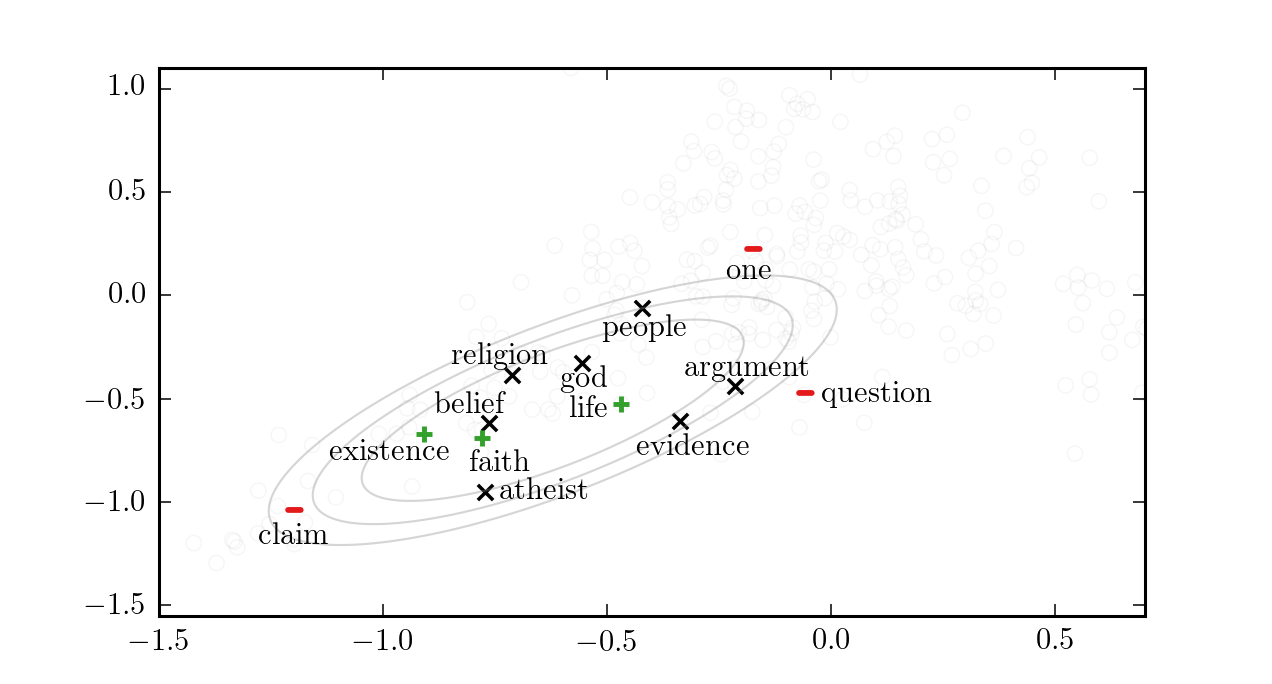

(-1.55, 1.1)

In [292]:
words = get_words_from_topics(df_topics_lda)
words = {w for t, w in words if w and (w in vectors_200 or w.capitalize() in vectors_200 or w.upper() in vectors_200)}
#highlight_words = ["system", "card", "video", "apple", "pc", "keyboard", "bit", "memory", "windows",
#                  "government", "people", "power", "world", "rights", "war", "politics", "country", "states",
#                  "current", "electricity"]
highlight_words = ["god", "believe", "one", "evidence", "religion", "people", "argument", "exist", "question", "atheists",
                   "faith", "belief", "existence", "life"]

#highlight_words = ["faith", "belief", "existence", "life"]

df_ralf = pnd.DataFrame([highlight_words, list(words)])

plot_topics_in_embedding_space(pca, df_ralf, vectors_200,
                               show_words=False, highlight_topics=[0], alpha=0.035, show_gaussians=True, draw_own=True)

lw = 1.6
lw_kept = 1.15
c_old = "black"
c_old = DARK_COLORS[2]
#c_old = "black"
marker_old = "$-$"
#marker_old = "o"
c_kept = "#33a02c"
c_kept = "black"
#c_kept = "white"
#c_kept = DARK_COLORS[0]
marker_kept = "x"
c_new = "black"
c_new = DARK_COLORS[1]
marker_new = "D"
marker_new = "+"
#marker_new = "o"

plt.text(-0.185694, +0.183254, "one", horizontalalignment='center', verticalalignment='top')
plt.scatter([-0.176592], [0.214906], c=c_old, marker=marker_old, s=25, alpha=1.0, linewidth=lw, edgecolors=c_old)
plt.text(+0.101021, -0.412730, "question", horizontalalignment='center', verticalalignment='top')
plt.scatter([-0.061523], [-0.481792], c=c_old, marker=marker_old, s=25, alpha=1.0, linewidth=lw, edgecolors=c_old)
plt.text(-1.200456, -1.099776, "claim", horizontalalignment='center', verticalalignment='top')
plt.scatter([-1.200176], [-1.050868], c=c_old, marker=marker_old, s=25, alpha=1.0, linewidth=lw, edgecolors=c_old)

plt.text(-0.810134, -0.473401, "belief", horizontalalignment='center', verticalalignment='top')
plt.scatter([-0.764757], [-0.617998], c=c_kept, marker=marker_kept, s=25, alpha=1.0, linewidth=lw_kept)
plt.text(-0.741648, -0.230032, "religion", horizontalalignment='center', verticalalignment='top')
plt.scatter([-0.712025], [-0.385751], c=c_kept, marker=marker_kept, s=25, alpha=1.0, linewidth=lw_kept)
plt.text(-0.642058, -0.884714, "atheist", horizontalalignment='center', verticalalignment='top')
plt.scatter([-0.773875], [-0.952152], c=c_kept, marker=marker_kept, s=25, alpha=1.0, linewidth=lw_kept)
plt.text(-0.552881, -0.343447, "god", horizontalalignment='center', verticalalignment='top')
plt.scatter([-0.557449], [-0.329148], c=c_kept, marker=marker_kept, s=25, alpha=1.0, linewidth=lw_kept)
plt.text(-0.418948, -0.093772, "people", horizontalalignment='center', verticalalignment='top')
plt.scatter([-0.421830], [-0.060277], c=c_kept, marker=marker_kept, s=25, alpha=1.0, linewidth=lw_kept)
plt.text(-0.313025, -0.671497, "evidence", horizontalalignment='center', verticalalignment='top')
plt.scatter([-0.338276], [-0.607840], c=c_kept, marker=marker_kept, s=25, alpha=1.0, linewidth=lw_kept)
###plt.text(-1.125789, -0.892848, "religion", horizontalalignment='center', verticalalignment='top')
###plt.scatter([-1.174623], [-1.099940], c='red', s=25, alpha=1.0, linewidth=0.5)
plt.text(-0.188603, -0.286825, "argument", horizontalalignment='center', verticalalignment='top')
plt.scatter([-0.214202], [-0.438073], c=c_kept, marker=marker_kept, s=25, alpha=1.0, linewidth=lw_kept)

plt.text(-0.989290, -0.697986, "existence", horizontalalignment='center', verticalalignment='top')
plt.scatter([-0.909689], [-0.670691], c=c_new, marker=marker_new, s=25, alpha=1.0, linewidth=lw)
plt.text(-0.540145, -0.490005, "life", horizontalalignment='center', verticalalignment='top')
plt.scatter([-0.469146], [-0.524452], c=c_new, marker=marker_new, s=25, alpha=1.0, linewidth=lw)
plt.text(-0.739985, -0.751415, "faith", horizontalalignment='center', verticalalignment='top')
plt.scatter([-0.778872], [-0.690025], c=c_new, marker=marker_new, s=25, alpha=1.0, linewidth=lw)

plt.xlim((-1.5, 0.7))
plt.ylim((-1.55, 1.1))

In [248]:
df_topics_lda.head(1)

0    1       2     3      4        5     6    7     8       9
0  would  one  writes  like  think  article  know  get  time  people

In [43]:
plot_topics_in_embedding_space(pca, df_topics_lda.head(3), vectors_20news_50)

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


TypeError: object of type 'NoneType' has no len()

/home/stefan.bunk/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


<IPython.core.display.Javascript object>


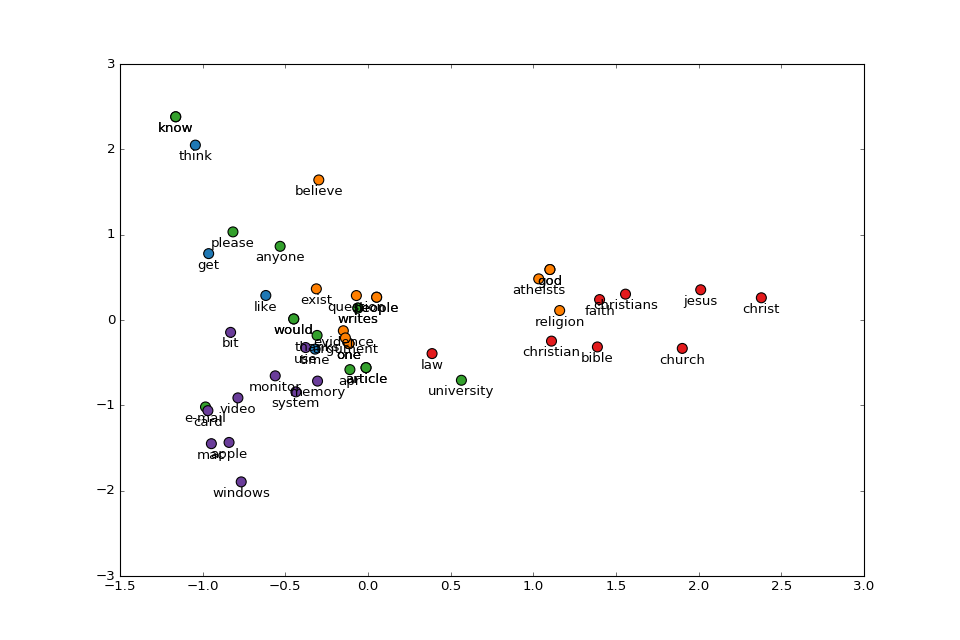

In [18]:
plot_topics_in_embedding_space(pca, df_topics_lda.head(5), vectors_200)

In [48]:
interesting_topics = [0, 4, 16]
df_topics_lda.ix[interesting_topics]

0        1       2     3       4        5        6      7       8  \
0    would      one  writes  like   think  article     know    get    time   
4     card  windows     bit   mac  system      use    video  apple  memory   
16  israel  israeli    jews  arab   arabs   writes  article  peace   would   

           9  
0     people  
4    monitor  
16  lebanese

**Topic 0** is a general stopword topic, it is spread widely

**Topic 4** is a good, coherent topic, where a good distribution can be approximated

**Topic 16** has the *stopword problem*: a general good topic is polluted by stopwords, which add noise to the parameter estimation of the distribution and can lead to a wrong mean

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


<IPython.core.display.Javascript object>


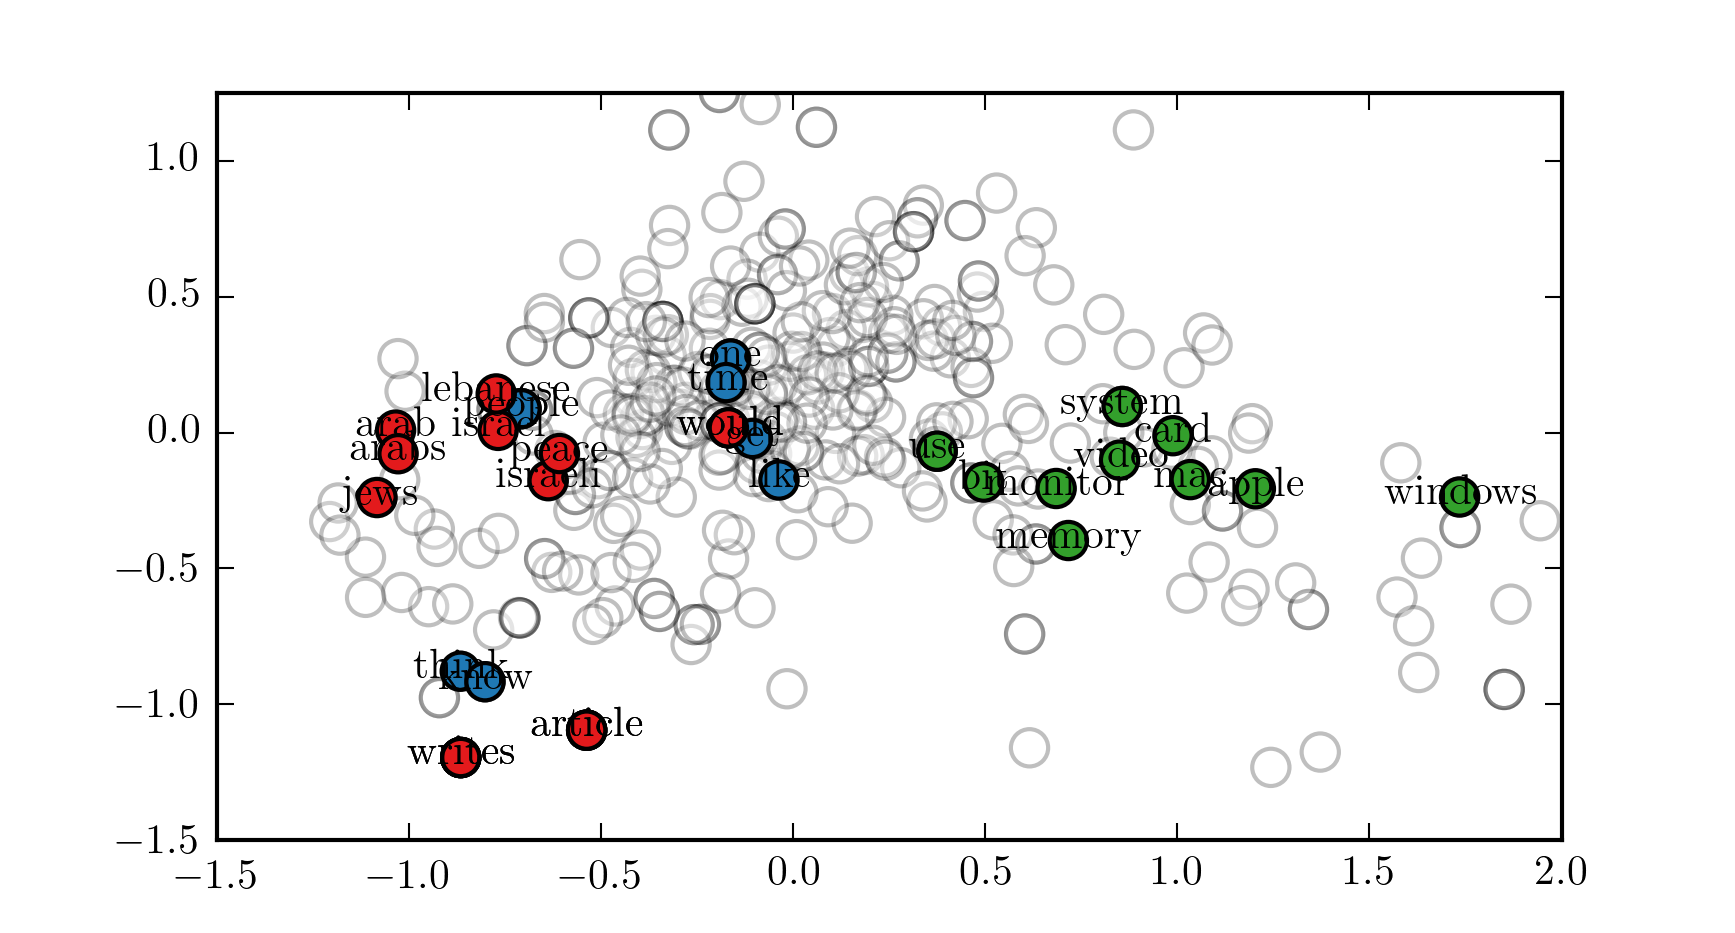

(-1.5, 1.25)

In [51]:
plot_topics_in_embedding_space(pca, df_topics_lda, vectors_200,
                               show_words=True, highlight_topics=interesting_topics, alpha=0.15, show_gaussians=False)
plt.xlim((-1.5, 2.0))
plt.ylim((-1.5, 1.25))

/home/stefan.bunk/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


<IPython.core.display.Javascript object>


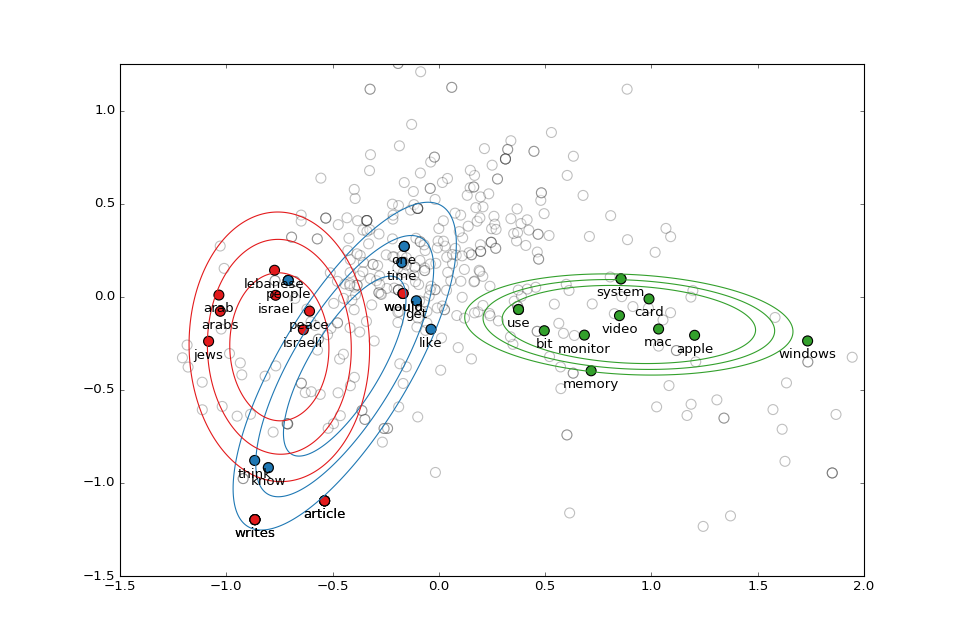

(-1.5, 1.25)

In [43]:
plot_topics_in_embedding_space(pca, df_topics_lda, vectors_200,
                               show_words=True, highlight_topics=interesting_topics, alpha=0.25, show_gaussians=True)
plt.xlim((-1.5, 2.0))
plt.ylim((-1.5, 1.25))

/home/stefan.bunk/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


<IPython.core.display.Javascript object>


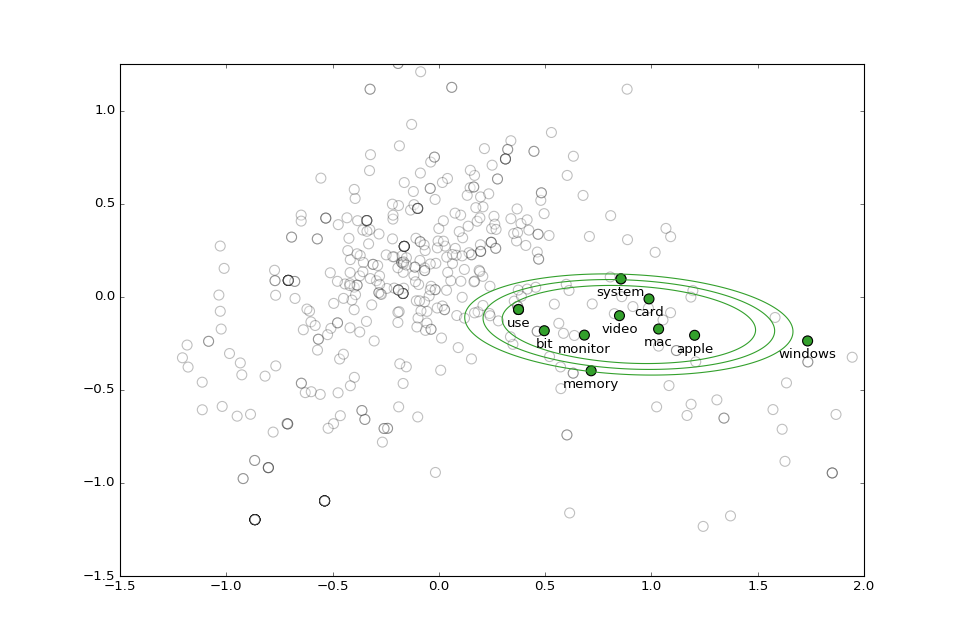

(-1.5, 1.25)

In [21]:
plot_topics_in_embedding_space(pca, df_topics_lda, vectors_200,
                               show_words=True, highlight_topics=[4], alpha=0.25, show_gaussians=True)
plt.xlim((-1.5, 2.0))
plt.ylim((-1.5, 1.25))

<IPython.core.display.Javascript object>


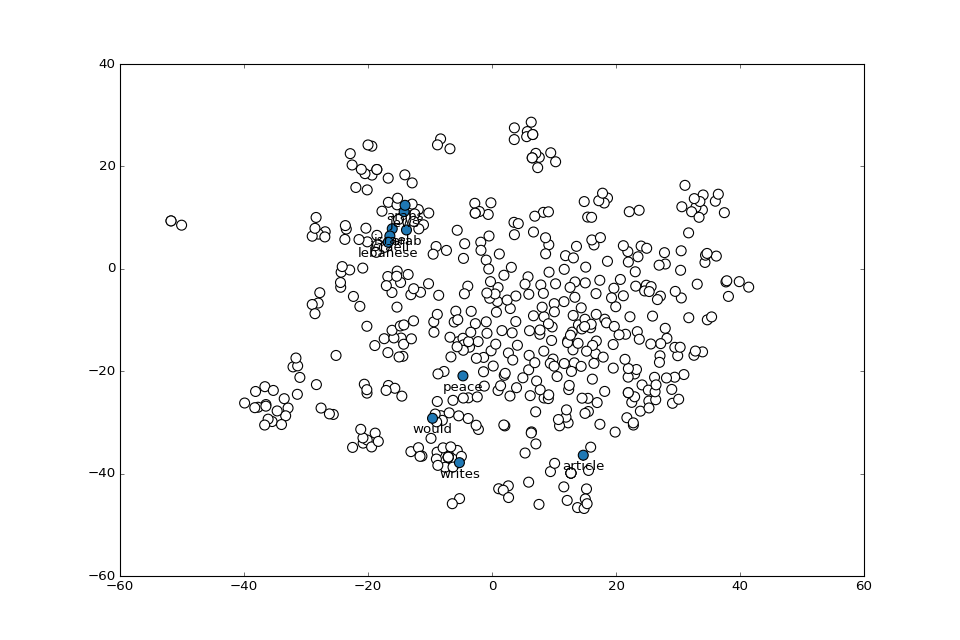

In [13]:
plot_topics_in_embedding_space(tsne_with_init_pca, df_topics_lda, vectors_200, show_words=True, highlight_topics=interesting_topics)

**Image for Ralf:**

In [41]:

words

{'a/c',
 'absolute',
 'adl',
 'ahf',
 'aids',
 'air',
 'algorithm',
 'allocation',
 'also',
 'amendment',
 'american',
 'among',
 'anonymous',
 'anyone',
 'appears',
 'apple',
 'application',
 'apr',
 'april',
 'arab',
 'arabs',
 'argument',
 'armenia',
 'armenian',
 'armenians',
 'art',
 'article',
 'atheists',
 'available',
 'average',
 'banks',
 'baseball',
 'batf',
 'believe',
 'best',
 'bible',
 'bike',
 'bikes',
 'bit',
 'bmw',
 'bob',
 'book',
 'books',
 'bos',
 'brian',
 'bus',
 'buy',
 'byte',
 'cal',
 'california',
 'came',
 'cancer',
 'car',
 'card',
 'cars',
 'cds',
 'char',
 'chi',
 'children',
 'chip',
 'christ',
 'christian',
 'christians',
 'church',
 'circuit',
 'city',
 'clinton',
 'clipper',
 'company',
 'condition',
 'conference',
 'connected',
 'control',
 'controller',
 'cop',
 'copies',
 'cops',
 'copy',
 'cost',
 'country',
 'court',
 'cover',
 'cramer',
 'crime',
 'cross',
 'data',
 'den',
 'det',
 'disease',
 'disk',
 'display',
 'doctor',
 'dod',
 'dog',
 'do

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


<IPython.core.display.Javascript object>


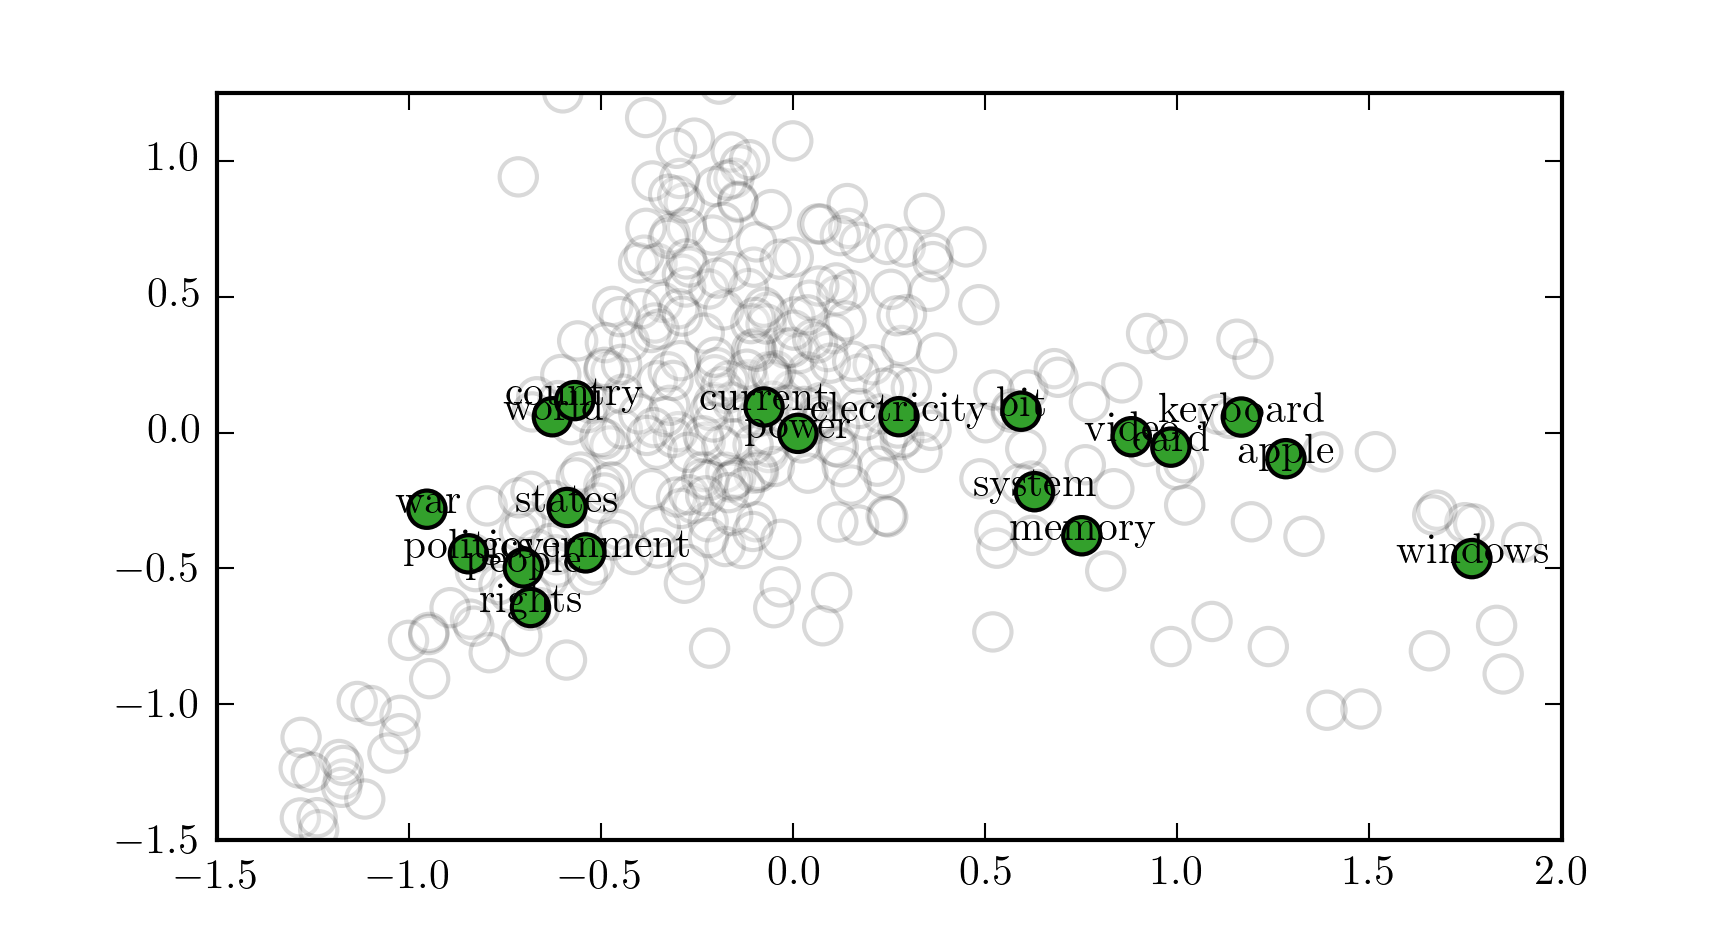

(-1.5, 1.25)

In [52]:
words = get_words_from_topics(df_topics_lda)
words = {w for t, w in words if w and (w in vectors_200 or w.capitalize() in vectors_200 or w.upper() in vectors_200)}
highlight_words = ["system", "card", "video", "apple", "pc", "keyboard", "bit", "memory", "windows",
                  "government", "people", "power", "world", "rights", "war", "politics", "country", "states",
                  "current", "electricity"]
df_ralf = pnd.DataFrame([highlight_words, list(words)])

plot_topics_in_embedding_space(pca, df_ralf, vectors_200,
                               show_words=True, highlight_topics=[0], alpha=0.15, show_gaussians=False)
plt.xlim((-1.5, 2.0))
plt.ylim((-1.5, 1.25))

Learn stopwords with alpha0Boost LDA. That way, all the stopwords group together in topic 0.
Then, always replace words from topic 0 during sampling.

Other idea: Do not consider stopwords, when estimating distribution parameters.

## Misc

### Dimensions vs. Word Sim

<IPython.core.display.Javascript object>


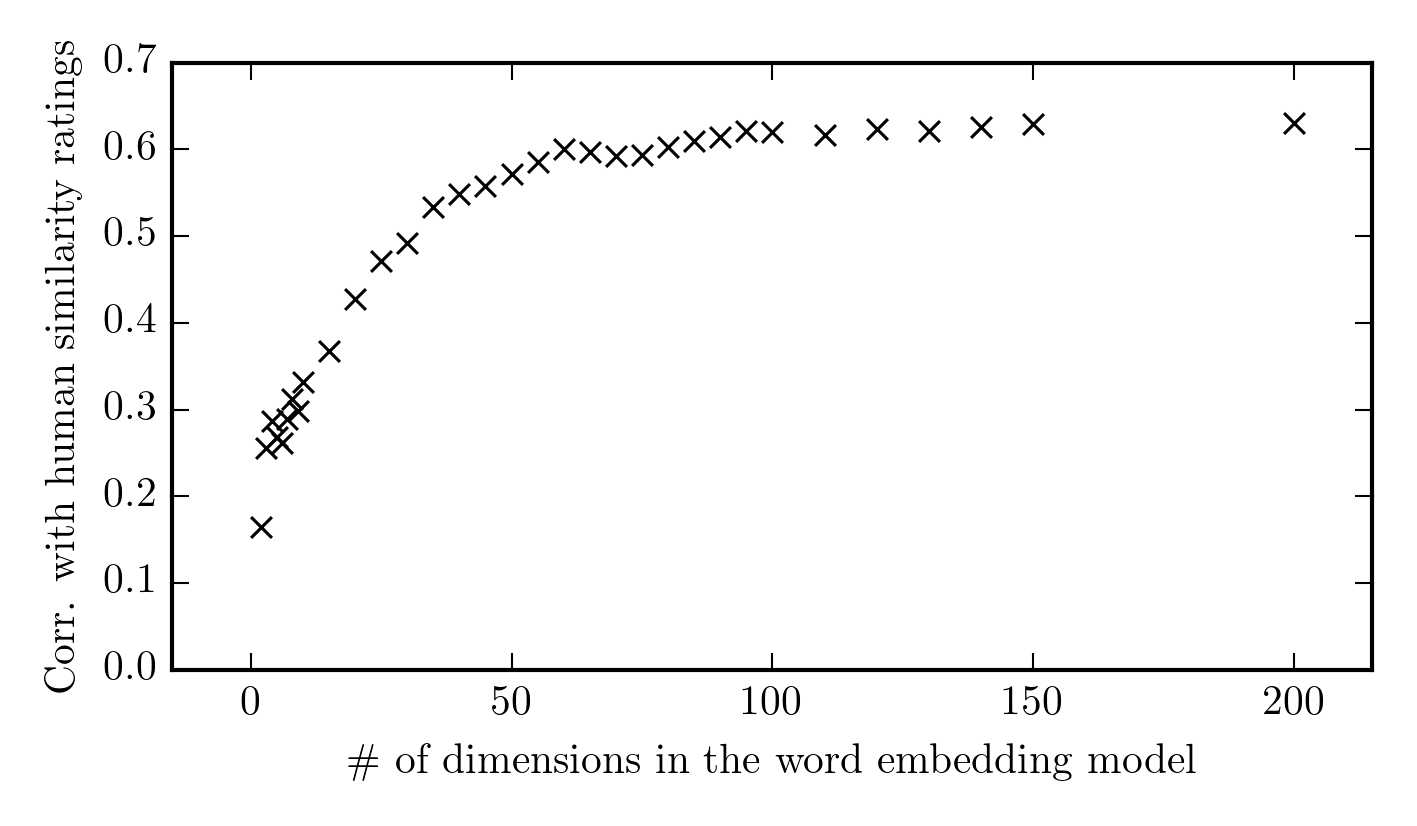

In [21]:
df_corr = pnd.DataFrame([
        [  2, 0.164313723782],
        [  3, 0.256176592548],
        [  4, 0.287232385471],
        [  5, 0.268592006809],
        [  6, 0.261913996314],
        [  7, 0.289160806347],
        [  8, 0.312587806982],
        [  9, 0.298294862885],
        [ 10, 0.331600576619],
        [ 15, 0.367711037349],
        [ 20, 0.427497429754],
        [ 25, 0.471704421159],
        [ 30, 0.492563877246],
        [ 35, 0.533177072882],
        [ 40, 0.548170365785],
        [ 45, 0.557571955648],
        [ 50, 0.571644472323],
        [ 55, 0.585267445892],
        [ 60, 0.600522318933],
        [ 65, 0.596909635835],
        [ 70, 0.592062065752],
        [ 75, 0.593791901276],
        [ 80, 0.603061316367],
        [ 85, 0.609424411479],
        [ 90, 0.614154814661],
        [ 95, 0.621192032861],
        [100, 0.620182795692],
        [110, 0.616322039816],
        [120, 0.623648522916],
        [130, 0.620805117798],
        [140, 0.625749337877],
        [150, 0.628758110603],
        [200, 0.629901613512]
    ], columns=["dimensions", "similarity_correlation"])

plt.figure(figsize=cm2inch(12, 7), dpi=300)
plt.scatter(df_corr["dimensions"], df_corr["similarity_correlation"], marker="x", s=25, color="black", linewidth=0.75)
plt.xlim((-15, 215))
plt.ylim((0.0, 0.7))
plt.xlabel("\\# of dimensions in the word embedding model")
plt.ylabel("Corr. with human similarity ratings")
plt.tight_layout()

### LDA Convergence

<IPython.core.display.Javascript object>


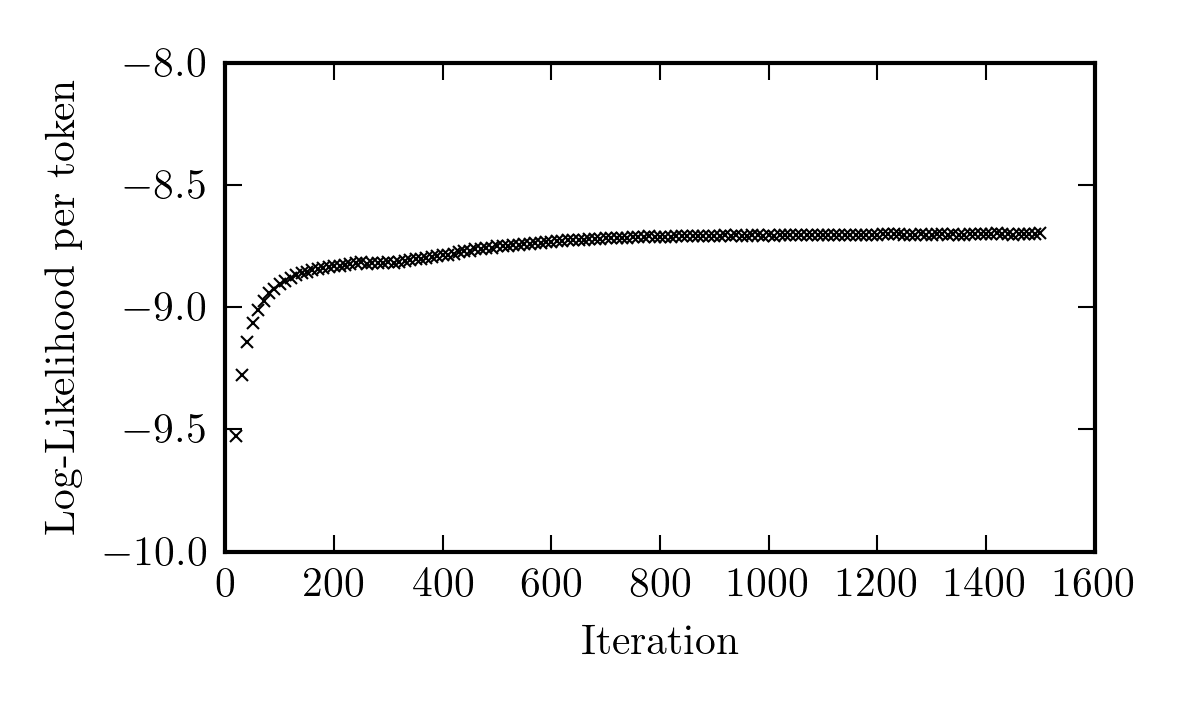

In [6]:
df_lda_convergence = pnd.read_csv("/home/knub/Repositories/master-thesis/results/lda_convergence.tsv", sep="\t", header=None)
df_lda_convergence.columns = ["iteration", "LL"]


plt.figure(figsize=cm2inch(10, 6), dpi=300)
plt.plot(df_lda_convergence.iteration, df_lda_convergence.LL, linestyle="None", color='black', linewidth=0.25,
         marker='x', markersize=3, label="Log likelihood")

plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood per token")
plt.ylim((-10, -8))

#plt.legend(loc="best", numpoints=1)
plt.tight_layout()


### LSH vs KDTree

<IPython.core.display.Javascript object>


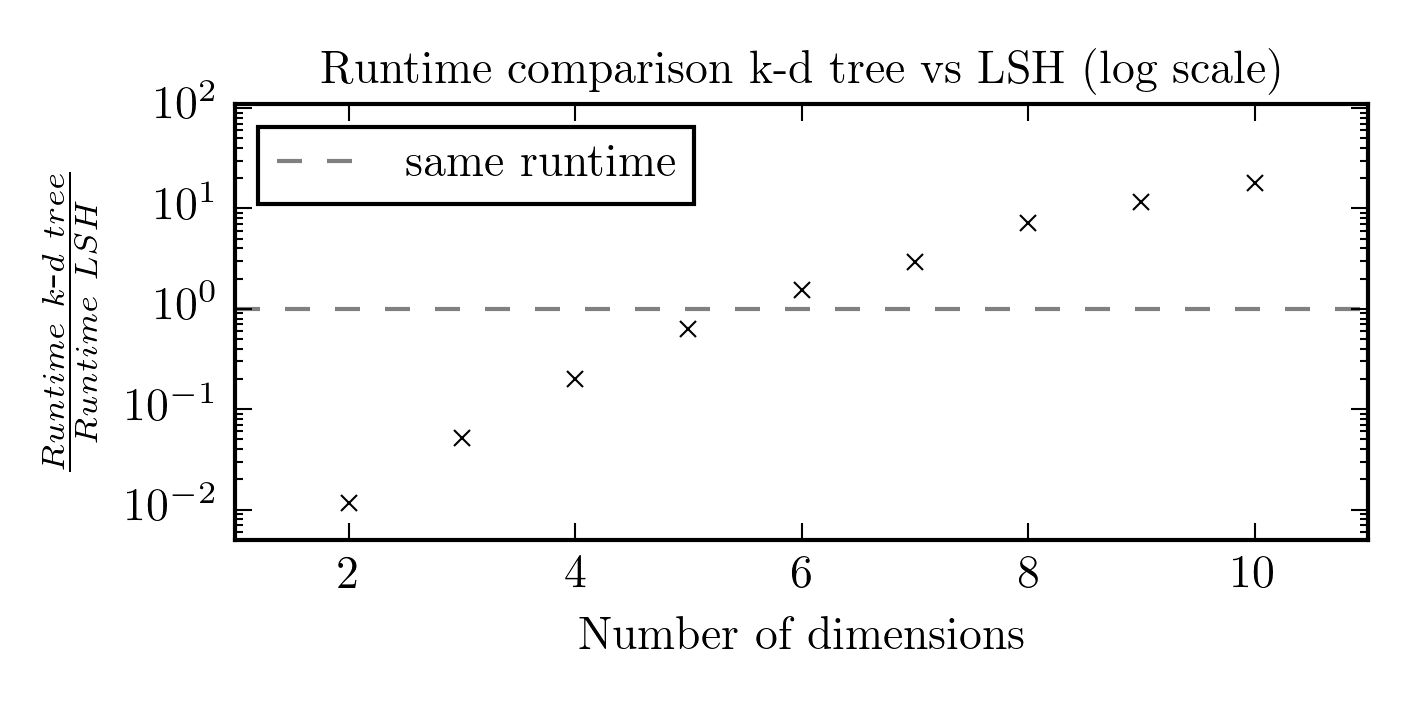

In [44]:
df_lsh_vs_kdtree = pnd.read_csv("/home/knub/Repositories/master-thesis/results/nearest_neighbour_search_performance.tsv",
                                sep="\t")
df_lsh_vs_kdtree["ratio"] = df_lsh_vs_kdtree["kdtree"] / df_lsh_vs_kdtree["lsh"]
plt.figure(figsize=cm2inch(12, 6), dpi=300)
plt.axhline(y=1, linewidth=1.0, color='gray', ls='--', label="same runtime")
#plt.axvline(x=5, linewidth=2, color='gray', ls='--')
plt.semilogy(df_lsh_vs_kdtree["dimensions"], df_lsh_vs_kdtree["ratio"], 'x',
             c='black', markersize=4, label=None)
plt.xlabel("Number of dimensions")
plt.ylabel("$\\frac{Runtime~k\\mbox{-}d~tree}{Runtime~LSH}$")
plt.xlim((1, 11))
plt.ylim((0.005, 110))
plt.title("Runtime comparison k-d tree vs LSH (log scale)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[:1], labels[:1], loc='upper left', numpoints=1)
plt.tight_layout()

In [10]:
TOPICS_WELDA = "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-6/welda.iteration-200.topics"
translated_interesting_topics = [33, 37]
df_topics_welda = read_topics(TOPICS_WELDA)
df_topics_welda.ix[translated_interesting_topics]

IOError: [Errno 2] No such file or directory: '/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-6/welda.iteration-200.topics'

In [75]:
plot_topics_in_embedding_space(pca, df_topics_welda, vectors_200, show_words=True, highlight_topics=translated_interesting_topics)

NameError: name 'plot_topics_in_embedding_space' is not defined